### Flipping Houses in a Decentralized Market
# Jakub Pawelczak JMP 2024

## Main code
Code below solves household problems
$$\sigma(\delta)\Delta V(\delta)=\delta+\gamma\int_0^1\Delta V(\delta')dG(\delta')+\lambda F(0)\Delta V(\delta_1) 1[\delta<\delta_1]+\lambda F(1)\Delta V(\delta_0) 1[\delta>\delta_0]+$$
 $$+\frac{\rho}{2}\int_\delta^1 \Delta V(\delta') dH(0,\delta')+\frac{\rho}{2}\int_0^\delta  \Delta V(\delta') dH(1,\delta')$$
 where
$$\sigma(\delta)=r+\gamma+\lambda F(0) 1[\delta<\delta_1]+\lambda F(1) 1[\delta>\delta_0]+\frac{\rho}{2}\int_\delta^1 dH(0,\delta')+\frac{\rho}{2}\int_0^\delta dH(1,\delta')$$
flippers problems
$$ r W(1)=\max_{P_1} \lambda\int_{0}^{\bar{\delta}} dH(0,\delta)[P_1 +W(0)-W(1)]$$
$$r W(0)=\max_{P_0} \lambda\int_{0}^{\bar{\delta}}dH(1,\delta)[-P_0 +W(1)-W(0)] $$

and distributions using
$$     \int^{\bar{\delta}}_0 dH(1,\delta) + F(1)=s$$
$$ \quad \int_0^{\delta} dH(0,\delta)+\int_0^{\delta}dH(1,\delta)=G(\delta) \quad \forall \delta \in [0,\bar{\delta}]$$
$$    F(0)+F(1)=f$$
$$     \lambda F(1)\int_{\delta_0^*}^{\max\{\delta,\delta_0^*\}}dH(0,\delta')+\gamma G(\delta)\int^{1}_{\delta}dH(1,\delta')=\lambda F(0)\int_0^{\min\{\delta,\delta_1^*\}}dH(1,\delta')+\gamma (1-G(\delta))\int_0^{\delta}dH(1,\delta')+ \rho\int_0^\delta dH(1,\delta')\int_\delta^1 dH(0,\delta')$$

## Parameters

In [4]:
import numpy as np
from scipy.integrate import quad
from scipy.optimize import fsolve
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import time
from scipy.optimize import minimize
from scipy.integrate import IntegrationWarning
from scipy.integrate import quad, simps
import warnings
import seaborn as sns

warnings.filterwarnings("ignore")

# Configure matplotlib to use the pgf backend
plt.rcParams.update({
    "pgf.texsystem": "pdflatex",  # Change this if using xelatex or lualatex
    "text.usetex": True,          # Use LaTeX to write all text
    "font.family": "serif",
    "axes.labelsize": 20,         # LaTeX default is 10pt font.
    "font.size": 20,
    "legend.fontsize": 20,
    "xtick.labelsize": 20,
    "ytick.labelsize": 20,
    "axes.titlesize": 30, 
    "pgf.preamble": r"""
        \usepackage[utf8]{inputenc}    # Use UTF8 input encoding
        \usepackage[T1]{fontenc}       # Use T1 fonts
        \usepackage{amsmath}           # For math
    """
})

# Constants
delta_0_star_initial, delta_1_star_initial =0.47716112847660036, 0.11112649047308443
f=0.0048366897
s = 0.6884162140
r = 0.0361577940
gamma=0.0867540457
rho =0.4133277998
lambda1 =3.9750228339
delta_bar = 1
N_points = 101
delta_grid = np.linspace(0, delta_bar, N_points)


delta_bar = 1
N_points = 101
delta_grid = np.linspace(0, delta_bar, N_points)
grid_spacing = delta_grid[1] - delta_grid[0]

fixed_params = {
    'f': f,
    's': s,
    'r': r,
    'gamma': gamma,
    'rho': rho,
    'lambda1': lambda1
}

ModuleNotFoundError: No module named 'numpy'

## Solving model

In [692]:
# Define the case functions for H1
def H1_case_C(delta, F1_val, r, gamma, s, f, lambda1, rho):
    a = rho
    b = lambda1 * (f - F1_val) + gamma * (1 - delta) + rho * (1 - delta - s + F1_val) + gamma * delta
    c = -gamma * delta * (s - F1_val)
    discriminant = b**2 - 4 * a * c
    if a == 0:
        H1_delta = -c / b
    elif discriminant >= 0:
        H1_delta = (-b + np.sqrt(discriminant)) / (2 * a)
    else:
        H1_delta = (-b) / (2 * a)  # Fallback: Use the midpoint formula when discriminant is negative
    return H1_delta

def H1_case_D(delta, H1_delta1, F1_val, r, gamma, s, f, lambda1, rho):
    a = rho
    b = gamma * (1 - delta) + rho * (1 - delta - s + F1_val) + gamma * delta
    c = -gamma * delta * (s - F1_val) + lambda1 * (f - F1_val) * H1_delta1
    discriminant = b**2 - 4 * a * c
    if a == 0:
        H1_delta = -c / b
    elif discriminant >= 0:
        H1_delta = (-b + np.sqrt(discriminant)) / (2 * a)
    else:
        H1_delta = (-b) / (2 * a)  # Fallback: Use the midpoint formula when discriminant is negative
    return H1_delta

def H1_case_E(delta, H1_delta0, F1_val, r, gamma, s, f, lambda1, rho, H1_delta1, delta_0_star):
    a = rho
    b = gamma * (1 - delta) + rho * (1 - delta - s + F1_val) + lambda1 * F1_val + gamma * delta
    c = - (lambda1 * F1_val * (delta - delta_0_star + H1_delta0) + gamma * delta * (s - F1_val) - lambda1 * (f - F1_val) * H1_delta1)
    discriminant = b**2 - 4 * a * c
    if a == 0:
        H1_delta = -c / b
    elif discriminant >= 0:
        H1_delta = (-b + np.sqrt(discriminant)) / (2 * a)
    else:
        H1_delta = (-b) / (2 * a)  # Fallback: Use the midpoint formula when discriminant is negative
    return H1_delta

# Helper functions for H1 and H0 computations
def H1_delta1_comp(F1_val, r, gamma, s, f, lambda1, rho, delta_1_star):
    a = rho
    b = lambda1 * (f - F1_val) + gamma * (1 - delta_1_star) + rho * (1 - delta_1_star - s + F1_val) + gamma * delta_1_star
    c = -gamma * delta_1_star * (s - F1_val)
    if a == 0:
        H1_delta1 = -c / b
    else:
        discriminant = b**2 - 4 * a * c 
        if discriminant < 0:
            raise ValueError("Negative discriminant in quadratic equation.")
        H1_delta1 = (-b + np.sqrt(discriminant)) / (2 * a)
    return H1_delta1

def H1_delta0_comp(F1_val, H1_delta1, r, gamma, s, f, lambda1, rho, delta_0_star):
    a = rho
    b = gamma * (1 - delta_0_star) + rho * (1 - delta_0_star - s + F1_val) + gamma * delta_0_star
    c = -gamma * delta_0_star * (s - F1_val) + lambda1 * (f - F1_val) * H1_delta1
    if a == 0:
        H1_delta0 = -c / b
    else:
        discriminant = b**2 - 4 * a * c
        if discriminant < 0:
            raise ValueError("Negative discriminant in quadratic equation.")
        H1_delta0 = (-b + np.sqrt(discriminant)) / (2 * a)
    return H1_delta0

def trade_condition(F1_val, r, gamma, s, f, lambda1, rho, delta_1_star, delta_0_star):
    H1_delta1 = H1_delta1_comp(F1_val, r, gamma, s, f, lambda1, rho, delta_1_star)
    H1_delta0 = H1_delta0_comp(F1_val, H1_delta1, r, gamma, s, f, lambda1, rho, delta_0_star)
    left_side = F1_val * (1 - delta_0_star - s + F1_val + H1_delta0)
    right_side = (f - F1_val) * H1_delta1
    return left_side - right_side

# Solver for F1
def solve_F1(delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho):
    F1_initial = f
    F1_solution = fsolve(trade_condition, F1_initial, args=(r, gamma, s, f, lambda1, rho, delta_1_star, delta_0_star))
    return F1_solution[0]

def F1(delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho):
    return solve_F1(delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho)

def F0(delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho):
    return f - F1(delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho)

def H1(delta, delta_0_star, delta_1_star, F1_val, r, gamma, s, f, lambda1, rho):
    # Compute the transition values to ensure continuity
    H1_delta1 = H1_case_C(delta_1_star, F1_val, r, gamma, s, f, lambda1, rho)
    H1_delta0 = H1_case_D(delta_0_star, H1_delta1, F1_val, r, gamma, s, f, lambda1, rho)
    
    if 0 < delta <= delta_1_star:
        return H1_case_C(delta, F1_val, r, gamma, s, f, lambda1, rho)
    elif delta_1_star < delta < delta_0_star:
        return H1_case_D(delta, H1_delta1, F1_val, r, gamma, s, f, lambda1, rho)
    elif delta_0_star <= delta <= 1:
        return H1_case_E(delta, H1_delta0, F1_val, r, gamma, s, f, lambda1, rho, H1_delta1, delta_0_star)
    else:
        return 0  # Fallback to avoid returning None

def H0(delta, delta_0_star, delta_1_star, F1_val, r, gamma, s, f, lambda1, rho):
    if 0 < delta <= 1:
        return delta - H1(delta, delta_0_star, delta_1_star, F1_val, r, gamma, s, f, lambda1, rho)
    else:
        return 0

def compute_H_values(delta_grid, delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho):
    F1_val = F1(delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho)
    H1_values = []
    H0_values = []

    for delta in delta_grid:
        
        H1_val = H1(delta, delta_0_star, delta_1_star, F1_val, r, gamma, s, f, lambda1, rho)
        H0_val = H0(delta, delta_0_star, delta_1_star, F1_val, r, gamma, s, f, lambda1, rho)
        # Check for None, NaN, or other invalid values
        if H1_val is None or np.isnan(H1_val):
            H1_val = 0  # Or some other default or error-handling value
        if H0_val is None or np.isnan(H0_val):
            H0_val = 0  # Or some other default or error-handling value
        
        H1_values.append(H1_val)
        H0_values.append(H0_val)

    return np.array(H1_values), np.array(H0_values)

def dH1(delta, delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho):
    F1_val = F1(delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho)
    F0_val = F0(delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho)

    H1_val = H1(delta, delta_0_star, delta_1_star, F1_val, r, gamma, s, f, lambda1, rho)

    if 0 <= delta <= delta_1_star:
        b = lambda1 * F0_val + gamma + rho * (1 - delta - s + F1_val + 2 * H1_val)
        c = gamma * (s - F1_val) + rho * H1_val
    elif delta_1_star < delta < delta_0_star:
        b = gamma + rho * (1 - delta - s + F1_val + 2 * H1_val)
        c = gamma * (s - F1_val) + rho * H1_val
    elif delta >= delta_0_star:
        b = lambda1 * F1_val + gamma + rho * (1 - delta - s + F1_val + 2 * H1_val)
        c = lambda1 * F1_val + gamma * (s - F1_val) + rho * H1_val
    else:
        return 0

    return c / b
def dH0(delta, delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho):
    return 1 - dH1(delta, delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho)

def dH1_gen(delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho):
    H1_values, H0_values = compute_H_values(delta_grid, delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho)

    dH1_values = np.zeros_like(delta_grid)
    F1_val = F1(delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho)
    F0_val = F0(delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho)
    
    for i, delta in enumerate(delta_grid):
        H1_delta = H1_values[i]
        
        if 0 <= delta <= delta_1_star:
            a = 0
            b = lambda1 * F0_val + gamma + rho * (1 - delta - s + F1_val + 2 * H1_delta)
            c = gamma * (s - F1_val) + rho * H1_delta
        elif delta_1_star < delta < delta_0_star:
            a = 0
            b = gamma + rho * (1 - delta - s + F1_val + 2 * H1_delta)
            c = gamma * (s - F1_val) + rho * H1_delta
        elif delta >= delta_0_star:
            a = 0
            b = lambda1 * F1_val + gamma + rho * (1 - delta - s + F1_val + 2 * H1_delta)
            c = lambda1 * F1_val + gamma * (s - F1_val) + rho * H1_delta
        else:
            dH1_values[i] = 0  # or some default value
            continue  # Skip to the next iteration to avoid unintended behavior
        
        if b != 0:  # To avoid division by zero
            dH1_values[i] = c / b
        else:
            dH1_values[i] = 0  # Handle the special case where b is zero
        
    return np.array(dH1_values)



def dH0_gen(delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho):
    
    # Simply return 1 - dH1_gen, which will be an array
    return 1 - dH1_gen(delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho)


def dH0Delta(delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho):
    H1_values, H0_values = compute_H_values(delta_grid, delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho)
    dH0_values = dH0_gen(  delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho)
    dH1_values = dH1_gen( delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho)

    n = len(delta_grid)
    dH0Delta_matrix = np.zeros((n, n))  # Create an n x n matrix filled with zeros
    for i in range(n - 1):
        dH0Delta_matrix[i, i + 1:] = dH0_values[i + 1:] * grid_spacing  # Use the array values here
    return dH0Delta_matrix

def dH1Delta(delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho):
    H1_values, H0_values = compute_H_values(delta_grid, delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho)
    dH0_values = dH0_gen( delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho)
    dH1_values = dH1_gen( delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho)

    n = len(delta_grid)
    dH1Delta_matrix = np.zeros((n, n))  # Create an n x n matrix filled with zeros
    for i in range(1, n):
        dH1Delta_matrix[i, :i] = dH1_values[:i] * grid_spacing  # Use the array values here
    return dH1Delta_matrix

def Sigma(delta_grid, delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho):
    F1_val = F1(delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho)
    F0_val = f - F1_val

    sigma_values = np.zeros_like(delta_grid)
    H0_1 = H0(1.0, delta_0_star, delta_1_star, F1_val, r, gamma, s, f, lambda1, rho)
    
    for i, delta in enumerate(delta_grid):
        H0_delta = H0(delta, delta_0_star, delta_1_star, F1_val, r, gamma, s, f, lambda1, rho)
        H1_delta = H1(delta, delta_0_star, delta_1_star, F1_val, r, gamma, s, f, lambda1, rho)
        
        if delta < delta_1_star:
            sigma_values[i] = r + gamma + lambda1 * F0_val + (rho / 2) * (H0_1 - H0_delta) + (rho / 2) * H1_delta
        elif delta_1_star <= delta <= delta_0_star:
            sigma_values[i] = r + gamma + (rho / 2) * (H0_1 - H0_delta) + (rho / 2) * H1_delta
        elif delta > delta_0_star:
            sigma_values[i] = r + gamma + lambda1 * F1_val + (rho / 2) * (H0_1 - H0_delta) + (rho / 2) * H1_delta
    return np.diag(sigma_values)

def dG_outer_1T(delta_grid,r, gamma, s, f, lambda1, rho):
    dG = np.full_like(delta_grid, 1 / len(delta_grid))
    return np.outer(dG, np.ones_like(delta_grid))

def W1(delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho):
    # Define the continuous functions
    F1_val = F1(delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho)
    F0_val = F0(delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho)
    
    # Calculate necessary values using continuous functions
    H0_1 = H0(1.0, delta_0_star, delta_1_star, F1_val, r, gamma, s, f, lambda1, rho)
    H0_delta0_star = H0(delta_0_star, delta_0_star, delta_1_star, F1_val, r, gamma, s, f, lambda1, rho)
    H1_delta0_star = H1(delta_0_star, delta_0_star, delta_1_star, F1_val, r, gamma, s, f, lambda1, rho)
    
    sigma_delta0 = r + gamma + (rho / 2) * (H0_1 - H0_delta0_star) + (rho / 2) * H1_delta0_star
    

    # Integrate dH0 from delta_0_star to 1
    dH0_delta0 = dH0(delta_0_star, delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho)
    
    if dH0_delta0 == 0:
        dH0_delta0=0.0000001
    
    return (lambda1 / r) * (H0_1 - H0_delta0_star)**2 / (sigma_delta0 * dH0_delta0)

def W0(delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho):
    # Define the continuous functions
    F1_val = F1(delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho)
    F0_val = F0(delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho)
        
    # Calculate necessary values using continuous functions
    H0_1 = H0(1.0, delta_0_star, delta_1_star, F1_val, r, gamma, s, f, lambda1, rho)
    H0_delta1_star = H0(delta_1_star, delta_0_star, delta_1_star, F1_val, r, gamma, s, f, lambda1, rho)
    H1_delta1_star = H1(delta_1_star, delta_0_star, delta_1_star, F1_val, r, gamma, s, f, lambda1, rho)
    
    sigma_delta1 = r + gamma + (rho / 2) * (H0_1 - H0_delta1_star) + (rho / 2) * H1_delta1_star

    # Integrate dH1 from delta_1_star to 0
    dH1_delta1 = dH1(delta_1_star, delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho)
    
    if dH1_delta1 == 0:
        dH1_delta1=0.0000001
    
    return (lambda1 / r) * H1_delta1_star**2 / (sigma_delta1 * dH1_delta1)

def value_iteration(delta_grid, delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho, max_iterations=3000, tolerance=1e-10):
    # Initialize the vector for \Delta V
    X_n = np.zeros_like(delta_grid)
    F1_val = F1(delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho)
    F0_val = f - F1_val
    # Compute H1_values and H0_values as arrays
    H1_values, H0_values = compute_H_values(delta_grid, delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho)

    # Initialize dH0_values and dH1_values as arrays by using the _gen functions
    dH0_values = dH0_gen( delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho)
    dH1_values = dH1_gen( delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho)

    # Now pass these arrays to the next functions
    dH0Delta_matrix = dH0Delta(delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho)
    dH1Delta_matrix = dH1Delta(delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho)
    
    Sigma_matrix = Sigma(delta_grid, delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho)
    dG_outer_1T_matrix = dG_outer_1T(delta_grid,r, gamma, s, f, lambda1, rho)
    
    delta_1_index = np.argmin(np.abs(delta_grid - delta_1_star))
    delta_0_index = np.argmin(np.abs(delta_grid - delta_0_star))
     
    matrix_1 = np.array([[1 if j == delta_1_index and i < delta_1_index else 0 for j in range(len(delta_grid))] for i in range(len(delta_grid))])
    matrix_0 = np.array([[1 if j == delta_0_index and i > delta_0_index else 0 for j in range(len(delta_grid))] for i in range(len(delta_grid))])

    for iteration in range(max_iterations):
        X_n_old = X_n.copy()
        
        Y = delta_grid
        indicator_delta_1 = np.where(delta_grid < delta_1_star, 1, 0)
        indicator_delta_0 = np.where(delta_grid > delta_0_star, 1, 0)
        
        #RHS = Y + lambda1 * F0_val * X_n[delta_1_index] * indicator_delta_1 + lambda1 * F1_val * X_n[delta_0_index] * indicator_delta_0
        
        #matrix_to_invert = Sigma_matrix - gamma * dG_outer_1T_matrix - (rho / 2) * dH0Delta_matrix - (rho / 2) * dH1Delta_matrix
        RHS = Y + lambda1 * F0_val * X_n[delta_1_index] * indicator_delta_1 + lambda1 * F1_val * X_n[delta_0_index] * indicator_delta_0
        
        matrix_to_invert = Sigma_matrix - gamma * dG_outer_1T_matrix - (rho / 2) * dH0Delta_matrix - (rho / 2) * dH1Delta_matrix
        
        matrix_inv = np.linalg.inv(matrix_to_invert)
        
        X_n = np.dot(matrix_inv, RHS)
        
        if np.max(np.abs(X_n - X_n_old)) < tolerance:
            break
    
    return X_n, matrix_to_invert

def find_optimal_deltas_iterative(r, gamma, s, f, lambda1, rho, delta_grid, delta_0_star_initial, 
                                  delta_1_star_initial, chi=0.03,tolerance= 1e-3):
    max_iterations = 3000
    #tolerance = 1e-3
    chi = min(r / lambda1 if rho != 0 else r / lambda1, 1 / gamma)
    chi=0.03
    start_time = time.time()
    delta_0_star = max(delta_0_star_initial, delta_1_star_initial)
    delta_1_star = min(delta_1_star_initial, delta_0_star_initial)
    
    for outer_iteration in range(max_iterations):
        Delta_V, matrix_to_invert = value_iteration(delta_grid, delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho)

        Delta_V_interp = interp1d(delta_grid, Delta_V, kind='linear', fill_value="extrapolate")

        Sigma_matrix = Sigma(delta_grid, delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho)

        W_0 = W0(delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho)
        W_1 = W1(delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho)

        H0_1 = H0(1.0, delta_0_star, delta_1_star, F1(delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho), r, gamma, s, f, lambda1, rho)
        H0_delta0_star = H0(delta_0_star, delta_0_star, delta_1_star, F1(delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho), r, gamma, s, f, lambda1, rho)
        H1_delta0_star = H1(delta_0_star, delta_0_star, delta_1_star, F1(delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho), r, gamma, s, f, lambda1, rho)
        H0_delta1_star = H0(delta_1_star, delta_0_star, delta_1_star, F1(delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho), r, gamma, s, f, lambda1, rho)
        H1_delta1_star = H1(delta_1_star, delta_0_star, delta_1_star, F1(delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho), r, gamma, s, f, lambda1, rho)

        sigma_delta0 = r + gamma + (rho / 2) * (H0_1 - H0_delta0_star) + (rho / 2) * H1_delta0_star
        sigma_delta1 = r + gamma + (rho / 2) * (H0_1 - H0_delta1_star) + (rho / 2) * H1_delta1_star

        int1_delta0 = quad(lambda delta: Delta_V_interp(delta) * dH0(delta, delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho), delta_0_star, 1)[0]
        int2_delta0 = quad(lambda delta: Delta_V_interp(delta) * dH1(delta, delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho), 0, delta_0_star)[0]
        int3_delta0 = np.mean(Delta_V)
        
        int1_delta1 = quad(lambda delta: Delta_V_interp(delta) * dH0(delta, delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho), delta_1_star, 1)[0]
        int2_delta1 = quad(lambda delta: Delta_V_interp(delta) * dH1(delta, delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho), 0, delta_1_star)[0]
        int3_delta1 = np.mean(Delta_V)
        if H0_1 - H0_delta0_star==0:
            H0_delta0_star=0.0000001+H0_1
        if H1_delta1_star==0:
            H1_delta1_star=0.0000001
             
        delta_0_star_new = sigma_delta0 * ((1 + r / (lambda1 * (H0_1 - H0_delta0_star))) * W_1 - W_0) - (rho / 2) * int1_delta0 - (rho / 2) * int2_delta0 - gamma * int3_delta0
        delta_1_star_new = sigma_delta1 * (W_1 - (1 + r / (lambda1 * H1_delta1_star)) * W_0) - (rho / 2) * int1_delta1 - (rho / 2) * int2_delta1 - gamma * int3_delta1
         # Clamp delta_0_star_new and delta_1_star_new within [0, 1]
        delta_0_star_new = min(max(delta_0_star_new, 0), 1)
        delta_1_star_new = min(max(delta_1_star_new, 0), 1)
        #print(f"Iteration {outer_iteration}: delta_0_star_new = {delta_0_star_new}, delta_1_star_new = {delta_1_star_new}")
       
        if abs(delta_0_star_new - delta_0_star) < tolerance and abs(delta_1_star_new - delta_1_star) < tolerance:
            return delta_0_star, delta_1_star
        delta_0_star = chi * delta_0_star_new + (1 - chi) * delta_0_star
        delta_1_star = chi * delta_1_star_new + (1 - chi) * delta_1_star
        #print(f"Iteration {outer_iteration}: Updated delta_0_star = {delta_0_star}, Updated delta_1_star = {delta_1_star}")

    end_time = time.time()
    time_taken = end_time - start_time

    print(f'Cutoffs Converged in {outer_iteration} iterations')
    print(f'Time taken to converge: {time_taken:.2f} seconds')
    print(f'Final delta_0_star: {delta_0_star}, Final delta_1_star: {delta_1_star}')

    return delta_0_star, delta_1_star

# Calculate P(δ, δ')
def P(delta, delta_prime, Delta_V_interp):
    return 0.5 * Delta_V_interp(delta) + 0.5 * Delta_V_interp(delta_prime)


# Calculate P0 and P1
def P0(Delta_V_interp, delta_1_star):
    return Delta_V_interp(delta_1_star)

def P1(Delta_V_interp, delta_0_star):
    return Delta_V_interp(delta_0_star)

In [693]:
start_time = time.time()


optimal_delta_0_star, optimal_delta_1_star = find_optimal_deltas_iterative(r, gamma, s, f, lambda1, rho, delta_grid, 
                                                                           delta_0_star_initial, delta_1_star_initial,
                                                                              tolerance=1e-3)
print("Optimal delta_0_star:", optimal_delta_0_star)
print("Optimal delta_1_star:", optimal_delta_1_star)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Total time for operations: {elapsed_time:.2f} seconds")


Optimal delta_0_star: 0.47716112847660036
Optimal delta_1_star: 0.11112649047308443
Total time for operations: 3.28 seconds


In [646]:
# Function to generate the plots
def plot_value_dh_functions(delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho, delta_grid):
    Delta_V, matrix_to_invert = value_iteration(delta_grid, delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho)
    delta_star = 1 - s
    # Calculate the derivative of Delta V
    Delta_V_prime = np.gradient(Delta_V, delta_grid)
    
    # Calculate Sigma matrix
    Sigma_matrix = Sigma(delta_grid, delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho)
    
    H1_values, H0_values = compute_H_values(delta_grid, delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho)
    F1_val = F1(delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho)
    F0_val = F0(delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho)
    
    # Compute H values as arrays
    H1_values_array = np.array([H1(delta, delta_0_star, delta_1_star, F1_val, r, gamma, s, f, lambda1, rho) for delta in delta_grid])
    H0_values_array = np.array([H0(delta, delta_0_star, delta_1_star, F1_val, r, gamma, s, f, lambda1, rho) for delta in delta_grid])
    
    # Compute dH values
    dH1_values = dH1_gen( delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho)
    dH0_values = dH0_gen( delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho)
    delta_star = 1 - s
      # Calculate excess trade intensity directly using H1, H0, F1_val, and F0_val
    #excess_trade_buyers = rho * H1_values_array - (lambda1 * F1_val * (delta_grid < delta_star))
    #excess_trade_sellers = rho * (H0_values_array[-1] - H0_values_array) - (lambda1 * F0_val * (delta_grid > delta_star))
    # Calculate excess trade intensity
    excess_trade_buyers = rho * H1_values_array - (lambda1 * F1_val * (delta_grid > delta_0_star))
    excess_trade_sellers = rho * (H0_values_array[-1] - H0_values_array) - (lambda1 * F0_val * (delta_grid < delta_1_star))

    # Plot Delta V
    plt.figure(figsize=(12, 8))
    plt.plot(delta_grid, Delta_V,color='black', label='$\Delta V(\delta)$', linewidth=5)
    plt.axvline(x=delta_0_star, color='green', linestyle='--', linewidth=2, label='$\delta_0^*$')
    plt.axvline(x=delta_1_star, color='red', linestyle='--', linewidth=2, label='$\delta_1^*$')
    plt.xlabel('$\delta$')
    plt.ylabel('$\Delta V$')
    plt.legend()
    #plt.title('$\Delta V(\delta)$ Convergence')
    #plt.grid(True)
    plt.tight_layout()
    output_path = "/Users/user/Desktop/Praca/Minnesota season 6/JOB MARKET/codes/plots/BIG_f1.pdf"
    plt.savefig(output_path, format='pdf')
    plt.show()

    # Plot inverse of Delta V' and Sigma
    plt.figure(figsize=(12, 8))
    #plt.plot(delta_grid, 1/Delta_V_prime, color='black',label='$1 / \Delta V\'(\delta)$', linestyle='--', linewidth=5)
    plt.plot(delta_grid, np.diag(Sigma_matrix),color='black', label='$\sigma(\delta)$', linestyle='-', linewidth=5)
    plt.axvline(x=delta_0_star, color='green', linestyle='--', linewidth=2, label='$\delta_0^*$')
    plt.axvline(x=delta_1_star, color='red', linestyle='--', linewidth=2, label='$\delta_1^*$')
    plt.xlabel('$\delta$')
    plt.ylabel('Value')
    plt.legend()
    #plt.title('Inverse of $\Delta V\'(\delta)$ and $\sigma(\delta)$')
    #plt.grid(True)
    plt.tight_layout()
    output_path = "/Users/user/Desktop/Praca/Minnesota season 6/JOB MARKET/codes/plots/BIG_f1a.pdf"
    plt.savefig(output_path, format='pdf')
    plt.show()
    inverse_Delta_V_prime = 1 / Delta_V_prime
    print('Minimum at',delta_grid[np.argmin(inverse_Delta_V_prime)])
    # Plot CDFs
    plt.figure(figsize=(12, 8))
    plt.plot(delta_grid, H1_values, label='$H(1, \delta)$', linewidth=5)
    plt.plot(delta_grid, H0_values, label='$H(0, \delta)$', linewidth=5)
    plt.axvline(x=delta_0_star, color='green', linestyle='--', linewidth=2, label='$\delta_0^*$')
    plt.axvline(x=delta_1_star, color='red', linestyle='--', linewidth=2, label='$\delta_1^*$')
    plt.xlabel('$\delta$')
    plt.ylabel('$H$')
    plt.legend()
    #plt.title('CDF Functions $H(1, \delta)$ and $H(0, \delta)$')
    #plt.grid(True)
    plt.tight_layout()
    output_path = "/Users/user/Desktop/Praca/Minnesota season 6/JOB MARKET/codes/plots/BIG_f2.pdf"
    plt.savefig(output_path, format='pdf')
    plt.show()

    # Plot PDFs
    plt.figure(figsize=(12, 8))
    plt.plot(delta_grid, dH1_values, label='$dH(1, \delta)$', linewidth=5)
    plt.plot(delta_grid, dH0_values, label='$dH(0, \delta)$', linewidth=5)
    plt.axvline(x=delta_0_star, color='green', linestyle='--', linewidth=2, label='$\delta_0^*$')
    plt.axvline(x=delta_1_star, color='red', linestyle='--', linewidth=2, label='$\delta_1^*$')
    plt.xlabel('$\delta$')
    plt.ylabel('$dH$')
    plt.legend()
    #plt.title('PDF Functions $dH(1, \delta)$ and $dH(0, \delta)$')
    #plt.grid(True)
    plt.tight_layout()
    output_path = "/Users/user/Desktop/Praca/Minnesota season 6/JOB MARKET/codes/plots/BIG_f3.pdf"
    plt.savefig(output_path, format='pdf')
    plt.show()

    # Plot Sigma_matrix
    plt.figure(figsize=(12, 8))
    sns.heatmap(matrix_to_invert, cmap='viridis', cbar=True)
    plt.title('$\Sigma$ Matrix')
    plt.xlabel('$\delta$')
    plt.ylabel('$\delta$')
    plt.tight_layout()
    output_path = "/Users/user/Desktop/Praca/Minnesota season 6/JOB MARKET/codes/plots/BIG_f4.pdf"
    plt.savefig(output_path, format='pdf')
    plt.show()
    
        # Plot excess trade intensity
    plt.figure(figsize=(12, 8))
    plt.plot(delta_grid, excess_trade_sellers, label='Excess Trade Intensity (Sellers)', linewidth=5)
    plt.plot(delta_grid, excess_trade_buyers, label='Excess Trade Intensity (Buyers)', linewidth=5)
   
    plt.axvline(x=delta_0_star, color='green', linestyle='--', linewidth=2, label='$\delta_0^*$')
    plt.axvline(x=delta_1_star, color='red', linestyle='--', linewidth=2, label='$\delta_1^*$')
    plt.xlabel('$\delta$')
    plt.ylabel('Excess Trade Intensity')
    plt.legend()
    #plt.title('Excess Trade Intensity for Buyers and Sellers')
    #plt.grid(True)
    plt.tight_layout()
    output_path = "/Users/user/Desktop/Praca/Minnesota season 6/JOB MARKET/codes/plots/BIG_f5.pdf"
    plt.savefig(output_path, format='pdf')
    plt.show()


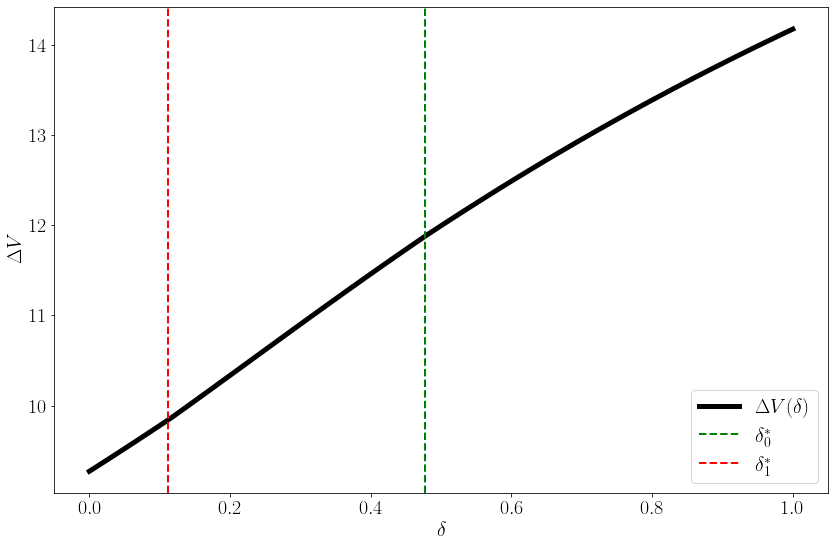

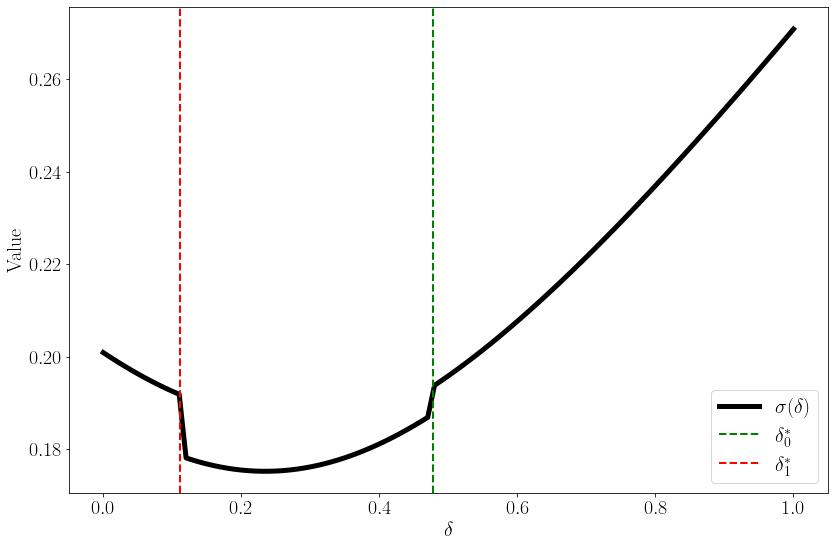

Minimum at 0.23


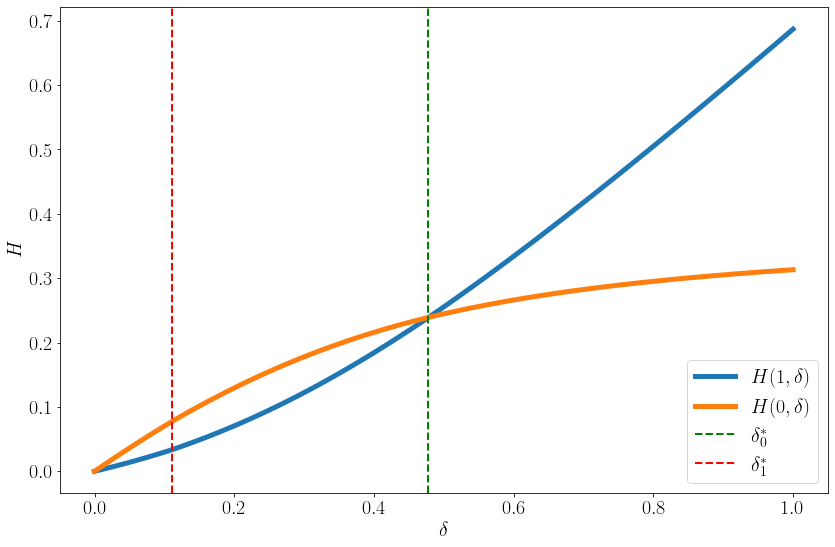

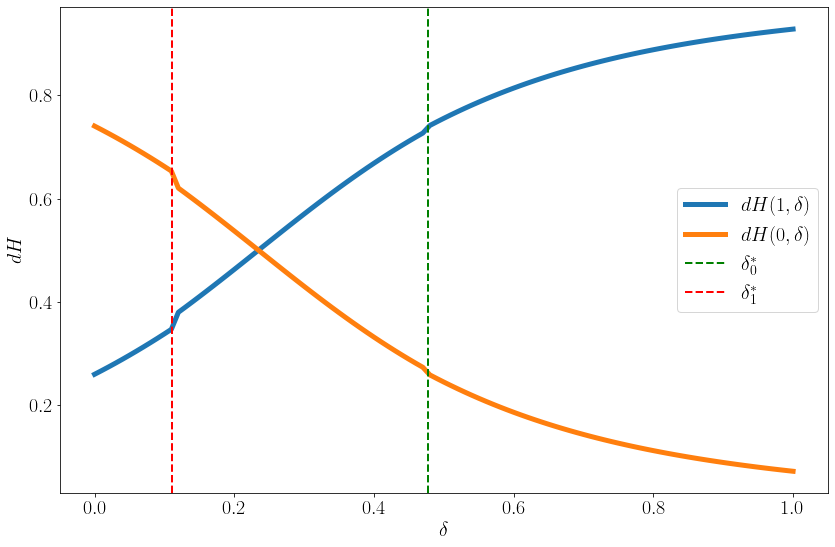

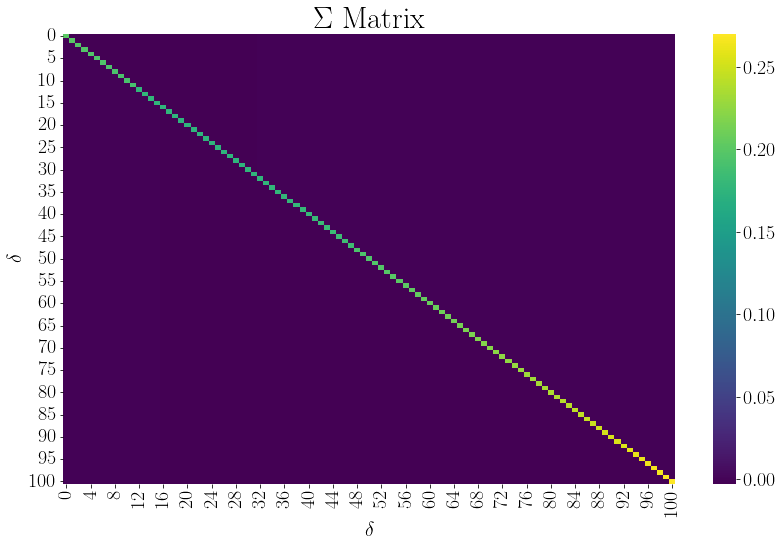

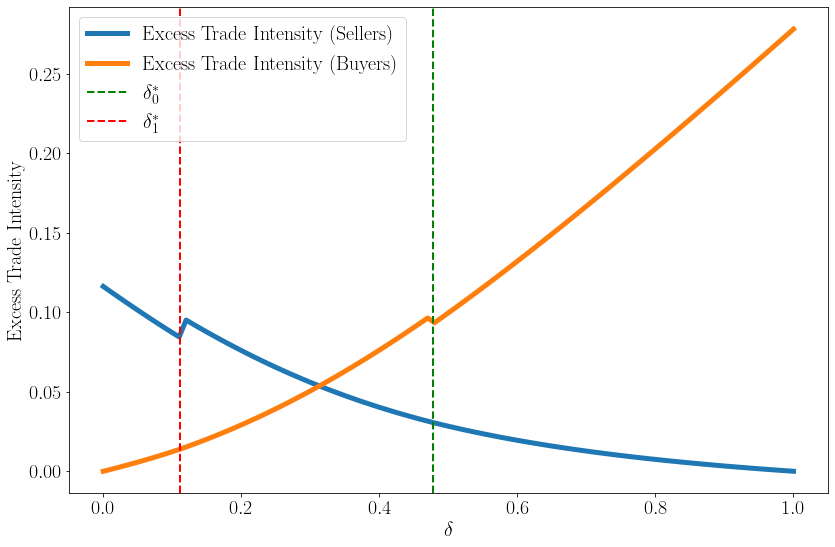

0.47716112847660036 0.11112649047308443


In [647]:
# Find optimal delta_0_star and delta_1_star
#optimal_delta_0_star, optimal_delta_1_star = find_optimal_deltas_iterative(r, gamma, s, f, lambda1, rho, delta_grid, np.random.random(), np.random.random())

# Plot the value and dh functions
plot_value_dh_functions(optimal_delta_0_star, optimal_delta_1_star, r, gamma, s, f, lambda1, rho, delta_grid)

# Print the optimal values
print(optimal_delta_0_star, optimal_delta_1_star)


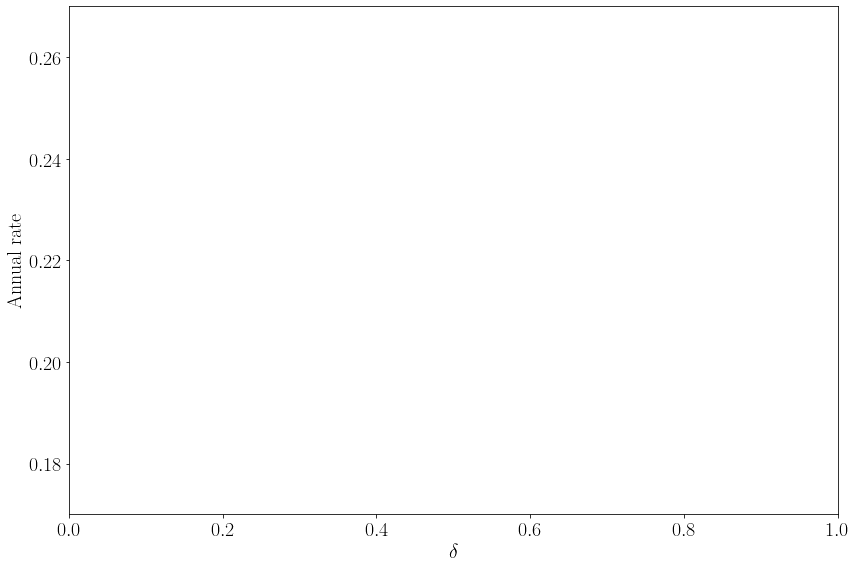

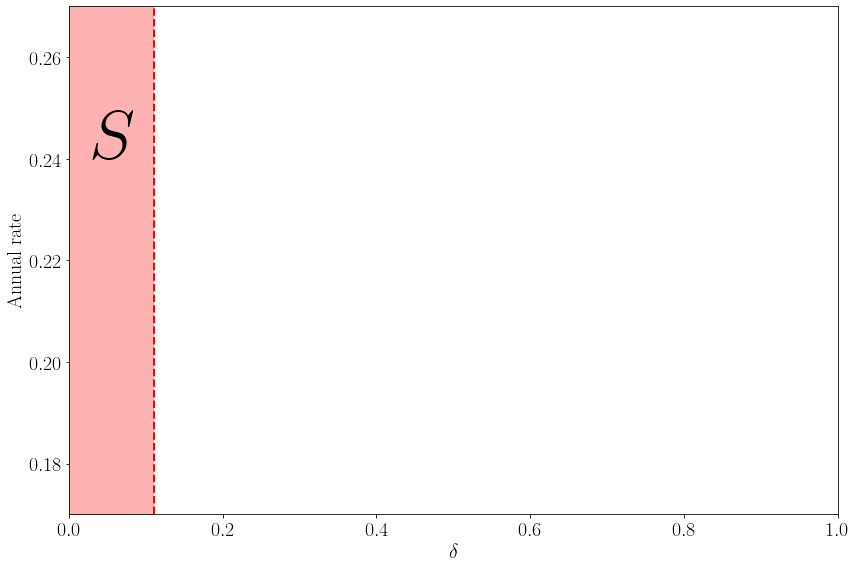

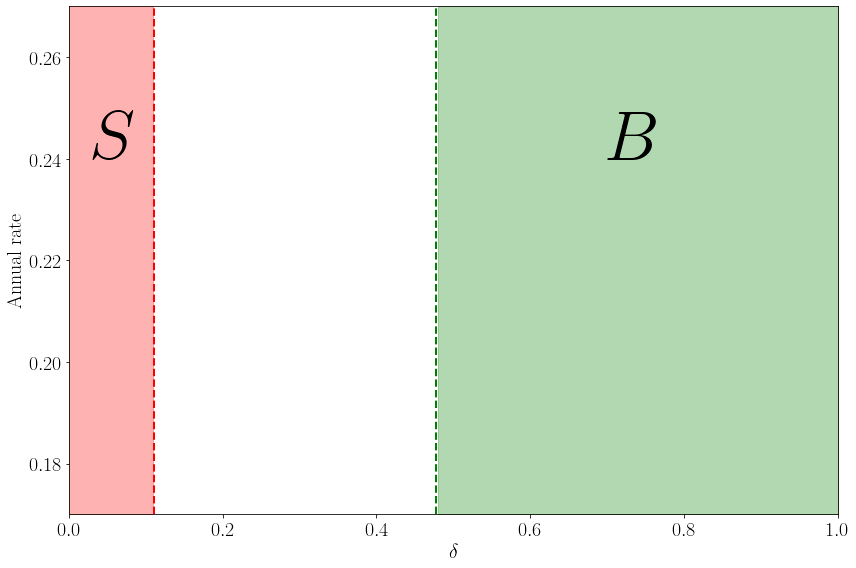

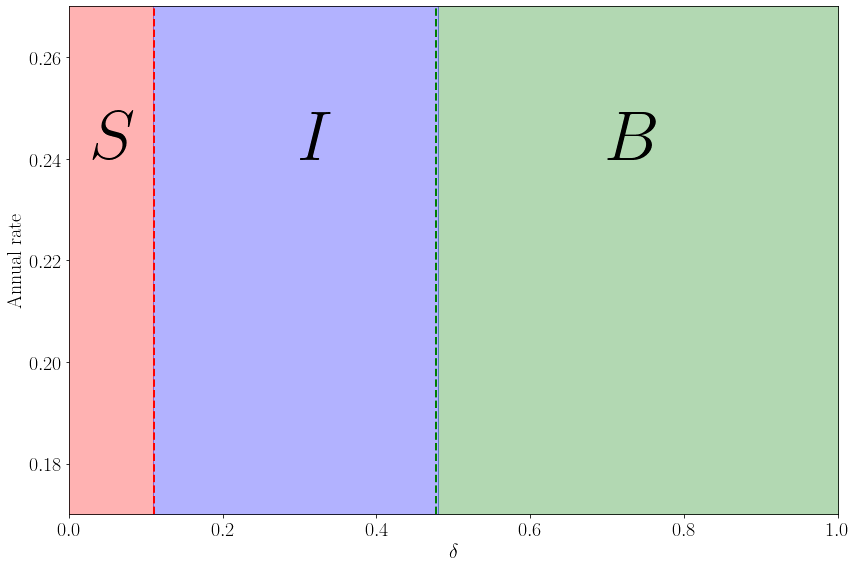

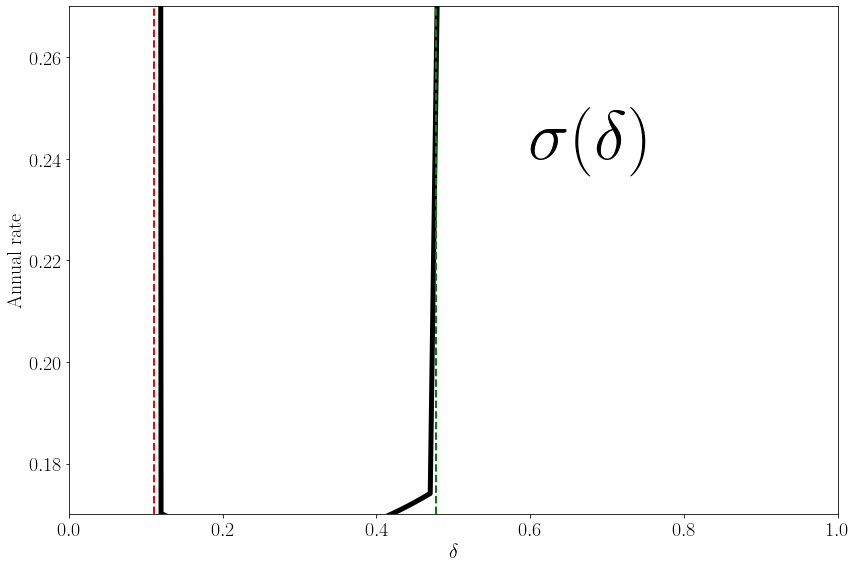

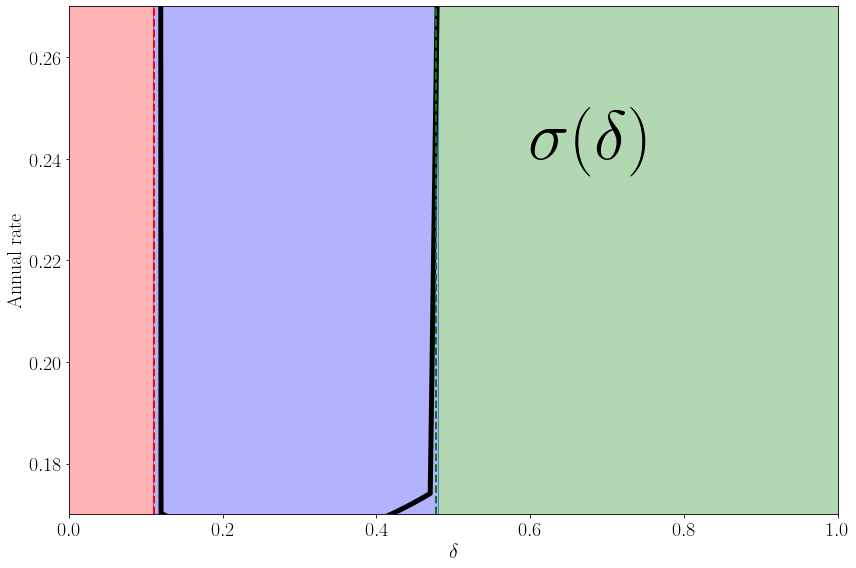

In [682]:
import numpy as np
import matplotlib.pyplot as plt

Sigma_matrix = Sigma(delta_grid, optimal_delta_0_star, optimal_delta_1_star, r, gamma, s, f, lambda1, rho)
    

# Plot 1: No cutoffs, no colors, just the plot of Delta_V
plt.figure(figsize=(12, 8))
plt.ylim(0.17, 0.27)  # Fix y-axis range
plt.xlim(0.0, 1.0)
plt.tight_layout()
plt.xlabel('$\delta$')
plt.ylabel('Annual rate')
plt.savefig('/Users/user/Desktop/Praca/Minnesota season 6/JOB MARKET/codes/plots/BIG_f1a_1.pdf')
plt.show()

# Plot 2: Add delta1 cutoff with transparent bright red color and letter S
plt.figure(figsize=(12, 8))

plt.axvline(x=optimal_delta_1_star, color='red', linestyle='--', linewidth=2)
plt.fill_between(delta_grid, 0.17, 0.27, where=(delta_grid < optimal_delta_1_star), color='red', alpha=0.3)
plt.text(0.03, 0.24, '$S$', fontsize=70, color='black', fontweight='bold')
plt.ylim(0.17, 0.27)
plt.xlim(0.0, 1.0)
plt.tight_layout()
plt.xlabel('$\delta$')
plt.ylabel('Annual rate')
plt.savefig('/Users/user/Desktop/Praca/Minnesota season 6/JOB MARKET/codes/plots/BIG_f1a_2.pdf')
plt.show()

# Plot 3: Add delta0 cutoff with transparent bright green color and letter B
plt.figure(figsize=(12, 8))

plt.axvline(x=optimal_delta_1_star, color='red', linestyle='--', linewidth=2)
plt.axvline(x=optimal_delta_0_star, color='green', linestyle='--', linewidth=2)
plt.fill_between(delta_grid, 0.17, 0.27, where=(delta_grid < optimal_delta_1_star), color='red', alpha=0.3)
plt.fill_between(delta_grid, 0.17, 0.27, where=(delta_grid+0.007 > optimal_delta_0_star), color='green', alpha=0.3)
plt.text(0.03, 0.24, '$S$', fontsize=70, color='black', fontweight='bold')
plt.text(0.7, 0.24, '$B$', fontsize=70, color='black', fontweight='bold')
plt.ylim(0.17, 0.27)
plt.xlim(0.0, 1.0)
plt.tight_layout()
plt.xlabel('$\delta$')
plt.ylabel('Annual rate')
plt.savefig('/Users/user/Desktop/Praca/Minnesota season 6/JOB MARKET/codes/plots/BIG_f1a_3.pdf')
plt.show()

# Plot 4: Add blue shading between delta1 and delta0 and letter I
plt.figure(figsize=(12, 8))

plt.axvline(x=optimal_delta_1_star, color='red', linestyle='--', linewidth=2)
plt.axvline(x=optimal_delta_0_star, color='green', linestyle='--', linewidth=2)
plt.fill_between(delta_grid, 0.17, 0.27, where=(delta_grid < optimal_delta_1_star), color='red', alpha=0.3)
plt.fill_between(delta_grid, 0.17, 0.27, where=(delta_grid+0.007 > optimal_delta_0_star), color='green', alpha=0.3)
plt.fill_between(delta_grid, 0.17, 0.27, where=((delta_grid +0.01> optimal_delta_1_star) & (delta_grid-0.003 < optimal_delta_0_star)), color='blue', alpha=0.3)
plt.text(0.03, 0.24, '$S$', fontsize=70, color='black', fontweight='bold')
plt.text(0.7, 0.24, '$B$', fontsize=70, color='black', fontweight='bold')
plt.text(0.3, 0.24, '$I$', fontsize=70, color='black', fontweight='bold')
plt.ylim(0.17, 0.27)
plt.xlim(0.0, 1.0)
plt.tight_layout()
plt.xlabel('$\delta$')
plt.ylabel('Annual rate')
plt.savefig('/Users/user/Desktop/Praca/Minnesota season 6/JOB MARKET/codes/plots/BIG_f1a_4.pdf')
plt.show()

# Plot 5: Show only cutoffs and Sigma curve with label

plt.figure(figsize=(12, 8))
plt.plot(delta_grid, np.diag(Sigma_matrix), color='black', label='$\sigma(\delta)$',linewidth=5)
plt.axvline(x=optimal_delta_1_star, color='red', linestyle='--', linewidth=2)
plt.axvline(x=optimal_delta_0_star, color='green', linestyle='--', linewidth=2)
plt.text(0.6, 0.24, '$\sigma(\delta)$', fontsize=70, color='black', fontweight='bold')
plt.ylim(0.17, 0.27)
plt.xlim(0.0, 1.0)
plt.tight_layout()
plt.xlabel('$\delta$')
plt.ylabel('Annual rate')
plt.savefig('/Users/user/Desktop/Praca/Minnesota season 6/JOB MARKET/codes/plots/BIG_f1a_5.pdf')
plt.show()


# Plot 6: Everything
plt.figure(figsize=(12, 8))
plt.plot(delta_grid, np.diag(Sigma_matrix), color='black', label='$\sigma(\delta)$',linewidth=5)
plt.axvline(x=optimal_delta_1_star, color='red', linestyle='--', linewidth=2)
plt.axvline(x=optimal_delta_0_star, color='green', linestyle='--', linewidth=2)
plt.fill_between(delta_grid, 0.17, 0.27, where=(delta_grid < optimal_delta_1_star), color='red', alpha=0.3)
plt.fill_between(delta_grid, 0.17, 0.27, where=(delta_grid+0.007 > optimal_delta_0_star), color='green', alpha=0.3)
plt.fill_between(delta_grid, 0.17, 0.27, where=((delta_grid+0.01 > optimal_delta_1_star) & (delta_grid-0.003 < optimal_delta_0_star)), color='blue', alpha=0.3)
plt.text(0.6, 0.24, '$\sigma(\delta)$', fontsize=70, color='black', fontweight='bold')
plt.ylim(0.17, 0.27)
plt.xlim(0.0, 1.0)
plt.tight_layout()
plt.xlabel('$\delta$')
plt.ylabel('Annual rate')
plt.savefig('/Users/user/Desktop/Praca/Minnesota season 6/JOB MARKET/codes/plots/BIG_f1a_6.pdf')
plt.show()


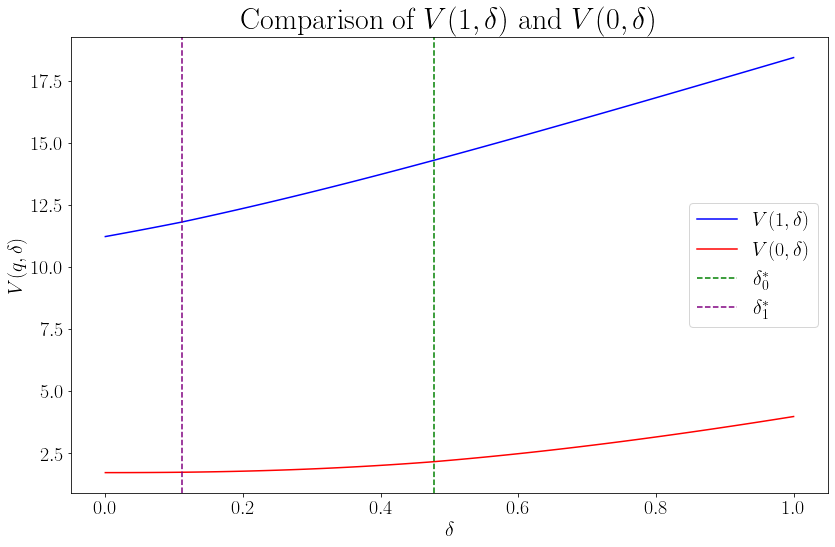

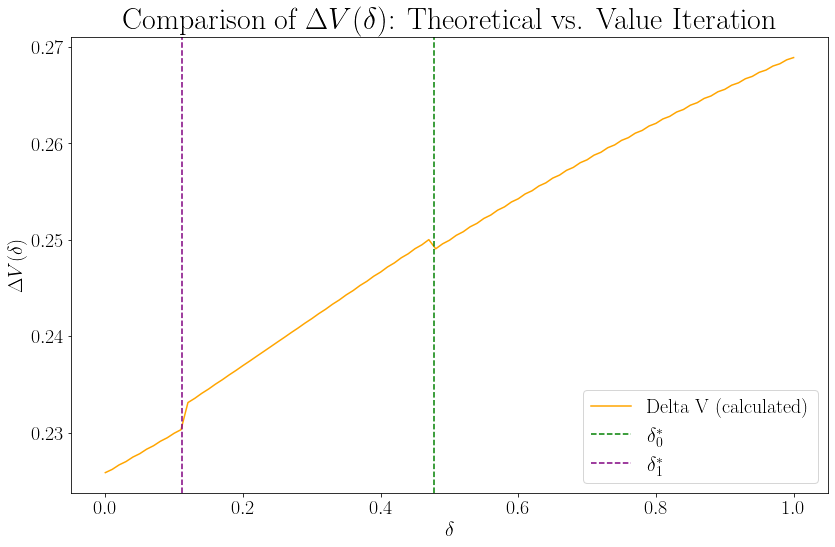

In [620]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import simps
from scipy.interpolate import interp1d

# Define C(1, delta)
def C1(delta, r, gamma, s, f, lambda1, rho, Delta_V_interp, dH0_values, F0_value, delta_1_star, delta_grid):
    integrand_values = (Delta_V_interp(delta_grid) - Delta_V_interp(delta)) * dH0_values
    integrand_values[delta_grid < delta] = 0  # Enforce the integration bounds directly
    integral_term = (rho / 2) * simps(integrand_values, delta_grid)#np.sum(integrand_values) * (delta_grid[1] - delta_grid[0])
    
    max_term = lambda1 * F0_value * max(0, Delta_V_interp(delta_1_star) - Delta_V_interp(delta))
    
    return delta + integral_term + max_term

# Define C(0, delta)
def C0(delta, r, gamma, s, f, lambda1, rho, Delta_V_interp, dH1_values, F1_value, delta_0_star, delta_grid):
    integrand_values = -(Delta_V_interp(delta_grid) - Delta_V_interp(delta)) * dH1_values
    integrand_values[delta_grid > delta] = 0  # Enforce the integration bounds directly
    integral_term = (rho / 2) *simps(integrand_values, delta_grid)# np.sum(integrand_values) * (delta_grid[1] - delta_grid[0])
    
    max_term = lambda1 * F1_value * max(0, -(Delta_V_interp(delta_0_star) - Delta_V_interp(delta)))
    
    return integral_term + max_term

# Integrate C(q, delta') over [0, 1]
def integrate_C(C_values, delta_grid):
    delta_width = delta_grid[1] - delta_grid[0]  # Assuming uniform spacing
    return simps(C_values, delta_grid)#np.sum(C_values) * delta_width


# Compute V(q, delta) and V(0, delta)
def V_q(q, delta, r, gamma, s, f, lambda1, rho, delta_0_star, delta_1_star):
    F1_value = F1(delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho)
    F0_value = f - F1_value
    # Compute H1_values and H0_values as arrays
    H1_values, H0_values = compute_H_values(delta_grid, delta_0_star, delta_1_star, 
                                            r, gamma, s, f, lambda1, rho)

    # Initialize dH0_values and dH1_values as arrays by using the _gen functions
    dH0_values = dH0_gen( delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho)
    dH1_values = dH1_gen( delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho)
    Delta_V, matrix_to_invert = value_iteration(delta_grid, delta_0_star, delta_1_star, 
                                                r, gamma, s, f, lambda1, rho)

    Delta_V_interp = interp1d(delta_grid, Delta_V, kind='linear', fill_value="extrapolate")

     
    if q == 1:
        C_q_delta = C1(delta, r, gamma, s, f, lambda1, rho, Delta_V_interp, dH0_values, F0_value, delta_1_star, delta_grid)
        C_values = [C1(d, r, gamma, s, f, lambda1, rho, Delta_V_interp, dH0_values, F0_value, delta_1_star, delta_grid) for d in delta_grid]
    else:
        C_q_delta = C0(delta, r, gamma, s, f, lambda1, rho, Delta_V_interp, dH1_values, F1_value, delta_0_star, delta_grid)
        C_values = [C0(d, r, gamma, s, f, lambda1, rho, Delta_V_interp, dH1_values, F1_value, delta_0_star, delta_grid) for d in delta_grid]
    
    C_integral = integrate_C(C_values, delta_grid)
    
    V_q_delta = (C_q_delta + (gamma / r) * C_integral) / (r + gamma)
    return V_q_delta

# Compute Delta V(delta) = V(1, delta) - V(0, delta)
def calculate_Delta_V(delta_grid, r, gamma, s, f, lambda1, rho, Delta_V_interp, dH0_values, dH1_values, F0_value, F1_value, delta_0_star, delta_1_star):
    V1_values = np.array([V_q(1, delta, r, gamma, s, f, lambda1, rho, delta_0_star, delta_1_star) for delta in delta_grid])
    V0_values = np.array([V_q(0, delta, r, gamma, s, f, lambda1, rho, delta_0_star, delta_1_star) for delta in delta_grid])
    return V1_values, V0_values, V1_values - V0_values

# Example of usage
def plot_V_q_and_Delta_V(delta_grid, Delta_V, Delta_V_interp, dH0_values, dH1_values, F0_value, F1_value, r, gamma, s, f, lambda1, rho, delta_0_star, delta_1_star):
    V1_values, V0_values, Delta_V_theoretical = calculate_Delta_V(delta_grid, r, gamma, s, f, lambda1, rho, Delta_V_interp, dH0_values, dH1_values, F0_value, F1_value, delta_0_star, delta_1_star)

    # Plot V(q, delta) for q = 1 and q = 0
    plt.figure(figsize=(12, 8))
    plt.plot(delta_grid, V1_values, label="$V(1, \delta)$", linestyle='-', color='blue')
    plt.plot(delta_grid, V0_values, label="$V(0, \delta)$", linestyle='-', color='red')
    plt.axvline(x=delta_0_star, color='green', linestyle='--', label='$\delta_0^*$')
    plt.axvline(x=delta_1_star, color='purple', linestyle='--', label='$\delta_1^*$')
    plt.xlabel(r"$\delta$")
    plt.ylabel(r"$V(q, \delta)$")
    plt.title("Comparison of $V(1, \delta)$ and $V(0, \delta)$")
    plt.legend()
    #plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plotting Delta V(delta) = V(1, delta) - V(0, delta)
    plt.figure(figsize=(12, 8))
    #plt.plot(delta_grid, Delta_V, label="Delta V (solved before)", linestyle='--', color='blue')
    plt.plot(delta_grid, Delta_V_theoretical-Delta_V, label="Delta V (calculated)", linestyle='-', color='orange')
    plt.axvline(x=delta_0_star, color='green', linestyle='--', label='$\delta_0^*$')
    plt.axvline(x=delta_1_star, color='purple', linestyle='--', label='$\delta_1^*$')
    plt.xlabel(r"$\delta$")
    plt.ylabel(r"$\Delta V(\delta)$")
    plt.title("Comparison of $\Delta V(\delta)$: Theoretical vs. Value Iteration")
    plt.legend()
    #plt.grid(True)
    plt.tight_layout()
    plt.show()
F1_value = F1(optimal_delta_0_star, optimal_delta_1_star, r, gamma, s, f, lambda1, rho)
F0_value = f - F1_value
H1_values, H0_values = compute_H_values(delta_grid, optimal_delta_0_star, optimal_delta_1_star, r, gamma, s, f, lambda1, rho)

    # Initialize dH0_values and dH1_values as arrays by using the _gen functions
dH0_values = dH0_gen( optimal_delta_0_star, optimal_delta_1_star, r, gamma, s, f, lambda1, rho)
dH1_values = dH1_gen( optimal_delta_0_star, optimal_delta_1_star, r, gamma, s, f, lambda1, rho)
Delta_V, matrix_to_invert = value_iteration(delta_grid, optimal_delta_0_star, optimal_delta_1_star, r, gamma, s, f, lambda1, rho)

Delta_V_interp = interp1d(delta_grid, Delta_V, kind='linear', fill_value="extrapolate")

plot_V_q_and_Delta_V(delta_grid, Delta_V, Delta_V_interp, dH0_values, dH1_values, F0_value, F1_value, r, gamma, s, f, lambda1, rho, optimal_delta_0_star, optimal_delta_1_star)

In [622]:
V1_values, V0_values, Delta_V_theoretical = calculate_Delta_V(delta_grid, r, gamma, s, f, lambda1, rho, Delta_V_interp, dH0_values, dH1_values, F0_value, F1_value, optimal_delta_0_star, optimal_delta_1_star)




0.3773106946291372
0.02326003920360983
0.400570733832747


In [626]:
dH1_values = dH1_gen(optimal_delta_0_star, optimal_delta_1_star, r, gamma, s, f, lambda1, rho)
dH0_values = dH0_gen( optimal_delta_0_star, optimal_delta_1_star, r, gamma, s, f, lambda1, rho)
print(r*simps(V1_values * dH1_values, delta_grid))
print(r* simps(V0_values * dH0_values, delta_grid))
print( r*simps(V1_values * dH1_values, delta_grid)+r* simps(V0_values * dH0_values, delta_grid))
print( r*np.sum(V1_values * dH1_values)*grid_spacing+r* np.sum(V0_values * dH0_values)*grid_spacing)

0.3773106946291372
0.02326003920360983
0.400570733832747
0.40449253399666635


In [568]:
delta_0_star_initial, delta_1_star_initial =0.6665367571232512, 0.16746163203442446
f=0.0048366897
s = 0.6884162140
r = 0.0361577940
gamma=0.0867540457
rho =0*0.4133277998
lambda1 =3.9750228339
start_time = time.time()
delta_bar = 1
N_points = 101
delta_grid = np.linspace(0, delta_bar, N_points)


optimal_delta_0_star, optimal_delta_1_star = find_optimal_deltas_iterative(r, gamma, s, f, lambda1, rho, delta_grid, 
                                                                           delta_0_star_initial, delta_1_star_initial,
                                                                              tolerance=1e-3)
print("Optimal delta_0_star:", optimal_delta_0_star)
print("Optimal delta_1_star:", optimal_delta_1_star)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Total time for operations: {elapsed_time:.2f} seconds")


Optimal delta_0_star: 0.6665367571232512
Optimal delta_1_star: 0.16746163203442446
Total time for operations: 1.03 seconds


In [562]:
import numpy as np
from scipy.integrate import quadrature
# Convert optimal_delta_0_star and optimal_delta_1_star to indices
optimal_delta_0_index = np.searchsorted(delta_grid, optimal_delta_0_star, side='left')
optimal_delta_1_index = np.searchsorted(delta_grid, optimal_delta_1_star, side='right')



def V1_update(V1_n, delta_grid, optimal_delta_0_index, optimal_delta_1_index, r, gamma, s, f, lambda1, rho, Delta_V, dH0_values):
    N = len(delta_grid)
    V1_next = np.zeros(N)
    grid_spacing = delta_grid[1] - delta_grid[0]  # Spacing of the delta grid
    F1_value = F1(optimal_delta_0_star, optimal_delta_1_star, r, gamma, s, f, lambda1, rho)
    F0_value = f - F1_value

    # Iterate over the delta grid to update V1
    for i, delta in enumerate(delta_grid):
        # First term: delta / (r + gamma)
        V1_next[i] = delta / (r + gamma)

        # Second term: Summation approximation of the integral (normalize with grid spacing)
        sum_integral = simps(V1_n, delta_grid)  # Using Simpson's rule
        V1_next[i] += (gamma / (r + gamma)) * sum_integral

        # Third term: Apply the indicator function and F(0) only if delta < delta_1_star
        if delta < delta_grid[optimal_delta_1_index]:
            V1_next[i] += (lambda1 / (r + gamma)) * F0_value * (Delta_V[optimal_delta_1_index] - Delta_V[i])

        # Fourth term: Numerical approximation of the integral involving dH0 using Simpson's rule
        
            # Correct the integral form: rho/(r+gamma) * sum_j=i+1 (Delta_V(delta_j) - Delta_V(delta_i)) * dH0(delta_j)
        integral_term = 0
        for j in range(i + 1, N):
            integral_term += (Delta_V[j] - Delta_V[i]) * dH0_values[j]*grid_spacing 
        V1_next[i] += 0.5*(rho / (r + gamma)) * integral_term

    return V1_next

def V0_update(V0_n, delta_grid, optimal_delta_0_index, optimal_delta_1_index, r, gamma, s, f, lambda1, rho, Delta_V, dH1_values):
    N = len(delta_grid)
    V0_next = np.zeros(N)
    grid_spacing = delta_grid[1] - delta_grid[0]

    F1_value = F1(optimal_delta_0_star, optimal_delta_1_star, r, gamma, s, f, lambda1, rho)
    F0_value = f - F1_value
    
    # Iterate over the delta grid to update V0
    for i, delta in enumerate(delta_grid):
        # First term: Summation approximation (normalize with grid spacing)
        sum_integral = simps(V0_n, delta_grid)  # Using Simpson's rule
        V0_next[i] = (gamma / (r + gamma)) * sum_integral

        # Second term: Apply the indicator function and F(1) only if delta > delta_0_star
        if delta > delta_grid[optimal_delta_0_index]:
            V0_next[i] += (lambda1 / (r + gamma)) * F1_value * (Delta_V[i] - Delta_V[optimal_delta_0_index])

        # Third term: Numerical approximation of the integral involving dH1 using Simpson's rule
        
        integral_term = 0
        for j in range(0, i):
            integral_term += (Delta_V[j] - Delta_V[i]) * dH1_values[j]*grid_spacing
        V0_next[i] += -0.5*(rho / (r + gamma)) * integral_term

    return V0_next





# Value function iteration
def value_function_iteration_new(delta_grid, optimal_delta_0_star, optimal_delta_1_star, r, gamma, 
                                 s, f, lambda1, rho, max_iterations=3000, tolerance=1e-20):
    N = len(delta_grid)
    
    # Convert optimal_delta_*_star to indices
    optimal_delta_0_index = np.argmin(np.abs(delta_grid - optimal_delta_0_star))
    optimal_delta_1_index = np.argmin(np.abs(delta_grid - optimal_delta_1_star))
    
    
    
    # Use the value_iteration to get Delta_V and dH values
    Delta_V, _ = value_iteration(delta_grid, optimal_delta_0_star, optimal_delta_1_star, r, gamma, s, f, lambda1, rho)
    dH0_values = dH0_gen(optimal_delta_0_star, optimal_delta_1_star, r, gamma, s, f, lambda1, rho)
    dH1_values = dH1_gen(optimal_delta_0_star, optimal_delta_1_star, r, gamma, s, f, lambda1, rho)
    # Initial guesses for V^n(1, delta) and V^n(0, delta)
    V1_n = delta_grid / (r + gamma)
    V0_n = delta_grid / (r + gamma)
    for iteration in range(max_iterations):
        # Update V1 and V0 using the update functions
        V1_next = V1_update(V1_n, delta_grid, optimal_delta_0_index, optimal_delta_1_index, r, gamma, s, f, lambda1, rho, Delta_V, dH0_values)
        V0_next = V0_update(V0_n, delta_grid, optimal_delta_0_index, optimal_delta_1_index, r, gamma, s, f, lambda1, rho, Delta_V, dH1_values)

        # Check for convergence
        diff_V1 = np.max(np.abs(V1_next - V1_n))
        diff_V0 = np.max(np.abs(V0_next - V0_n))
        if diff_V1 < tolerance and diff_V0 < tolerance:
            print(f"Converged in {iteration} iterations")
            break

        # Update V1_n and V0_n for the next iteration
        V1_n = V1_next
        V0_n = V0_next

    return V1_next, V0_next

import matplotlib.pyplot as plt

def plot_difference(delta_grid, Delta_V, V1_next, V0_next):
    difference = Delta_V - V1_next + V0_next

    plt.figure(figsize=(12, 8))
    plt.plot(delta_grid, difference, label="Difference ($\Delta V(\delta) - (V(1,\delta) - V(0,\delta))$", color="orange")
    #plt.plot(delta_grid, Delta_V, label="($\Delta V(\delta) )$", color="red")
    #plt.plot(delta_grid, V1_next - V0_next, label="Difference ($ (V(1,\delta) - V(0,\delta))$", color="blue")
    
    plt.xlabel('$\delta$')
    plt.ylabel('Difference')
    #plt.title('Difference between $\Delta V(\delta)$ and $V(1,\delta) - V(0,\delta)$')
    plt.legend()
    plt.grid(True)
    plt.show()

In [617]:
# Run the value function iteration
V1_final, V0_final = value_function_iteration_new(delta_grid, optimal_delta_0_star, optimal_delta_1_star, r, gamma, 
                                 s, f, lambda1, rho, max_iterations=300, tolerance=1e-10)
  

# Get Delta_V from value_iteration for comparison
Delta_V, matrix_to_invert = value_iteration(delta_grid, delta_0_star_initial, delta_1_star_initial, r, gamma, s, f, lambda1, rho)

# Plot the difference between Delta_V and (V1 - V0)
plot_difference(delta_grid, Delta_V, V1_final, V0_final)
print("Shapes of Delta_V, V1_final, V0_final:", Delta_V.shape, V1_final.shape, V0_final.shape)
# Calculate absolute error
error = np.max(np.abs(Delta_V - (V1_final - V0_final)))
print("Absolute error:", error)
print(Delta_V - V1_final + V0_final)

TypeError: unsupported operand type(s) for -: '_io.TextIOWrapper' and '_io.TextIOWrapper'

In [380]:
delta_0_star_initial, delta_1_star_initial =0.6669796057594066, 0.16707332172447217
f=0.0048366897
s = 0.6884162140
r = 0.0361577940
gamma=0.0867540457
rho =0*0.4133277998
lambda1 =3.9750228339
start_time = time.time()


optimal_delta_0_star, optimal_delta_1_star = find_optimal_deltas_iterative(r, gamma, s, f, lambda1, rho, delta_grid, 
                                                                           delta_0_star_initial, delta_1_star_initial,
                                                                              tolerance=1e-4)
print("Optimal delta_0_star:", optimal_delta_0_star)
print("Optimal delta_1_star:", optimal_delta_1_star)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Total time for operations: {elapsed_time:.2f} seconds")


Optimal delta_0_star: 0.6669796057594066
Optimal delta_1_star: 0.16707332172447217
Total time for operations: 1.15 seconds


In [92]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# Calculate trade volume among households (kappa1)
def trade_hh(r, gamma, s, f, lambda1, rho, dH0_values, dH1_values):
    # Indicator matrix for delta_prime >= delta
    Indicator_matrix = np.less_equal.outer(delta_grid, delta_grid).astype(float)
    
    # Compute kappa1 with grid spacing included
    kappa_13 = rho * np.sum(dH1_values @ Indicator_matrix @ dH0_values.T) * grid_spacing**2
    return kappa_13

# Calculate trade volume involving flippers (kappa2)
def trade_flipper(r, gamma, s, f, lambda1, rho, delta_0_star, delta_1_star):
    F0_value = F0(delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho)
    #H1_delta1 = dH1(delta_1_star, delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho)
    H1_delta1 = H1(delta_1_star, delta_0_star, delta_1_star, F1(delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho), r, gamma, s, f, lambda1, rho)

    # Compute kappa2
    kappa_23 = 2*lambda1 * F0_value * H1_delta1
    return kappa_23

# Compute total trade volume kappa
def trade_volume(r, gamma, s, f, lambda1, rho, dH0_values, dH1_values, delta_0_star, delta_1_star):
    kappa13 = trade_hh(r, gamma, s, f, lambda1, rho, dH0_values, dH1_values)
    kappa23 = trade_flipper(r, gamma, s, f, lambda1, rho, delta_0_star, delta_1_star)
    kappa3 = kappa13 + kappa23
    return kappa3, kappa13, kappa23

Trade Volume kappa: 0.021857241567959283, kappa1 (households): 0.020968522999462294, kappa2 (flippers): 0.0008887185684969904
Fraction of flipper trade kappa2/kappa: 0.040660143034689726
P1,P0, P1-P0 11.876109404021602 9.83633276146372 2.0397766425578823
Computed Mean of P: 11.597235644473946
Computed Variance of P: 1.2162488012956936
Computed Skewness of P: 0.0515746447045835
P80/P20: 1.1987208477121427


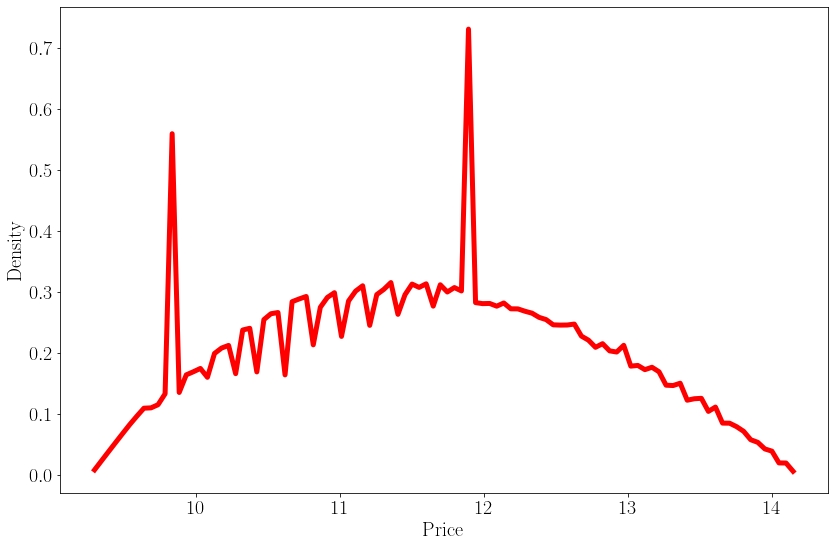

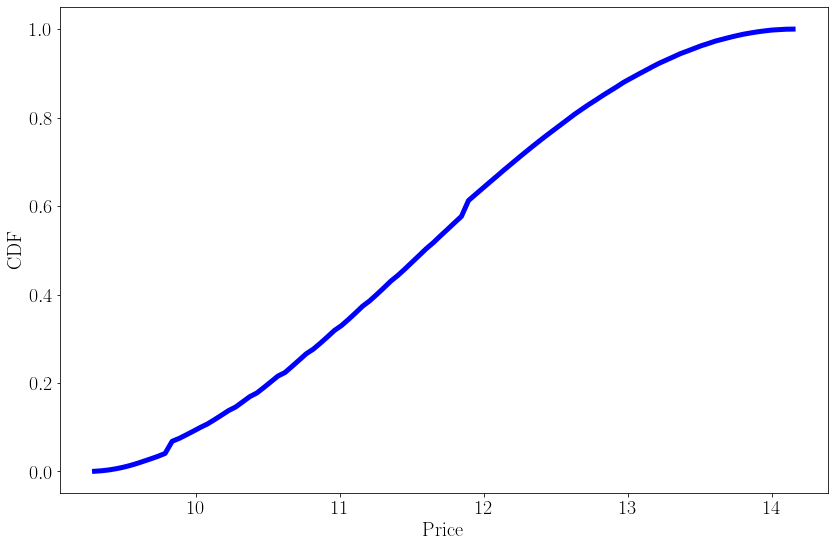

In [126]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# Function to compute P_mean and P_variance
def compute_P_mean_variance(p_values, F_P):
    # Compute the PDF using finite differences
    delta_p = p_values[1] - p_values[0]
    f_P = np.diff(F_P) / np.diff(p_values)
    
    # Normalize the PDF
    f_P_sum = np.sum(f_P) * delta_p
    f_P = f_P / f_P_sum
    p_values_mid = (p_values[:-1] + p_values[1:]) / 2  # Midpoints for plotting PDF

    # Compute the mean and variance using the PDF
    P_mean = np.sum(p_values_mid * f_P) * delta_p
    P_variance = np.sum((p_values_mid - P_mean) ** 2 * f_P) * delta_p

    return P_mean, P_variance


# Function to compute skewness
def compute_skewness(p_values_mid, f_P, P_mean, P_variance):
    # Skewness is the third standardized moment
    delta_p = p_values_mid[1] - p_values_mid[0]
    P_skewness = np.sum(((p_values_mid - P_mean) ** 3) * f_P) * delta_p / (P_variance ** 1.5)
    return P_skewness

# Function to calculate percentiles
def compute_percentile(cdf_values, p_values, target):
    if target <= cdf_values[0]:
        return p_values[0]
    elif target >= cdf_values[-1]:
        return p_values[-1]
    else:
        return interp1d(cdf_values, p_values, fill_value="extrapolate")(target)

# Calculate price distribution (CDF)
def price_distribution(r, gamma, s, f, lambda1, rho, Delta_V_interp, 
                       dH0_values, dH1_values, kappa1, kappa2, 
                       delta_0_star, delta_1_star):

    # Find the indices on delta_grid corresponding to delta_0_star and delta_1_star
    #delta_0_idx = np.searchsorted(delta_grid, delta_0_star)
    #delta_0_idx = int(delta_0_idx)
    #delta_1_idx = np.searchsorted(delta_grid, delta_1_star)
    #delta_1_idx = int(np.floor(delta_1_idx))  # Ensure it is an integer index

    F1_val = F1(delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho)
    F0_val = f - F1_val
    # Define price grid
    p_values = np.linspace(np.min(Delta_V_interp(delta_grid)), np.max(Delta_V_interp(delta_grid)), len(delta_grid))
    
    # Create price matrix P(delta, delta_prime)
    P_matrix = np.array([[P(delta, delta_prime, Delta_V_interp) for delta_prime in delta_grid] for delta in delta_grid])
    
    # Initialize CDF array
    F_P = np.zeros(len(p_values))
    
    # Calculate the CDF
    for k, p in enumerate(p_values):
        # Indicator matrix for P(delta, delta_prime) <= p
        I_p = (P_matrix <= p).astype(float)
        
        # Apply both indicators 1_{\delta' > \delta} and 1_{P(\delta, \delta') <= p}
        I_delta_prime_greater_delta = np.triu(np.ones_like(P_matrix), 1)  # Upper triangular matrix to enforce \delta' > \delta
        I_combined = I_p  * I_delta_prime_greater_delta
        
        # Double integral for the CDF (first term)
        integral_double = grid_spacing**2 * np.sum(dH1_values @ I_combined @ dH0_values.T)
        
        # Marginal contributions from P0 and P1 (second and third terms)
        if P0(Delta_V_interp, delta_1_star) <= p:
            integral_P0 = kappa2/2
            #H1(optimal_delta_1_star, optimal_delta_0_star, optimal_delta_1_star, F1_val, r,gamma, s, f, lambda1, rho) * F0_val
      
        else:
            integral_P0 = 0
        
        if P1(Delta_V_interp, delta_0_star) <= p:
            integral_P1 = kappa2/2
            #H0(optimal_delta_0_star, optimal_delta_0_star, optimal_delta_1_star, F1_val, r, gamma, s, f, lambda1, rho) * F1_val
       
        else:
            integral_P1 = 0
        
        # Combine into CDF value, scaled by appropriate factors
        #F_P[k] = (integral_double *rho / kappa1) + (integral_P0 * lambda1*F0_val*2/kappa2) + (integral_P1 * lambda1*F1_val*2/kappa2)
        #F_P[k] = integral_double*rho/(kappa1 +kappa2)  + integral_P0*kappa2/(2*(kappa1 +kappa2))  + integral_P1 *kappa2/(2*(kappa1 +kappa2)) 
        F_P[k] = (integral_double*rho+integral_P0+ integral_P1 )/(kappa1 +kappa2) 
    
    delta_p = p_values[1] - p_values[0]
    
    
    # Normalize the CDF
    F_P_sum = np.sum(F_P) * delta_p
    F_P = F_P / F_P_sum
    return p_values, F_P

# Plot price distribution
# Plot price distribution
def plot_price_distribution(p_values, F_P):
        # Compute the PDF using finite differences
    delta_p = p_values[1] - p_values[0]
    f_P = np.diff(F_P) / np.diff(p_values)
    
    # Normalize the PDF
    f_P_sum = np.sum(f_P) * delta_p
    f_P = f_P / f_P_sum
    p_values_mid = (p_values[:-1] + p_values[1:]) / 2  # Midpoints for plotting PDF

    # Compute the mean, variance, and skewness using the compute_P_mean_variance function
    P_mean, P_variance = compute_P_mean_variance(p_values, F_P)
    P_skewness = compute_skewness(p_values_mid, f_P, P_mean, P_variance)

    # Normalize the CDF
    cdf_values = np.cumsum(f_P) * (p_values_mid[1] - p_values_mid[0])
    
    # Calculate P80/P20 ratio
    p80 = compute_percentile(cdf_values, p_values_mid, 0.80)
    p20 = compute_percentile(cdf_values, p_values_mid, 0.20)
    P80_P20 = p80 / p20
    print(f"P80/P20: {P80_P20}")

    # Define output paths
    output_path_pdf = "/Users/user/Desktop/Praca/Minnesota season 6/JOB MARKET/codes/plots/Price_pdf.pdf"
    output_path_cdf = "/Users/user/Desktop/Praca/Minnesota season 6/JOB MARKET/codes/plots/Price_cdf.pdf"

    # Plot the PDF of prices
    plt.figure(figsize=(12, 8))
    plt.plot(p_values_mid, f_P, color='red', linewidth=5)
    plt.xlabel('Price')
    plt.ylabel('Density')
    #plt.title('PDF of Price Distribution')
    #plt.grid(True)
    plt.tight_layout()
    plt.savefig(output_path_pdf)
    plt.show()

    # Plot the CDF of prices
    plt.figure(figsize=(12, 8))
    plt.plot(p_values_mid, cdf_values, color='blue', linewidth=5)
    plt.xlabel('Price')
    plt.ylabel('CDF')
    #plt.title('CDF of Price Distribution')
    #plt.grid(True)
    plt.tight_layout()
    plt.savefig(output_path_cdf)
    plt.show()


# Example usage with the updated functions
# Assuming other necessary variables are already defined: delta_grid, optimal_delta_0_star, optimal_delta_1_star, etc.

# Running value iteration to get Delta_V
Delta_V, _ = value_iteration(delta_grid, optimal_delta_0_star, optimal_delta_1_star, r, gamma, s, f, lambda1, rho)

# Interpolating Delta_V
Delta_V_interp = interp1d(delta_grid, Delta_V, kind='linear', fill_value="extrapolate")

# Calculate dH0 and dH1 values
H_values = compute_H_values(delta_grid, optimal_delta_0_star, optimal_delta_1_star, r, gamma, s, f, lambda1, rho)
dH0_values = dH0_gen(optimal_delta_0_star, optimal_delta_1_star, r, gamma, s, f, lambda1, rho)
dH1_values = dH1_gen(optimal_delta_0_star, optimal_delta_1_star, r, gamma, s, f, lambda1, rho)

# Compute trade volumes
grid_spacing = delta_grid[1] - delta_grid[0]
kappa, kappa1, kappa2 = trade_volume(r, gamma, s, f, lambda1, rho, dH0_values, dH1_values, 
                                     optimal_delta_0_star, optimal_delta_1_star)
print(f"Trade Volume kappa: {kappa}, kappa1 (households): {kappa1}, kappa2 (flippers): {kappa2}")
print(f"Fraction of flipper trade kappa2/kappa: {kappa2/kappa}")

print("P1,P0, P1-P0", P1(Delta_V_interp, optimal_delta_0_star), P0(Delta_V_interp, optimal_delta_1_star), P1(Delta_V_interp, optimal_delta_0_star) - P0(Delta_V_interp, optimal_delta_1_star))

# Calculate price distribution (CDF)
p_values, F_P = price_distribution(r, gamma, s, f, lambda1, rho, Delta_V_interp,dH0_values, dH1_values, kappa1, kappa2,optimal_delta_0_star, optimal_delta_1_star)
# Calculate PDF using finite differences
delta_p = p_values[1] - p_values[0]
f_P = np.diff(F_P) / np.diff(p_values)

# Normalize the PDF
f_P_sum = np.sum(f_P) * delta_p
f_P = f_P / f_P_sum
p_values_mid = (p_values[:-1] + p_values[1:]) / 2  # Midpoints for plotting PDF

# Compute mean, variance, and skewness
P_mean, P_variance= compute_P_mean_variance(p_values, F_P)
P_skewness = compute_skewness(p_values_mid, f_P, P_mean, P_variance)
print(f"Computed Mean of P: {P_mean}")
print(f"Computed Variance of P: {P_variance}")
print(f"Computed Skewness of P: {P_skewness}")

# Plot price distribution (PDF and CDF)
plot_price_distribution(p_values, F_P)

In [140]:
from scipy.interpolate import interp1d


[10.03464082 10.51142098 10.89945941 11.25621281 11.58869553 11.87662414
 12.20833923 12.60025947 13.08525672]


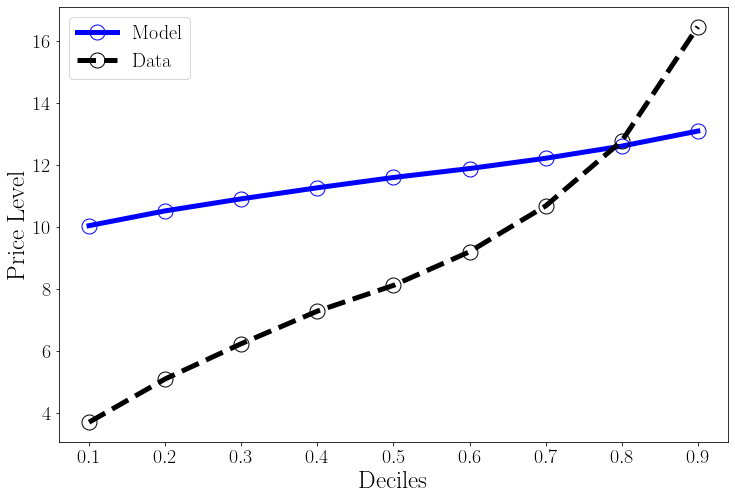

In [244]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# Load the Excel file with decile data
deciles_data_path = "/Users/user/Desktop/Praca/Minnesota season 6/JOB MARKET/data/irish data/plots/deciles_prices.xlsx"
deciles_data = pd.read_excel(deciles_data_path)

# Extract decile values from the dataframe (these are the actual data deciles)
deciles_prices = deciles_data.iloc[0].values  # Get the first row (decile values)
data_deciles = np.linspace(0.1, 0.9, len(deciles_prices))  # Decile targets (10%, 20%, ..., 90%)


# Assuming you've already calculated the CDF (F_P) and price midpoints (p_values_mid)
# Define decile targets (0.1, 0.2, ..., 0.9)
decile_targets = np.linspace(0.1, 0.9, 9)

# Calculate the CDF using your PDF and price midpoints
cdf_values = np.cumsum(f_P) * (p_values_mid[1] - p_values_mid[0])

# Interpolate the price values corresponding to the decile points in the CDF
cdf_interpolator = interp1d(cdf_values, p_values_mid, fill_value="extrapolate")
model_deciles = cdf_interpolator(decile_targets)

# Plot the deciles: Model vs Data
plt.figure(figsize=(12, 8))

# Plot model deciles with blue line and empty circle markers
plt.plot(decile_targets, model_deciles, 'bo-', label='Model ', linewidth=5, markersize=15, markerfacecolor='none')

# Plot data deciles with black dotted line and empty circle markers
plt.plot(data_deciles, deciles_prices, 'ko--', label='Data ', linewidth=5, markersize=15, markerfacecolor='none')

# Add labels and title
plt.xlabel('Deciles', fontsize=25)
plt.ylabel('Price Level', fontsize=25)
#plt.title('Comparison of Model and Data Deciles', fontsize=16)

# Add grid, legend, and display the plot
#plt.grid(True)
plt.legend(loc='upper left', fontsize=20)
output_path = "/Users/user/Desktop/Praca/Minnesota season 6/JOB MARKET/codes/plots/BIGmodel_data.pdf"
plt.savefig(output_path)
# Show the plot
plt.show()


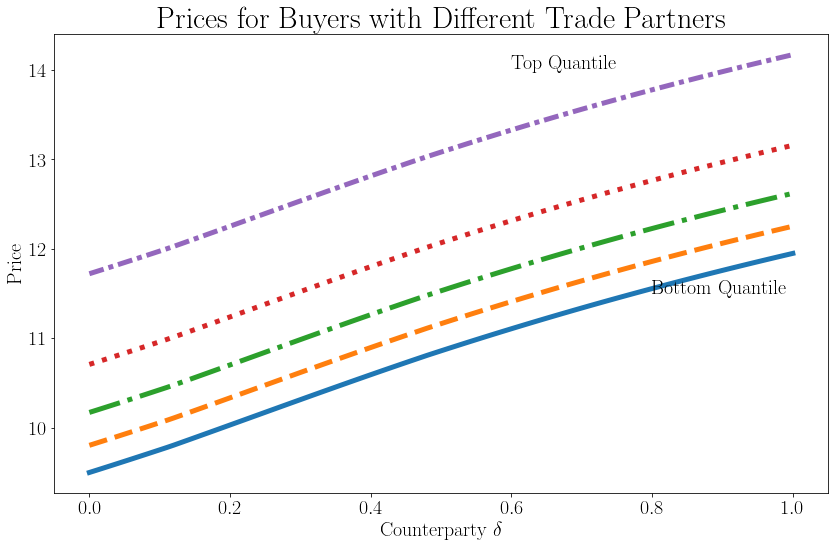

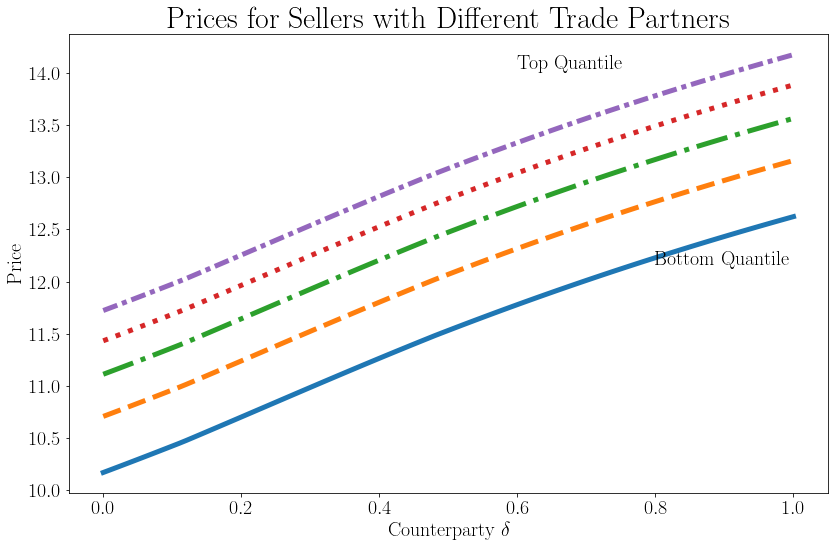

In [94]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

def plot_prices(delta_grid, optimal_delta_0_star, optimal_delta_1_star, r, gamma, s, f, lambda1, rho):
    """Plot prices for buyers and sellers with respect to different trade partners based on delta quantiles."""

    # Calculate the value function interpolation
    Delta_V, _ = value_iteration(delta_grid, optimal_delta_0_star, optimal_delta_1_star, r, gamma, s, f, lambda1, rho)
    Delta_V_interp = interp1d(delta_grid, Delta_V, kind='linear', fill_value="extrapolate")

    # Calculate F1 used in H0 and H1 functions
    F1_value = F1(optimal_delta_0_star, optimal_delta_1_star, r, gamma, s, f, lambda1, rho)
    
    # Calculate H0 and H1 values element-wise
    H0_values = np.array([H0(delta, optimal_delta_0_star, optimal_delta_1_star, F1_value, r, gamma, s, f, lambda1, rho) for delta in delta_grid])
    H1_values = np.array([H1(delta, optimal_delta_0_star, optimal_delta_1_star, F1_value, r, gamma, s, f, lambda1, rho) for delta in delta_grid])

    # Normalizing quantile points
    H0_max = H0(1.0, optimal_delta_0_star, optimal_delta_1_star, F1_value, r, gamma, s, f, lambda1, rho)
    H1_max = H1(1.0, optimal_delta_0_star, optimal_delta_1_star, F1_value, r, gamma, s, f, lambda1, rho)

    quantiles = [0.2, 0.4, 0.6, 0.8, 1.0]
    
    # Calculate quantiles for buyers (non-owners)
    buyer_deltas_quantiles = [delta_grid[min(np.searchsorted(H0_values, q * H0_max), len(delta_grid) - 1)] for q in quantiles]

    # Calculate quantiles for sellers (owners)
    seller_deltas_quantiles = [delta_grid[min(np.searchsorted(H1_values, q * H1_max), len(delta_grid) - 1)] for q in quantiles]
    
    # Generate a range of counterparty deltas for plotting
    counterparty_deltas = delta_grid
    
    # Plot prices for buyers meeting different households
    plt.figure(figsize=(12, 8))
    for i, delta_buyer in enumerate(buyer_deltas_quantiles):
        prices = [0.5 * Delta_V_interp(delta_buyer) + 0.5 * Delta_V_interp(delta_seller) for delta_seller in counterparty_deltas]
        plt.plot(counterparty_deltas, prices, linewidth=5,linestyle=['-', '--', '-.', ':', (0, (3, 1, 1, 1))][i])

        # Add text annotations for the top and bottom quantiles
        if i == 0:
            plt.text(counterparty_deltas[-1]-0.2, prices[-1]-0.5, 'Bottom Quantile', color='black', fontsize=20, verticalalignment='bottom')
        elif i == len(buyer_deltas_quantiles) - 1:
            plt.text(counterparty_deltas[-1]-0.4, prices[-1], 'Top Quantile', color='black', fontsize=20, verticalalignment='top')

    plt.title('Prices for Buyers with Different Trade Partners')
    plt.xlabel('Counterparty $\delta$')
    plt.ylabel('Price')
    #plt.grid(True)
    plt.tight_layout()
    plt.savefig("/Users/user/Desktop/Praca/Minnesota season 6/JOB MARKET/codes/plots/BIG_price_b.pdf")
    plt.show()
    
    # Plot prices for sellers meeting different households
    plt.figure(figsize=(12, 8))
    for i, delta_seller in enumerate(seller_deltas_quantiles):
        prices = [0.5 * Delta_V_interp(delta_buyer) + 0.5 * Delta_V_interp(delta_seller) for delta_buyer in counterparty_deltas]
        plt.plot(counterparty_deltas, prices, linewidth=5,linestyle=['-', '--', '-.', ':', (0, (3, 1, 1, 1))][i])

        # Add text annotations for the top and bottom quantiles
        if i == 0:
            plt.text(counterparty_deltas[-1]-0.2, prices[-1]-0.5, 'Bottom Quantile', color='black', fontsize=20, verticalalignment='bottom')
        elif i == len(seller_deltas_quantiles) - 1:
            plt.text(counterparty_deltas[-1]-0.4, prices[-1], 'Top Quantile', color='black', fontsize=20, verticalalignment='top')

    plt.title('Prices for Sellers with Different Trade Partners')
    plt.xlabel('Counterparty $\delta$')
    plt.ylabel('Price')
    #plt.grid(True)
    plt.tight_layout()
    plt.savefig("/Users/user/Desktop/Praca/Minnesota season 6/JOB MARKET/codes/plots/BIG_price_s.pdf")
    plt.show()

# Call the function to plot
plot_prices(delta_grid, optimal_delta_0_star, optimal_delta_1_star, r, gamma, s, f, lambda1, rho)


## Simulation

In [95]:
from scipy.stats import skew
import pandas as pd
import statsmodels.api as sm

def simulate_model(delta_grid, optimal_delta_0_star, optimal_delta_1_star, r, gamma, s, f, lambda1, rho, T, N):
    # Interpolation for value function
    Delta_V, _ = value_iteration(delta_grid, optimal_delta_0_star, optimal_delta_1_star, r, gamma, s, f, lambda1, rho)
    Delta_V_interp = interp1d(delta_grid, Delta_V, kind='linear', fill_value="extrapolate")

    # Initialize arrays to store statistics
    prices = []
    average_prices_per_period = []  # To store average prices for each period
    household_trades = []
    flipper_trades = []
    ownership_status = np.random.binomial(1, s - F1(optimal_delta_0_star, optimal_delta_1_star, r, gamma, s, f, lambda1, rho), N)
    deltas = np.random.uniform(0, 1, N)
    delta_history = np.zeros((N, T))  # To store history of delta values for each agent
    ownership_history = np.zeros((N, T))  # To store history of ownership status for each agent
    trade_history = []  # To store trade events details: (t, buyer_index, seller_index, type_of_trade)
    holding_durations = np.zeros(N)
    last_period_prices = []  # Initialize to store prices from the last period

    # Run simulation
    for t in range(T):
        new_ownership_status = ownership_status.copy()
        new_deltas = deltas.copy()
        period_prices = []
        num_household_trades = 0
        num_flipper_trades = 0

        for i in range(N):
            random_val = np.random.uniform(0, 1)

            if ownership_status[i] == 0:  # Non-owner
                # Step (a) Draw delta' and decide if trade happens
                delta_prime = np.random.uniform(0, 1)
                if delta_prime < deltas[i]:
                    prob_meet_household = rho * H1(
                        deltas[i], optimal_delta_0_star, optimal_delta_1_star, 
                        F1(optimal_delta_0_star, optimal_delta_1_star, r, gamma, s, f, lambda1, rho),
                        r, gamma, s, f, lambda1, rho
                    )
                else:
                    prob_meet_household = 0  # No trade if delta' >= delta

                # Step (b) Meeting flipper
                if deltas[i] > optimal_delta_0_star:
                    prob_meet_flipper = lambda1 * F1(optimal_delta_0_star, optimal_delta_1_star, r, gamma, s, f, lambda1, rho)
                else:
                    prob_meet_flipper = 0  # No meeting with flipper if delta <= delta_0_star
                
                # Step (c) Shock to delta
                prob_shock = gamma

                # Normalize probabilities to ensure at most one event
                total_prob = prob_meet_household + prob_meet_flipper + prob_shock
                prob_meet_household /= total_prob
                prob_meet_flipper /= total_prob
                prob_shock /= total_prob

                # Determine which event happens
                if random_val < prob_meet_household:
                    # Event (a): Meet household willing to sell
                    seller_index = np.random.choice(np.where(ownership_status == 1)[0])
                    price = P(deltas[i], deltas[seller_index], Delta_V_interp)
                    period_prices.append(price)
                    new_ownership_status[i] = 1
                    new_ownership_status[seller_index] = 0
                    num_household_trades += 1
                    trade_history.append((t, i, seller_index, 'household'))  # Log the trade event
                elif random_val < (prob_meet_household + prob_meet_flipper):
                    # Event (b): Meet flipper willing to sell
                    price = P1(Delta_V_interp, deltas[i])
                    period_prices.append(price)
                    new_ownership_status[i] = 1
                    num_flipper_trades += 1
                    trade_history.append((t, i, None, 'flipper'))  # Log the trade event (no seller index for flipper)
                else:
                    # Event (c): Shock occurs
                    new_deltas[i] = np.random.uniform(0, 1)

            elif ownership_status[i] == 1:  # Owner
                # Step (a) Draw delta' and decide if trade happens
                delta_prime = np.random.uniform(0, 1)
                if delta_prime > deltas[i]:
                    prob_sell_household = rho * (
                        H0(1.0, optimal_delta_0_star, optimal_delta_1_star, 
                           F1(optimal_delta_0_star, optimal_delta_1_star, r, gamma, s, f, lambda1, rho), 
                           r, gamma, s, f, lambda1, rho) -
                        H0(deltas[i], optimal_delta_0_star, optimal_delta_1_star, 
                           F1(optimal_delta_0_star, optimal_delta_1_star, r, gamma, s, f, lambda1, rho), 
                           r, gamma, s, f, lambda1, rho)
                    )
                else:
                    prob_sell_household = 0  # No trade if delta' <= delta

                # Step (b) Meeting flipper
                if deltas[i] < optimal_delta_1_star:
                    prob_sell_flipper = lambda1 * F0(optimal_delta_0_star, optimal_delta_1_star, r, gamma, s, f, lambda1, rho)
                else:
                    prob_sell_flipper = 0  # No meeting with flipper if delta >= delta_1_star
                
                # Step (c) Shock to delta
                prob_shock = gamma

                # Normalize probabilities to ensure at most one event
                total_prob = prob_sell_household + prob_sell_flipper + prob_shock
                prob_sell_household /= total_prob
                prob_sell_flipper /= total_prob
                prob_shock /= total_prob

                # Determine which event happens
                if random_val < prob_sell_household:
                    # Event (a): Sell to household
                    buyer_index = np.random.choice(np.where(ownership_status == 0)[0])
                    price = P(deltas[buyer_index], deltas[i], Delta_V_interp)
                    period_prices.append(price)
                    new_ownership_status[i] = 0
                    new_ownership_status[buyer_index] = 1
                    num_household_trades += 1
                    trade_history.append((t, buyer_index, i, 'household'))  # Log the trade event
                elif random_val < (prob_sell_household + prob_sell_flipper):
                    # Event (b): Sell to flipper
                    price = P0(Delta_V_interp, deltas[i])
                    period_prices.append(price)
                    new_ownership_status[i] = 0
                    num_flipper_trades += 1
                    trade_history.append((t, None, i, 'flipper'))  # Log the trade event (no buyer index for flipper)
                else:
                    # Event (c): Shock occurs
                    new_deltas[i] = np.random.uniform(0, 1)

                # Increment holding duration if no trade occurred
                if new_ownership_status[i] == 1:  # Owner did not sell
                    holding_durations[i] += 1

        ownership_status = new_ownership_status
        deltas = new_deltas
        prices.extend(period_prices)
        average_prices_per_period.append(np.mean(period_prices))  # Calculate average price for this period
        household_trades.append(num_household_trades)
        flipper_trades.append(num_flipper_trades)
        delta_history[:, t] = deltas  # Store the delta history
        ownership_history[:, t] = ownership_status  # Store the ownership status history

        # Store prices from the last period
        if t == T - 1:
            last_period_prices = period_prices.copy()

    # Burn-in period
    burn_in = int(0.2 * T)
    prices = prices[burn_in * N:]  # Adjust for total agents over periods
    average_prices_per_period = average_prices_per_period[burn_in:]
    household_trades = household_trades[burn_in:]
    flipper_trades = flipper_trades[burn_in:]
    delta_history = delta_history[:, burn_in:]
    ownership_history = ownership_history[:, burn_in:]

    # Debug: Check if prices list is empty
    print(f"Number of prices after burn-in: {len(prices)}")

    # Calculate statistics across all agents and periods
    if len(prices) > 0:  # Check if prices list is not empty
        overall_average_price = np.mean(prices)
        price_variance = np.var(prices)
        price_skewness = skew(prices)
        percentile_80_20 = np.percentile(prices, 80) / np.percentile(prices, 20)
    else:
        overall_average_price = np.nan
        price_variance = np.nan
        price_skewness = np.nan
        percentile_80_20 = np.nan
        print("Warning: No trades occurred after burn-in period.")

    # Trade ratios
    flipper_to_total_trade_ratio = np.array(flipper_trades) / (np.array(household_trades) + np.array(flipper_trades))
    overall_flipper_to_total_trade_ratio = np.mean(flipper_to_total_trade_ratio)

    # Calculate average holding duration
    average_holding_duration = np.mean(holding_durations)

    # Regression analysis: average price on fraction of flipper trades
    min_length = min(len(average_prices_per_period), len(flipper_to_total_trade_ratio))
    average_prices_per_period = average_prices_per_period[:min_length]
    flipper_to_total_ratio_per_period = flipper_to_total_trade_ratio[:min_length]

    #regression_df = pd.DataFrame({
    #    'Average_Price': average_prices_per_period,
    #    'Flipper_to_Total_Ratio': flipper_to_total_ratio_per_period
    #})

    #regression_result = np.polyfit(regression_df['Flipper_to_Total_Ratio'], regression_df['Average_Price'], 1)
    #regression_slope = regression_result[0]
    # Calculate R^2 value
    #predicted_prices = np.polyval(regression_result, regression_df['Flipper_to_Total_Ratio'])
    #ss_total = np.sum((regression_df['Average_Price'] - np.mean(regression_df['Average_Price']))**2)
    #ss_residual = np.sum((regression_df['Average_Price'] - predicted_prices)**2)
    #r_squared = 1 - (ss_residual / ss_total)
    
    # Create a time period array
    time_periods = np.arange(len(average_prices_per_period))

    # Create the DataFrame with time fixed effects
    regression_df = pd.DataFrame({
        'Average_Price': average_prices_per_period,
        'Flipper_to_Total_Ratio': flipper_to_total_ratio_per_period,
        'Time_Period': pd.Categorical(time_periods)
    })

    # Create dummy variables for time fixed effects
    time_dummies = pd.get_dummies(regression_df['Time_Period'], drop_first=True)

    # Combine the dummy variables with the rest of the DataFrame
    regression_df_with_dummies = pd.concat([regression_df[['Average_Price', 'Flipper_to_Total_Ratio']], time_dummies], axis=1)

    # Perform regression with time fixed effects
    X = sm.add_constant(regression_df_with_dummies.drop(columns=['Average_Price']))  # Add constant for intercept
    y = regression_df_with_dummies['Average_Price']

    # Use OLS regression from statsmodels
    model = sm.OLS(y, X).fit()

    # Get regression results, including coefficients and R-squared
    regression_slope = model.params['Flipper_to_Total_Ratio']
    r_squared = model.rsquared

    return (prices, overall_average_price, price_variance, price_skewness, percentile_80_20,
            overall_flipper_to_total_trade_ratio, average_holding_duration, regression_slope, 
            last_period_prices, delta_history, trade_history, ownership_history,r_squared)


In [96]:
import matplotlib.pyplot as plt
import numpy as np

def plot_delta_history(delta_history, trade_history, T):
    """Plot average levels of delta at time t when transactions happen, tracing their levels of delta at t-2, t-1, t, t+1, t+2."""
    
    # Determine the range of t to consider around each trade event
    delta_range = [-3,-2, -1, 0, 1, 2,3]
    
    # Initialize dictionaries to track deltas based on trade type
    flipper_buyer_deltas = {k: [] for k in delta_range}
    household_buyer_deltas = {k: [] for k in delta_range}
    flipper_seller_deltas = {k: [] for k in delta_range}
    household_seller_deltas = {k: [] for k in delta_range}

    # Adjust burn-in period based on original T and delta_history's length
    burn_in = int(0.2 * T)
    T_adjusted = delta_history.shape[1]

    for (t, buyer_index, seller_index, trade_type) in trade_history:
        # Adjust time index for burn-in period
        t_adjusted = t - burn_in

        # Ensure that we're within the bounds of delta_history
        if 0 <= t_adjusted < T_adjusted:
            for k in delta_range:
                if 0 <= t_adjusted + k < T_adjusted:
                    if trade_type == 'flipper':
                        # Trades with flippers
                        if buyer_index is not None:
                            flipper_buyer_deltas[k].append(delta_history[buyer_index, t_adjusted + k])
                        if seller_index is not None:
                            flipper_seller_deltas[k].append(delta_history[seller_index, t_adjusted + k])
                    elif trade_type == 'household':
                        # Trades with other households
                        if buyer_index is not None:
                            household_buyer_deltas[k].append(delta_history[buyer_index, t_adjusted + k])
                        if seller_index is not None:
                            household_seller_deltas[k].append(delta_history[seller_index, t_adjusted + k])

    # Calculate average deltas for each time offset for flippers and households
    avg_flipper_buyer_deltas = {k: np.mean(flipper_buyer_deltas[k]) if flipper_buyer_deltas[k] else np.nan for k in delta_range}
    avg_flipper_seller_deltas = {k: np.mean(flipper_seller_deltas[k]) if flipper_seller_deltas[k] else np.nan for k in delta_range}
    avg_household_buyer_deltas = {k: np.mean(household_buyer_deltas[k]) if household_buyer_deltas[k] else np.nan for k in delta_range}
    avg_household_seller_deltas = {k: np.mean(household_seller_deltas[k]) if household_seller_deltas[k] else np.nan for k in delta_range}

    # Plot average delta levels for buyers (with flippers and with households)
    plt.figure(figsize=(12, 8))
    plt.plot(delta_range, [avg_flipper_buyer_deltas[k] for k in delta_range], linewidth=5,color='red', linestyle='-', label='Buyers (with Flipper)', zorder=3)
    plt.plot(delta_range, [avg_household_buyer_deltas[k] for k in delta_range],linewidth=5, color='blue', linestyle='-', label='Buyers (with Household)', zorder=3)
    
    # Big dots for time t (k == 0)
    plt.scatter(0, avg_flipper_buyer_deltas[0], color='red', s=100, zorder=6)  # Big red dot
    plt.scatter(0, avg_household_buyer_deltas[0], color='blue', s=100, zorder=6)  # Big blue dot
    
    # Small dots for other times
    plt.scatter([k for k in delta_range if k != 0], [avg_flipper_buyer_deltas[k] for k in delta_range if k != 0], color='red', s=30, zorder=3)
    plt.scatter([k for k in delta_range if k != 0], [avg_household_buyer_deltas[k] for k in delta_range if k != 0], color='blue', s=30, zorder=3)
    plt.axvline(x=0, color='gray', linestyle='--', linewidth=1)

    plt.title('Average $\delta$ for Buyers Around Transaction Time')
    plt.xlabel('Time around transaction')
    plt.ylabel('$\delta$')
    #plt.grid(True)
    plt.tight_layout()
    plt.legend()
    
    # Set y-axis to show only integer values
    plt.gca().yaxis.set_major_locator(plt.MaxNLocator(integer=True))

    
    plt.savefig("/Users/user/Desktop/Praca/Minnesota season 6/JOB MARKET/codes/plots/BIG_buyer.pdf")
    plt.show()

    # Plot average delta levels for sellers (to flippers and to households)
    plt.figure(figsize=(12, 8))
    plt.plot(delta_range, [avg_flipper_seller_deltas[k] for k in delta_range],linewidth=5, color='red', linestyle='-', label='Sellers (to Flipper)', zorder=3)
    plt.plot(delta_range, [avg_household_seller_deltas[k] for k in delta_range],linewidth=5, color='blue', linestyle='-', label='Sellers (to Household)', zorder=3)
    
    # Big dots for time t (k == 0)
    plt.scatter(0, avg_flipper_seller_deltas[0], color='red', s=100, zorder=6)  # Big red dot
    plt.scatter(0, avg_household_seller_deltas[0], color='blue', s=100, zorder=6)  # Big blue dot
    
    # Small dots for other times
    plt.scatter([k for k in delta_range if k != 0], [avg_flipper_seller_deltas[k] for k in delta_range if k != 0], color='red', s=30, zorder=3)
    plt.scatter([k for k in delta_range if k != 0], [avg_household_seller_deltas[k] for k in delta_range if k != 0], color='blue', s=30, zorder=3)
    plt.axvline(x=0, color='gray', linestyle='--', linewidth=1)

    plt.title('Average $\delta$ for Sellers Around Transaction Time')
    plt.xlabel('Time around transaction')
    plt.ylabel('$\delta$')
    #plt.grid(True)
    plt.tight_layout()
    plt.legend()
    
    # Set y-axis to show only integer values
    plt.gca().yaxis.set_major_locator(plt.MaxNLocator(integer=True))
    
    plt.savefig("/Users/user/Desktop/Praca/Minnesota season 6/JOB MARKET/codes/plots/BIG_seller.pdf")
    plt.show()


In [177]:
import matplotlib.pyplot as plt
import numpy as np

def plot_average_delta_owners_nonowners(delta_history, ownership_history, T):
    """Plot average delta levels for owners and non-owners over time and fit linear trend lines."""
    
    # Adjust for the burn-in period
    burn_in = int(0.2 * T)

    # Initialize lists to store average deltas for owners and non-owners
    avg_delta_owners = []
    avg_delta_nonowners = []

    # Calculate average delta for each period after burn-in
    for t in range(burn_in, delta_history.shape[1]):
        owners_delta = delta_history[ownership_history[:, t] == 1, t]
        nonowners_delta = delta_history[ownership_history[:, t] == 0, t]

        avg_delta_owners.append(np.mean(owners_delta) if len(owners_delta) > 0 else np.nan)
        avg_delta_nonowners.append(np.mean(nonowners_delta) if len(nonowners_delta) > 0 else np.nan)

    # Ensure both lists have the same length
    min_length = min(len(avg_delta_owners), len(avg_delta_nonowners))
    avg_delta_owners = avg_delta_owners[:min_length]
    avg_delta_nonowners = avg_delta_nonowners[:min_length]

    # Create time periods after burn-in
    periods = np.arange(min_length)

    # Fit linear trends
    owners_coefficients = np.polyfit(periods, avg_delta_owners, 1)
    nonowners_coefficients = np.polyfit(periods, avg_delta_nonowners, 1)

    # Calculate trend lines
    owners_trend = np.polyval(owners_coefficients, periods)
    nonowners_trend = np.polyval(nonowners_coefficients, periods)

    # Plot the average delta levels
    plt.figure(figsize=(12, 8))
    plt.plot(periods, avg_delta_owners, color='blue', linestyle='-', marker='o')
    plt.plot(periods, avg_delta_nonowners, color='red', linestyle='-', marker='o')
    
    # Plot the trend lines
    plt.plot(periods, owners_trend, color='blue', linestyle='-', linewidth=1, alpha=0.5)
    plt.plot(periods, nonowners_trend, color='red', linestyle='-', linewidth=1, alpha=0.5)

    # Determine dynamic positions for the text annotations
    text_x_position = periods[int(len(periods) * 0.7)]  # Position text roughly at 70% of the period range
    text_y_position_owners = max(avg_delta_owners) - 0.04  # Slightly above the maximum value of owners' delta
    text_y_position_nonowners = min(avg_delta_nonowners) + 0.04  # Slightly below the minimum value of non-owners' delta

    # Add text annotations for slopes
    plt.text(text_x_position, text_y_position_owners,
             f"Change (Owners): {(T-burn_in)*owners_coefficients[0]:.2f}", color='blue', fontsize=15)
    plt.text(text_x_position, text_y_position_nonowners,
             f"Change (Non-Owners): {(T-burn_in)*nonowners_coefficients[0]:.2f}", color='red', fontsize=15)

    plt.title('Average $\delta$ for Owners and Non-Owners Over Time')
    plt.xlabel('Time Period')
    plt.ylabel('Average $\delta$')
    #plt.grid(True)

    # Save the figure
    plt.savefig("/Users/user/Desktop/Praca/Minnesota season 6/JOB MARKET/codes/plots/BIG_evolution.pdf")
    plt.show()
    print(owners_coefficients, nonowners_coefficients)

# Example usage
# plot_average_delta_owners_nonowners(delta_history, ownership_history, T)


Optimal delta_0_star: 0.47716112847660036
Optimal delta_1_star: 0.11112649047308443
Total time for operations: 3.20 seconds
Number of prices after burn-in: 11968


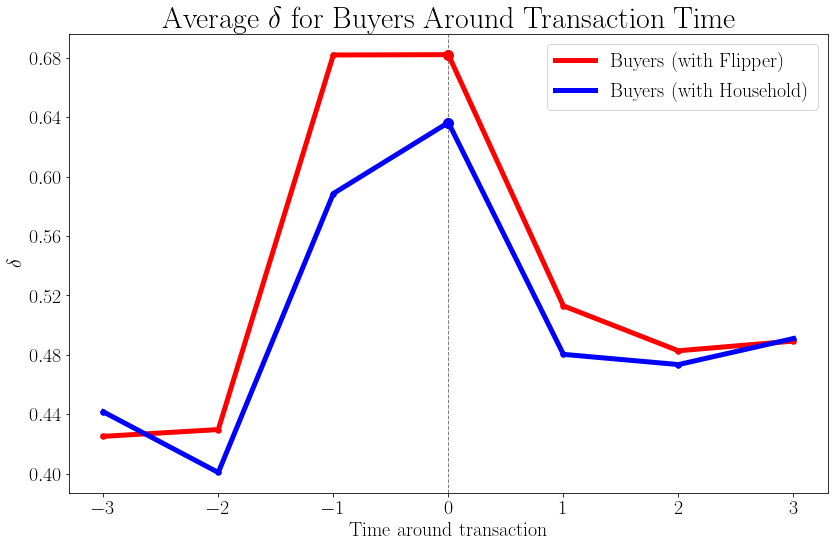

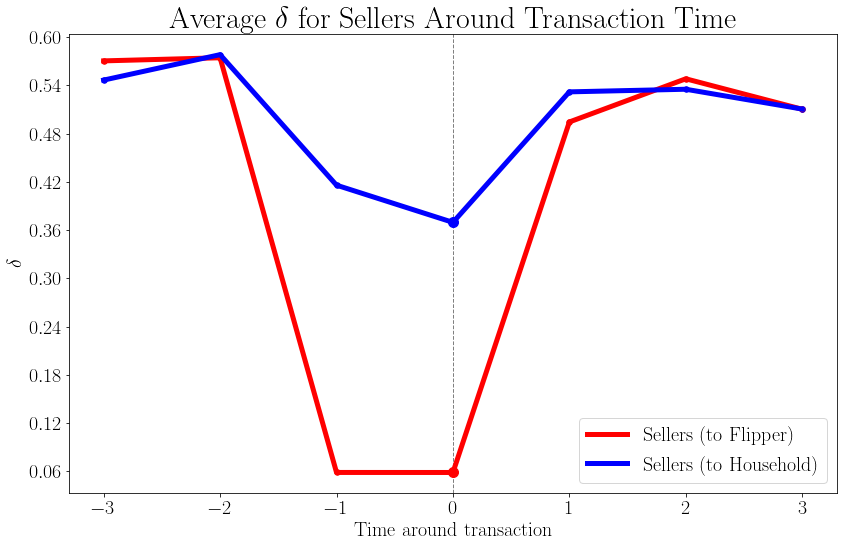

Overall Average Price: 11.89323978243539
Overall Average Variance: 1.307480301845715
Price Skewness: -0.19718481402674354
80th/20th Percentile Ratio: 1.2008442894307316
Average Flipper to Total Trade Ratio: 0.04598851253530425
Average Holding Duration for Households: 43.2735
Regression Slope (Price vs. Flipper Trade Ratio): 0.5234607036788017
R square: 1.0
Total time for operations: 281.67 seconds


In [98]:

T = 100  # umber of periods
N = 10000  # Number of households
start_time = time.time()

optimal_delta_0_star, optimal_delta_1_star = find_optimal_deltas_iterative(r, gamma, s, f, lambda1, rho, delta_grid, delta_0_star_initial, delta_1_star_initial)
print("Optimal delta_0_star:", optimal_delta_0_star)
print("Optimal delta_1_star:", optimal_delta_1_star)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Total time for operations: {elapsed_time:.2f} seconds")


start_time = time.time()
# Run the simulation
results = simulate_model(delta_grid, optimal_delta_0_star, optimal_delta_1_star, r, gamma, s, f, lambda1, rho, T, N)

# Unpack the results
(prices, overall_average_price, price_variance, price_skewness, percentile_80_20,
        overall_flipper_to_total_trade_ratio, average_holding_duration, 
         regression_slope, last_period_prices, delta_history, trade_history, ownership_history,r_squared)= results


end_time = time.time()
elapsed_time = end_time - start_time
# Plot the delta history around transaction times
plot_delta_history(delta_history, trade_history, T)
# Report average statistics
print("Overall Average Price:", overall_average_price)
print("Overall Average Variance:", price_variance)
print("Price Skewness:", price_skewness)
print("80th/20th Percentile Ratio:", percentile_80_20)
print("Average Flipper to Total Trade Ratio:", overall_flipper_to_total_trade_ratio)
print("Average Holding Duration for Households:", average_holding_duration)
print("Regression Slope (Price vs. Flipper Trade Ratio):", regression_slope)
print("R square:", r_squared)
print(f"Total time for operations: {elapsed_time:.2f} seconds")
# Use the function with your simulation results
#plot_average_delta_owners_nonowners(delta_history, ownership_history, T)


In [698]:
from scipy.stats import skew
import pandas as pd
import statsmodels.api as sm
import numpy as np
from scipy.interpolate import interp1d
import time

def simulate_model3(delta_grid, optimal_delta_0_star, optimal_delta_1_star, r, gamma, s, f, lambda1, rho, T, N):
    # Interpolation for value function
    Delta_V, _ = value_iteration(delta_grid, optimal_delta_0_star, optimal_delta_1_star, r, gamma, s, f, lambda1, rho)
    Delta_V_interp = interp1d(delta_grid, Delta_V, kind='linear', fill_value="extrapolate")

    # Initialize arrays to store statistics
    prices = []
    flipper_dummy = []
    average_prices_per_period = []
    household_trades = []
    flipper_trades = []
    ownership_status = np.random.binomial(1, s - F1(optimal_delta_0_star, optimal_delta_1_star, r, gamma, s, f, lambda1, rho), N)
    deltas = np.random.uniform(0, 1, N)
    delta_history = np.zeros((N, T))  # To store history of delta values for each agent
    ownership_history = np.zeros((N, T))  # To store history of ownership status for each agent
    trade_history = []  # To store trade events details: (t, buyer_index, seller_index, type_of_trade)
    holding_durations = np.zeros(N)
    last_period_prices = []  # Initialize to store prices from the last period

    # Run simulation
    for t in range(T):
        new_ownership_status = ownership_status.copy()
        new_deltas = deltas.copy()
        period_prices = []
        num_household_trades = 0
        num_flipper_trades = 0

        for i in range(N):
            random_val = np.random.uniform(0, 1)

            if ownership_status[i] == 0:  # Non-owner
                delta_prime = np.random.uniform(0, 1)
                if delta_prime < deltas[i]:
                    prob_meet_household = rho * H1(
                        deltas[i], optimal_delta_0_star, optimal_delta_1_star,
                        F1(optimal_delta_0_star, optimal_delta_1_star, r, gamma, s, f, lambda1, rho),
                        r, gamma, s, f, lambda1, rho
                    )
                else:
                    prob_meet_household = 0

                if deltas[i] > optimal_delta_0_star:
                    prob_meet_flipper = lambda1 * F1(optimal_delta_0_star, optimal_delta_1_star, r, gamma, s, f, lambda1, rho)
                else:
                    prob_meet_flipper = 0
                
                prob_shock = gamma

                total_prob = prob_meet_household + prob_meet_flipper + prob_shock
                prob_meet_household /= total_prob
                prob_meet_flipper /= total_prob
                prob_shock /= total_prob

                if random_val < prob_meet_household:
                    seller_index = np.random.choice(np.where(ownership_status == 1)[0])
                    price = P(deltas[i], deltas[seller_index], Delta_V_interp)
                    period_prices.append(price)
                    flipper_dummy.append(0)
                    new_ownership_status[i] = 1
                    new_ownership_status[seller_index] = 0
                    num_household_trades += 1
                    trade_history.append((t, i, seller_index, 'household'))
                elif random_val < (prob_meet_household + prob_meet_flipper):
                    price = P1(Delta_V_interp, deltas[i])
                    period_prices.append(price)
                    flipper_dummy.append(1)
                    new_ownership_status[i] = 1
                    num_flipper_trades += 1
                    trade_history.append((t, i, None, 'flipper'))
                else:
                    new_deltas[i] = np.random.uniform(0, 1)

            elif ownership_status[i] == 1:
                delta_prime = np.random.uniform(0, 1)
                if delta_prime > deltas[i]:
                    prob_sell_household = rho * (
                        H0(1.0, optimal_delta_0_star, optimal_delta_1_star,
                           F1(optimal_delta_0_star, optimal_delta_1_star, r, gamma, s, f, lambda1, rho),
                           r, gamma, s, f, lambda1, rho) -
                        H0(deltas[i], optimal_delta_0_star, optimal_delta_1_star,
                           F1(optimal_delta_0_star, optimal_delta_1_star, r, gamma, s, f, lambda1, rho),
                           r, gamma, s, f, lambda1, rho)
                    )
                else:
                    prob_sell_household = 0

                if deltas[i] < optimal_delta_1_star:
                    prob_sell_flipper = lambda1 * F0(optimal_delta_0_star, optimal_delta_1_star, r, gamma, s, f, lambda1, rho)
                else:
                    prob_sell_flipper = 0
                
                prob_shock = gamma

                total_prob = prob_sell_household + prob_sell_flipper + prob_shock
                prob_sell_household /= total_prob
                prob_sell_flipper /= total_prob
                prob_shock /= total_prob

                if random_val < prob_sell_household:
                    buyer_index = np.random.choice(np.where(ownership_status == 0)[0])
                    price = P(deltas[buyer_index], deltas[i], Delta_V_interp)
                    period_prices.append(price)
                    flipper_dummy.append(0)
                    new_ownership_status[i] = 0
                    new_ownership_status[buyer_index] = 1
                    num_household_trades += 1
                    trade_history.append((t, buyer_index, i, 'household'))
                elif random_val < (prob_sell_household + prob_sell_flipper):
                    price = P0(Delta_V_interp, deltas[i])
                    period_prices.append(price)
                    flipper_dummy.append(1)
                    new_ownership_status[i] = 0
                    num_flipper_trades += 1
                    trade_history.append((t, None, i, 'flipper'))
                else:
                    new_deltas[i] = np.random.uniform(0, 1)

                if new_ownership_status[i] == 1:
                    holding_durations[i] += 1

        ownership_status = new_ownership_status
        deltas = new_deltas
        prices.extend(period_prices)
        average_prices_per_period.append(np.mean(period_prices))
        household_trades.append(num_household_trades)
        flipper_trades.append(num_flipper_trades)
        delta_history[:, t] = deltas
        ownership_history[:, t] = ownership_status

        if t == T - 1:
            last_period_prices = period_prices.copy()

    burn_in = int(0.2 * T)
    prices = prices[burn_in * N:]
    flipper_dummy = flipper_dummy[burn_in * N:]

    # Calculate statistics across all agents and periods
    if len(prices) > 0:
        overall_average_price = np.mean(prices)
        price_variance = np.var(prices)
        price_skewness = skew(prices)
        percentile_80_20 = np.percentile(prices, 80) / np.percentile(prices, 20)
    else:
        overall_average_price = np.nan
        price_variance = np.nan
        price_skewness = np.nan
        percentile_80_20 = np.nan

    X = sm.add_constant(flipper_dummy)
    y = prices

    model = sm.OLS(y, X).fit()

    flipper_coeff = model.params[1]
    r_squared = model.rsquared

    return (prices, overall_average_price, price_variance, price_skewness, percentile_80_20,
            flipper_coeff, r_squared)

# Simulation parameters
T = 100  # Number of periods
N = 1000  # Number of households
start_time = time.time()

optimal_delta_0_star, optimal_delta_1_star = find_optimal_deltas_iterative(r, gamma, s, f, lambda1, rho, delta_grid, delta_0_star_initial, delta_1_star_initial)
print("Optimal delta_0_star:", optimal_delta_0_star)
print("Optimal delta_1_star:", optimal_delta_1_star)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Total time for finding deltas: {elapsed_time:.2f} seconds")

# Run the simulation
start_time = time.time()
results3 = simulate_model3(delta_grid, optimal_delta_0_star, optimal_delta_1_star, r, gamma, s, f, lambda1, rho, T, N)

# Unpack the results (with '3' suffix to avoid overwriting)
(prices3, overall_average_price3, price_variance3, price_skewness3, percentile_80_203, flipper_coeff3, r_squared3) = results3

print("Overall Average Price:", overall_average_price3)
print("Price Variance:", price_variance3)
print("Price Skewness:", price_skewness3)
print("80/20 Percentile Ratio:", percentile_80_203)
print("Flipper Coefficient:", flipper_coeff3)
print("R-squared:", r_squared3)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Total time for simulation: {elapsed_time:.2f} seconds")


Optimal delta_0_star: 0.47716112847660036
Optimal delta_1_star: 0.11112649047308443
Total time for finding deltas: 3.22 seconds
Overall Average Price: 11.880675144032644
Price Variance: 1.3255617201351706
Price Skewness: -0.19618193855440597
80/20 Percentile Ratio: 1.2034063328049756
Flipper Coefficient: -0.13781439741299684
R-squared: 0.0006055764195128654
Total time for simulation: 25.97 seconds


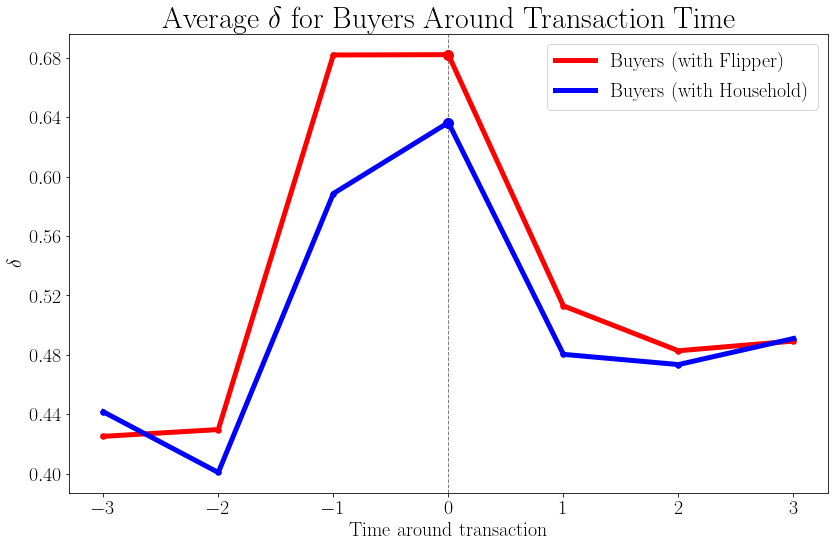

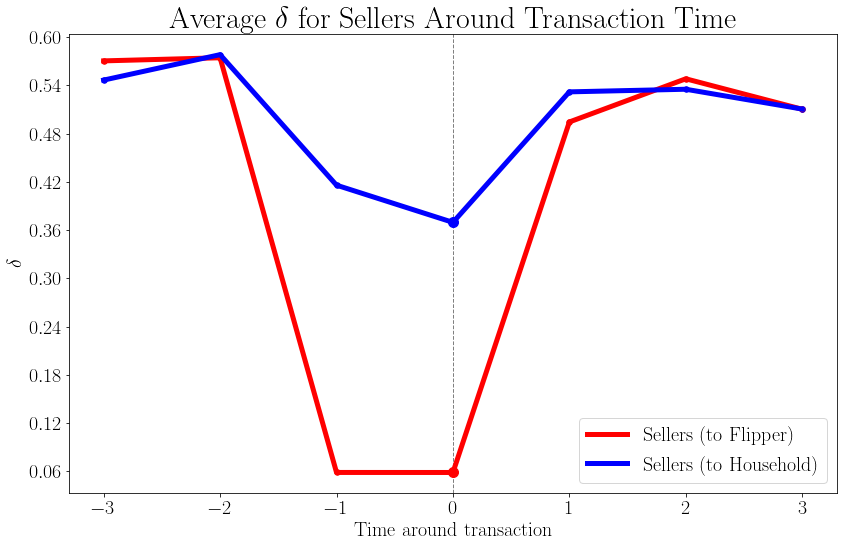

In [159]:
plot_delta_history(delta_history, trade_history, T)

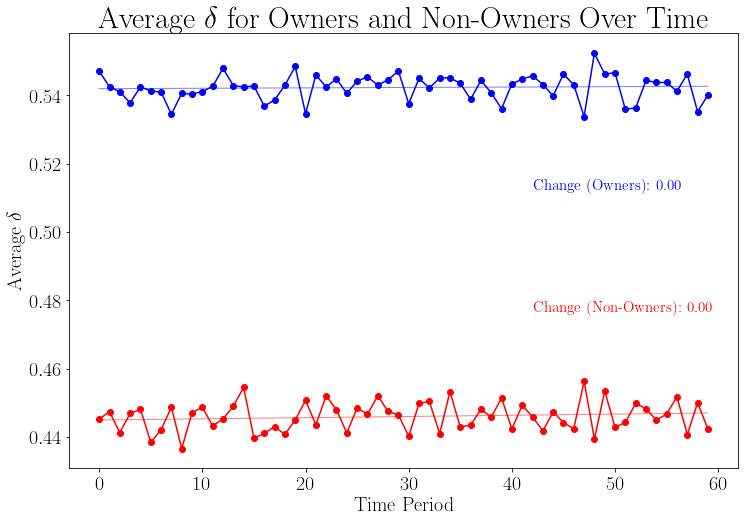

[1.17983112e-05 5.41941114e-01] [3.44780111e-05 4.44922166e-01]


In [178]:
plot_average_delta_owners_nonowners(delta_history, ownership_history, T)


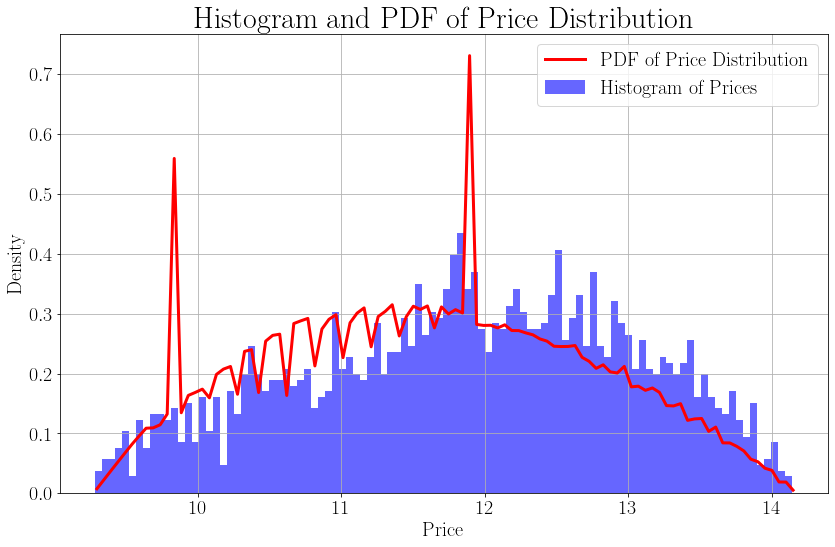

In [198]:

# Plot the histogram of prices and the PDF of prices on the same plot
last_period_prices_flat = np.ravel(last_period_prices)

plt.figure(figsize=(12, 8))

# Histogram of prices
plt.hist(last_period_prices_flat, bins=100, density=True, alpha=0.6, color='blue', label='Histogram of Prices')

# PDF of prices
plt.plot(p_values_mid, f_P, color='red', linewidth=3, label='PDF of Price Distribution')

# Labeling the plot
plt.xlabel('Price')
plt.ylabel('Density')
plt.title('Histogram and PDF of Price Distribution')
plt.grid(True)
plt.legend()

# Tight layout and save the figure if needed
plt.tight_layout()
# Uncomment the next line to save the plot to a file
# plt.savefig(output_path_pdf)
plt.savefig("/Users/user/Desktop/Praca/Minnesota season 6/JOB MARKET/codes/plots/BIG_sim_vs_model.pdf")
plt.show()


In [179]:

T2 = 1000  # umber of periods
N2 = 5000  # Number of households


start_time = time.time()
# Run the simulation
results2 = simulate_model(delta_grid, optimal_delta_0_star, optimal_delta_1_star, r, gamma, s, f, lambda1, rho, T2, N2)

# Unpack the results
(prices2, overall_average_price2, price_variance2, price_skewness2, percentile_80_202,
        overall_flipper_to_total_trade_ratio2, average_holding_duration2, 
         regression_slope2, last_period_prices2, delta_history2, trade_history2, ownership_history2,r_squared2)= results2




Number of prices after burn-in: 62706


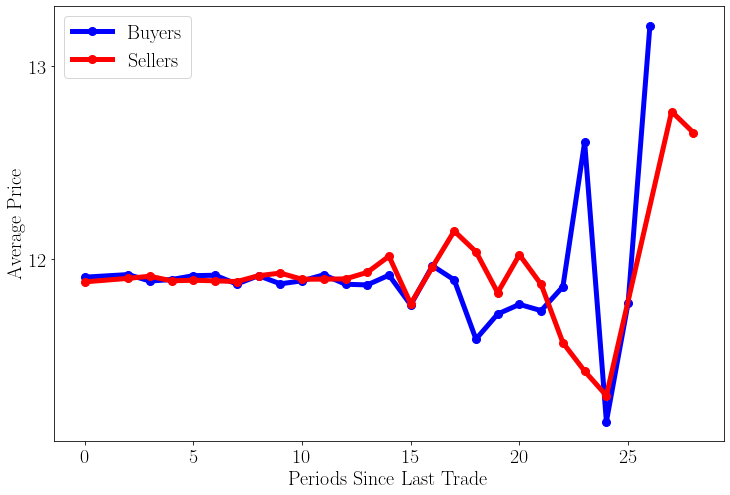

In [180]:
import numpy as np
import matplotlib.pyplot as plt

def plot_price_vs_time_between_trades(trade_history, prices, T, N):
    """
    Identify agents who traded more than once, calculate the time between their trades, and plot the average price in the second transaction.
    """

    # Initialize lists to store waiting times and prices for both buyers and sellers
    buyer_waiting_times = []
    buyer_prices = []
    seller_waiting_times = []
    seller_prices = []

    # Initialize arrays to track last trade times for buyers and sellers
    last_buyer_trade_time = np.full(N, -1)  # Start with -1 indicating no trade yet
    last_seller_trade_time = np.full(N, -1)  # Start with -1 indicating no trade yet

    # Price index to iterate through prices
    price_index = 0

    # Iterate through trade history to compute time since last trade for each transaction
    for trade_event in trade_history:
        t, buyer_index, seller_index, trade_type = trade_event

        if price_index >= len(prices):  # Ensure we don't go out of bounds in the prices list
            break

        if trade_type == 'household':  # Household trade
            if buyer_index is not None:  # Record for buyer
                if last_buyer_trade_time[buyer_index] >= 0:  # If the buyer has transacted before
                    time_since_last_trade = t - last_buyer_trade_time[buyer_index]
                    buyer_waiting_times.append(time_since_last_trade)
                    buyer_prices.append(prices[price_index])  # Record the price in the second trade
                last_buyer_trade_time[buyer_index] = t

            if seller_index is not None:  # Record for seller
                if last_seller_trade_time[seller_index] >= 0:  # If the seller has transacted before
                    time_since_last_trade = t - last_seller_trade_time[seller_index]
                    seller_waiting_times.append(time_since_last_trade)
                    seller_prices.append(prices[price_index])  # Record the price in the second trade
                last_seller_trade_time[seller_index] = t

        elif trade_type == 'flipper':  # Flipper trade (no seller index in this case)
            if buyer_index is not None:  # Record for buyer
                if last_buyer_trade_time[buyer_index] >= 0:
                    time_since_last_trade = t - last_buyer_trade_time[buyer_index]
                    buyer_waiting_times.append(time_since_last_trade)
                    buyer_prices.append(prices[price_index])  # Record the price in the second trade
                last_buyer_trade_time[buyer_index] = t

        # Move to the next price for each transaction
        price_index += 1

    # Calculate unique waiting times and corresponding average prices
    unique_buyer_waiting_times = np.unique(buyer_waiting_times)
    avg_buyer_prices = [np.mean([buyer_prices[i] for i in range(len(buyer_waiting_times)) if buyer_waiting_times[i] == wt]) for wt in unique_buyer_waiting_times]

    unique_seller_waiting_times = np.unique(seller_waiting_times)
    avg_seller_prices = [np.mean([seller_prices[i] for i in range(len(seller_waiting_times)) if seller_waiting_times[i] == wt]) for wt in unique_seller_waiting_times]

    # Plot the results with improved aesthetics
    plt.figure(figsize=(12, 8))

    # Plot for buyers
    plt.plot(unique_buyer_waiting_times, avg_buyer_prices, 'bo-', label='Buyers', linewidth=5, markersize=8)

    # Plot for sellers
    plt.plot(unique_seller_waiting_times, avg_seller_prices, 'ro-', label='Sellers', linewidth=5, markersize=8)

    # Add labels and title
    plt.xlabel('Periods Since Last Trade', fontsize=20)
    plt.ylabel('Average Price', fontsize=20)
    #plt.title('Average Transaction Price vs. Time Since Last Trade', fontsize=16)

    # Add legend and grid
    plt.legend(loc='best', fontsize=20)
    #plt.grid(True)
    plt.gca().yaxis.set_major_locator(plt.MaxNLocator(integer=True))
    # Save the plot for consistent output with other plots
    output_path = "/Users/user/Desktop/Praca/Minnesota season 6/JOB MARKET/codes/plots/BIG_evolution.pdf"
    plt.savefig(output_path)
    plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: int(x)))

    # Show the plot
    plt.show()

# Example usage
# Assuming you have `trade_history`, `prices`, `T`, and `N` from your simulation
plot_price_vs_time_between_trades(trade_history2, prices2, T2, N2)


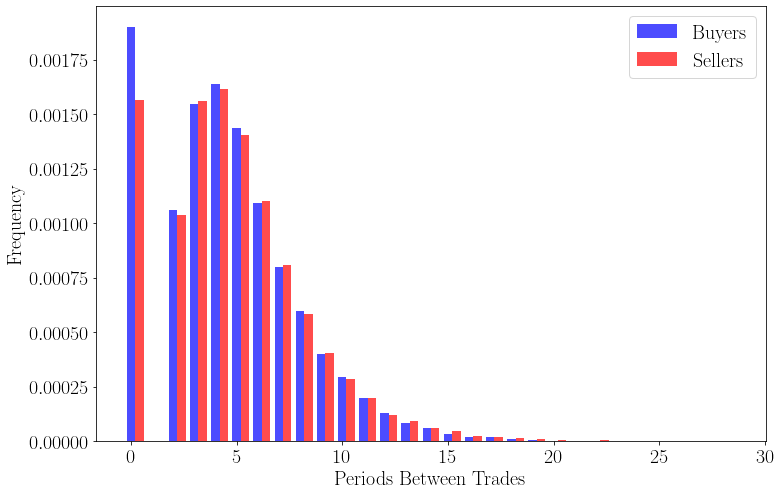

In [199]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

def plot_waiting_time_frequencies(trade_history, prices, N):
    """
    Calculate and plot the frequency of waiting times (number of agents who waited a certain number of periods between trades).
    """

    # Initialize lists to store waiting times for both buyers and sellers
    buyer_waiting_times = []
    seller_waiting_times = []

    # Initialize arrays to track last trade times for buyers and sellers
    last_buyer_trade_time = np.full(N, -1)  # Start with -1 indicating no trade yet
    last_seller_trade_time = np.full(N, -1)  # Start with -1 indicating no trade yet

    # Price index to iterate through prices
    price_index = 0

    # Iterate through trade history to compute time since last trade for each transaction
    for trade_event in trade_history:
        t, buyer_index, seller_index, trade_type = trade_event

        if price_index >= len(prices):  # Ensure we don't go out of bounds in the prices list
            break

        if trade_type == 'household':  # Household trade
            if buyer_index is not None:  # Record for buyer
                if last_buyer_trade_time[buyer_index] >= 0:  # If the buyer has transacted before
                    time_since_last_trade = t - last_buyer_trade_time[buyer_index]
                    buyer_waiting_times.append(time_since_last_trade)
                last_buyer_trade_time[buyer_index] = t

            if seller_index is not None:  # Record for seller
                if last_seller_trade_time[seller_index] >= 0:  # If the seller has transacted before
                    time_since_last_trade = t - last_seller_trade_time[seller_index]
                    seller_waiting_times.append(time_since_last_trade)
                last_seller_trade_time[seller_index] = t

        elif trade_type == 'flipper':  # Flipper trade (no seller index in this case)
            if buyer_index is not None:  # Record for buyer
                if last_buyer_trade_time[buyer_index] >= 0:
                    time_since_last_trade = t - last_buyer_trade_time[buyer_index]
                    buyer_waiting_times.append(time_since_last_trade)
                last_buyer_trade_time[buyer_index] = t

        # Move to the next price for each transaction
        price_index += 1

    # Count the occurrences of waiting times
    buyer_freq, buyer_bins = np.histogram(buyer_waiting_times, bins=np.arange(min(buyer_waiting_times), max(buyer_waiting_times) + 2))
    seller_freq, seller_bins = np.histogram(seller_waiting_times, bins=np.arange(min(seller_waiting_times), max(seller_waiting_times) + 2))

    # Normalize by total number of agents
    buyer_freq = buyer_freq /(T2*N2)
    seller_freq = seller_freq /(T2*N2)

    # Plot the frequency distribution
    plt.figure(figsize=(12, 8))

    plt.bar(buyer_bins[:-1], buyer_freq, width=0.4, align='center', color='blue', label='Buyers', alpha=0.7)
    plt.bar(seller_bins[:-1] + 0.4, seller_freq, width=0.4, align='center', color='red', label='Sellers', alpha=0.7)

    # Add labels and title
    plt.xlabel('Periods Between Trades', fontsize=20)
    plt.ylabel('Frequency', fontsize=20)
    plt.legend(loc='best', fontsize=20)

    # Save the plot
    output_path = "/Users/user/Desktop/Praca/Minnesota season 6/JOB MARKET/codes/plots/BIGfrequency.pdf"
    plt.savefig(output_path)

    # Show the plot
    plt.show()

# Example usage
# Assuming you have `trade_history`, `prices`, and `N` from your simulation
plot_waiting_time_frequencies(trade_history2, prices2, N2)


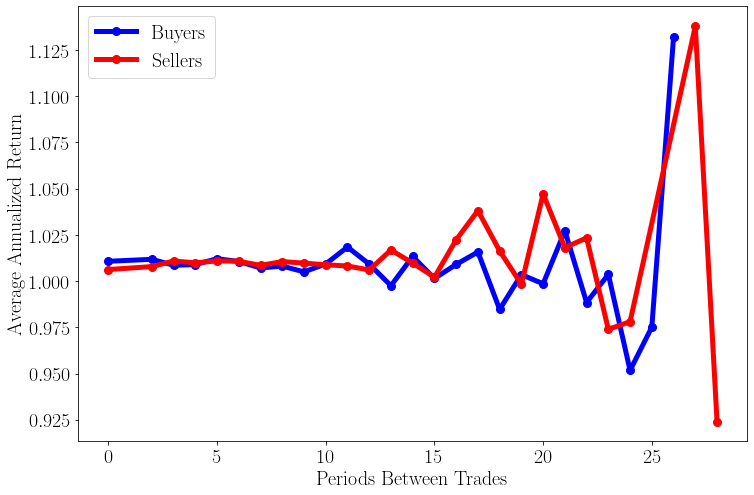

In [185]:
import numpy as np
import matplotlib.pyplot as plt

def plot_annualized_returns_vs_time_between_trades(trade_history, prices, T, N):
    """
    Identify agents who traded more than once, calculate the time between their trades,
    and plot the average annualized return as a function of the number of periods between trades.
    """

    # Initialize lists to store first and second trade prices, waiting times, and returns for both buyers and sellers
    buyer_waiting_times = []
    buyer_first_prices = []
    buyer_second_prices = []
    seller_waiting_times = []
    seller_first_prices = []
    seller_second_prices = []

    # Initialize arrays to track last trade times for buyers and sellers
    last_buyer_trade_time = np.full(N, -1)  # Start with -1 indicating no trade yet
    last_buyer_trade_price = np.full(N, -1.0)  # Placeholder for first trade price
    last_seller_trade_time = np.full(N, -1)  # Start with -1 indicating no trade yet
    last_seller_trade_price = np.full(N, -1.0)  # Placeholder for first trade price

    # Price index to iterate through prices
    price_index = 0

    # Iterate through trade history to compute time since last trade and calculate returns
    for trade_event in trade_history:
        t, buyer_index, seller_index, trade_type = trade_event

        if price_index >= len(prices):  # Ensure we don't go out of bounds in the prices list
            break

        if trade_type == 'household':  # Household trade
            if buyer_index is not None:  # For the buyer
                if last_buyer_trade_time[buyer_index] >= 0:  # If the buyer has transacted before
                    time_since_last_trade = t - last_buyer_trade_time[buyer_index]
                    buyer_waiting_times.append(time_since_last_trade)
                    buyer_first_prices.append(last_buyer_trade_price[buyer_index])
                    buyer_second_prices.append(prices[price_index])
                # Update last trade time and price
                last_buyer_trade_time[buyer_index] = t
                last_buyer_trade_price[buyer_index] = prices[price_index]

            if seller_index is not None:  # For the seller
                if last_seller_trade_time[seller_index] >= 0:  # If the seller has transacted before
                    time_since_last_trade = t - last_seller_trade_time[seller_index]
                    seller_waiting_times.append(time_since_last_trade)
                    seller_first_prices.append(last_seller_trade_price[seller_index])
                    seller_second_prices.append(prices[price_index])
                # Update last trade time and price
                last_seller_trade_time[seller_index] = t
                last_seller_trade_price[seller_index] = prices[price_index]

        elif trade_type == 'flipper':  # Flipper trade (no seller index in this case)
            if buyer_index is not None:  # For the buyer
                if last_buyer_trade_time[buyer_index] >= 0:
                    time_since_last_trade = t - last_buyer_trade_time[buyer_index]
                    buyer_waiting_times.append(time_since_last_trade)
                    buyer_first_prices.append(last_buyer_trade_price[buyer_index])
                    buyer_second_prices.append(prices[price_index])
                # Update last trade time and price
                last_buyer_trade_time[buyer_index] = t
                last_buyer_trade_price[buyer_index] = prices[price_index]

        # Move to the next price for each transaction
        price_index += 1

    # Calculate annualized returns for buyers
    buyer_returns = [
        (second_price / first_price) #** (1 / periods) 
        for first_price, second_price, periods in zip(buyer_first_prices, buyer_second_prices, buyer_waiting_times)
    ]

    # Calculate annualized returns for sellers
    seller_returns = [
        (second_price / first_price) #** (1 / periods) 
        for first_price, second_price, periods in zip(seller_first_prices, seller_second_prices, seller_waiting_times)
    ]

    # Calculate unique waiting times and corresponding average returns
    unique_buyer_waiting_times = np.unique(buyer_waiting_times)
    avg_buyer_returns = [np.mean([buyer_returns[i] for i in range(len(buyer_waiting_times)) if buyer_waiting_times[i] == wt]) for wt in unique_buyer_waiting_times]

    unique_seller_waiting_times = np.unique(seller_waiting_times)
    avg_seller_returns = [np.mean([seller_returns[i] for i in range(len(seller_waiting_times)) if seller_waiting_times[i] == wt]) for wt in unique_seller_waiting_times]

    # Plot the results with improved aesthetics
    plt.figure(figsize=(12, 8))

    # Plot for buyers
    plt.plot(unique_buyer_waiting_times, avg_buyer_returns, 'bo-', label='Buyers', linewidth=5, markersize=8)

    # Plot for sellers
    plt.plot(unique_seller_waiting_times, avg_seller_returns, 'ro-', label='Sellers', linewidth=5, markersize=8)

    # Add labels and title
    plt.xlabel('Periods Between Trades', fontsize=20)
    plt.ylabel('Average Annualized Return', fontsize=20)
    #plt.title('Average Annualized Return vs. Time Between Trades', fontsize=16)

    # Add legend and grid
    plt.legend(loc='best', fontsize=20)
    #plt.grid(True)
    plt.gca().yaxis.set_major_locator(plt.MaxNLocator(integer=True))
    # Save the plot for consistent output with other plots
    output_path = "/Users/user/Desktop/Praca/Minnesota season 6/JOB MARKET/codes/plots/BIG_returns.pdf"
    plt.savefig(output_path)
    plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: int(x)))

    # Show the plot
    plt.show()

# Example usage
# Assuming you have `trade_history`, `prices`, `T`, and `N` from your simulation
plot_annualized_returns_vs_time_between_trades(trade_history2, prices2, T2, N2)


In [102]:
# Generate delta_grid

fixed_params = {
    'f': f,
    's': s,
    'r': r,
    'gamma': gamma,
    'rho': rho,
    'lambda1': lambda1
}




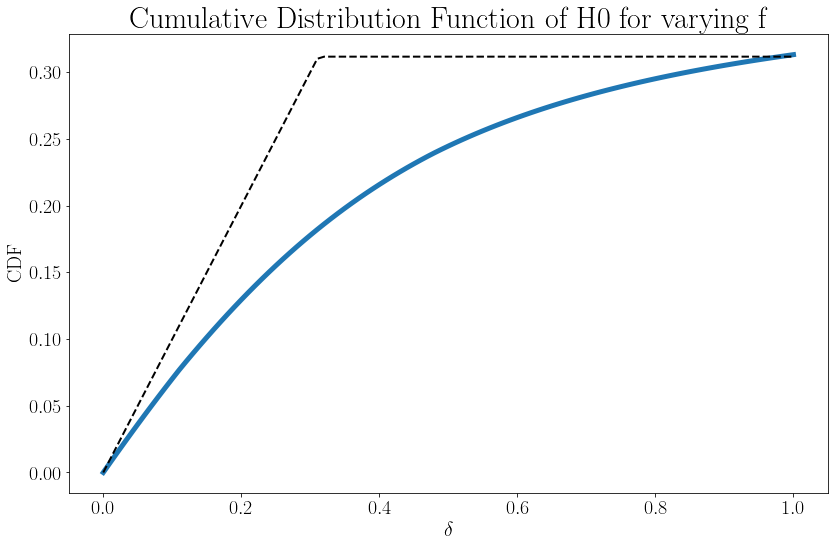

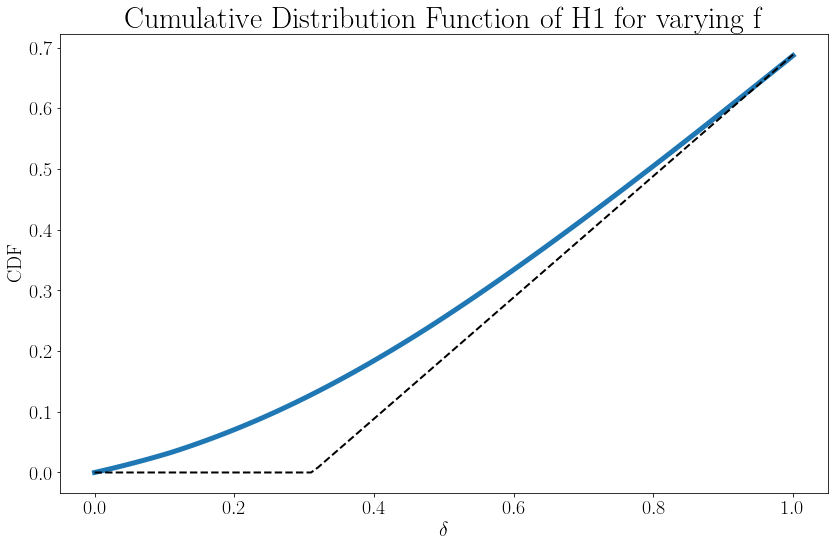

In [107]:
import numpy as np
import matplotlib.pyplot as plt

# Unified plotting function for H0 and H1
def plot_cdf(delta_grid, param_name, param_values, fixed_params, H_type):
    delta_star = 1 - fixed_params['s']
    
    plt.figure(figsize=(12, 8))
    for param_value in param_values:
        params = fixed_params.copy()
        params[param_name] = param_value
        
        # Find optimal deltas
        delta_0_star, delta_1_star = find_optimal_deltas_iterative(
            params['r'], params['gamma'], params['s'], params['f'], 
            params['lambda1'], params['rho'], delta_grid, delta_0_star_initial, delta_1_star_initial
        )
        
        if H_type == 'H0':
            H_vals = np.array([H0(delta, delta_0_star, delta_1_star, F1(delta_0_star, delta_1_star, 
                params['r'], params['gamma'], params['s'], params['f'], params['lambda1'], params['rho']), 
                params['r'], params['gamma'], params['s'], params['f'], params['lambda1'], params['rho']) for delta in delta_grid])
            label = 'H0'
            line_label = f'H0, {param_name}=$\\infty$'
            inf_line = np.where(delta_grid <= delta_star, delta_grid, delta_star)
        else:
            H_vals = np.array([H1(delta, delta_0_star, delta_1_star, F1(delta_0_star, delta_1_star, 
                params['r'], params['gamma'], params['s'], params['f'], params['lambda1'], params['rho']), 
                params['r'], params['gamma'], params['s'], params['f'], params['lambda1'], params['rho']) for delta in delta_grid])
            label = 'H1'
            line_label = f'H1, {param_name}=$\\infty$'
            inf_line = np.where(delta_grid <= delta_star, 0, delta_grid - delta_star)

        # Plot CDF
        plt.plot(delta_grid, H_vals,linewidth=5, label=f'{label}, {param_name}={param_value}')

    # Add asymptotic line
    plt.plot(delta_grid, inf_line, 'k--', linewidth=2, label=line_label)

    #plt.legend()
    plt.xlabel('$\delta$')
    plt.ylabel('CDF')
    plt.title(f'Cumulative Distribution Function of {label} for varying {param_name}')
    #plt.grid(True)
    plt.tight_layout()
    output_path = f"/Users/user/Desktop/Praca/Minnesota season 6/JOB MARKET/codes/plots/{label}_cdf_{param_name}.pdf"
    plt.savefig(output_path, format='pdf')
    plt.show()

# Example usage: Plot CDFs for different values of f
f_values = [0.0048366897]#[0.04, 0.08, 0.12]
plot_cdf(delta_grid, 'f', f_values, fixed_params, 'H0')
plot_cdf(delta_grid, 'f', f_values, fixed_params, 'H1')

# Example usage: Plot CDFs for different values of lambda1
# lambda_values = [1.0, 2.0, 4.0, 12.0]
# plot_cdf(delta_grid, 'lambda1', lambda_values, fixed_params, 'H0')
# plot_cdf(delta_grid, 'lambda1', lambda_values, fixed_params, 'H1')


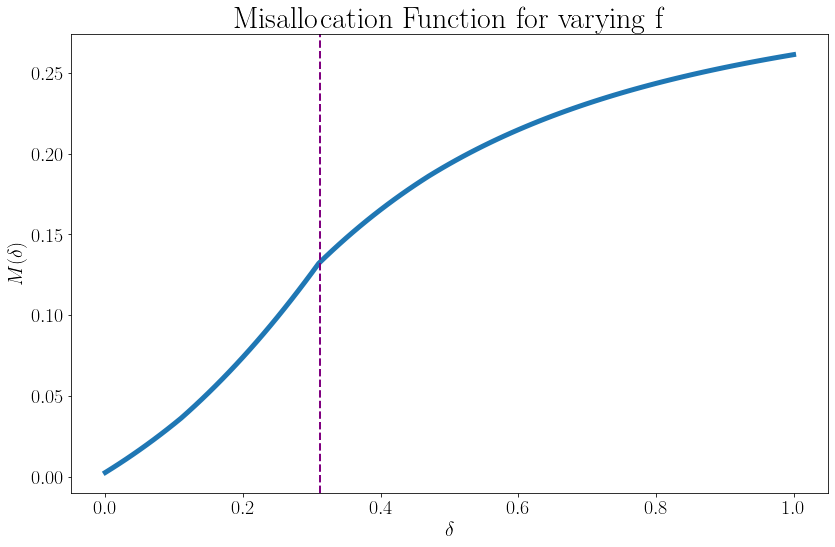

In [106]:
import numpy as np
import matplotlib.pyplot as plt

# Define the misallocation function M(delta) using direct cumulative sums
def misallocation(delta_grid, delta_star, delta_0_star, delta_1_star, params):
    # Calculate dH0 and dH1 values across the delta_grid
    dH0_vals = np.array([dH0(delta, delta_0_star, delta_1_star, **params) for delta in delta_grid])
    dH1_vals = np.array([dH1(delta, delta_0_star, delta_1_star, **params) for delta in delta_grid])
    
    # Calculate cumulative sums up to delta_star for dH1, and from delta_star for dH0
    int_dH1 = np.cumsum(dH1_vals * (delta_grid < delta_star)) * (delta_grid[1] - delta_grid[0])
    int_dH0 = np.cumsum(dH0_vals * (delta_grid > delta_star)) * (delta_grid[1] - delta_grid[0])
    
    # Misallocation is the sum of these integrals
    M_vals = int_dH1 + int_dH0
    return M_vals

# Unified plotting function for misallocation
def plot_misallocation(param_name, param_values, fixed_params, delta_grid):
    plt.figure(figsize=(12, 8))
    delta_star = 1 - fixed_params['s']
    
    for param_value in param_values:
        params = fixed_params.copy()
        params[param_name] = param_value
        
        # Calculate optimal delta_0_star and delta_1_star for each parameter value
        delta_0_star, delta_1_star = find_optimal_deltas_iterative(
            params['r'], params['gamma'], params['s'], params['f'], params['lambda1'], params['rho'], 
            delta_grid, delta_0_star_initial, delta_1_star_initial
        )
        
        # Calculate misallocation values
        M_vals = misallocation(delta_grid, delta_star, delta_0_star, delta_1_star, params)
        
        # Plot the results
        plt.plot(delta_grid, M_vals,linewidth=5, label=f'{param_name}={param_value}')

    # Mark the delta_star line
    plt.axvline(x=delta_star, color='purple', linewidth=2,linestyle='--', label='$\delta^*$')
    
    #plt.legend()
    plt.xlabel('$\delta$')
    plt.ylabel('$M(\delta)$')
    plt.title(f'Misallocation Function for varying {param_name}')
    #plt.grid(True)
    plt.tight_layout()
    
    # Save the plot as a PDF file
    output_path = f"/Users/user/Desktop/Praca/Minnesota season 6/JOB MARKET/codes/plots/BIGmisallocation_{param_name}.pdf"
    plt.savefig(output_path, format='pdf')
    plt.show()

# Example usage: Plot misallocation for different values of f
f_values = [0.0048366897]#[0.04, 0.08, 0.12]  # Add more values as needed
plot_misallocation('f', f_values, fixed_params, delta_grid)

# Example usage: Plot misallocation for different values of rho
#rho_values = [1.0, 2.0, 4.0, 12.0]  # Define this list if needed
#plot_misallocation('rho', rho_values, fixed_params, delta_grid)


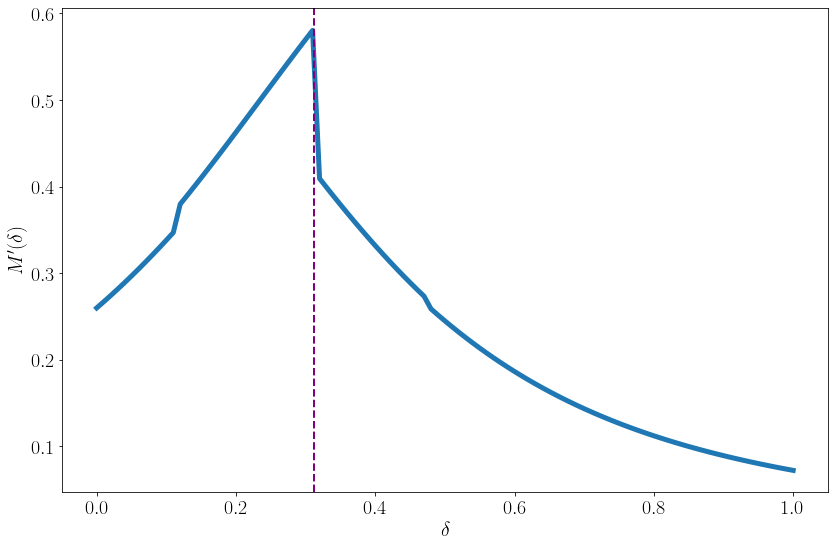

In [105]:
import numpy as np
import matplotlib.pyplot as plt

# Define the misallocation density function M'(delta)
def misallocation_density(delta_grid, delta_star, delta_0_star, delta_1_star, params):
    # Calculate dH0 and dH1 values across the delta_grid
    dH0_vals = np.array([dH0(delta, delta_0_star, delta_1_star, **params) for delta in delta_grid])
    dH1_vals = np.array([dH1(delta, delta_0_star, delta_1_star, **params) for delta in delta_grid])
    
    # Compute the misallocation density based on delta_star
    M_prime_vals = np.where(delta_grid <= delta_star, dH1_vals, dH0_vals)
    return M_prime_vals

# Unified plotting function for misallocation density
def plot_misallocation_density(param_name, param_values, fixed_params, delta_grid):
    plt.figure(figsize=(12, 8))
    delta_star = 1 - fixed_params['s']
    
    for param_value in param_values:
        params = fixed_params.copy()
        params[param_name] = param_value
        
        # Calculate optimal delta_0_star and delta_1_star for each parameter value
        delta_0_star, delta_1_star = find_optimal_deltas_iterative(
            params['r'], params['gamma'], params['s'], params['f'], params['lambda1'], params['rho'], 
            delta_grid, delta_0_star_initial, delta_1_star_initial
        )
        
        # Calculate misallocation density values
        M_prime_vals = misallocation_density(delta_grid, delta_star, delta_0_star, delta_1_star, params)
        
        # Plot the results
        plt.plot(delta_grid, M_prime_vals,linewidth=5, label=f'{param_name}={param_value}')

    # Mark the delta_star line
    plt.axvline(x=delta_star, color='purple',linewidth=2, linestyle='--', label='$\delta^*$')
    
    #plt.legend()
    plt.xlabel('$\delta$')
    plt.ylabel("$M'(\delta)$")
    
    #plt.title(f'Misallocation Density for varying {param_name}')
    #plt.grid(True)
    plt.tight_layout()
    
    # Save the plot as a PDF file
    output_path = f"/Users/user/Desktop/Praca/Minnesota season 6/JOB MARKET/codes/plots/BIGmisallocation_density_{param_name}.pdf"
    plt.savefig(output_path, format='pdf')
    plt.show()

# Example usage: Plot misallocation density for different values of f
f_values =[0.0048366897]#[0.04, 0.08, 0.12, 0.24]
plot_misallocation_density('f', f_values, fixed_params, delta_grid)

# Example usage: Plot misallocation density for different values of gamma
# gamma_values = [0.1, 0.25, 0.5, 1.0]
# plot_misallocation_density('gamma', gamma_values, fixed_params, delta_grid)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# Function to calculate the essential variables for comparative statics
def simple_calculate_variables(param_value, param_name, fixed_params, delta_grid):
    params = fixed_params.copy()
    params[param_name] = param_value
    
    # Calculate the optimal deltas based on the new parameter value
    optimal_deltas_local = find_optimal_deltas_iterative(
        params['r'], params['gamma'], params['s'], params['f'], params['lambda1'], params['rho'], delta_grid, 0.3, 0.05
    )
    params['optimal_delta_0_local'], params['optimal_delta_1_local'] = optimal_deltas_local

    # Calculate F1 and F0 values
    F1_value_local = F1(params['optimal_delta_0_local'], params['optimal_delta_1_local'], params['r'], params['gamma'], params['s'], params['f'], params['lambda1'], params['rho'])
    F0_value_local = params['f'] - F1_value_local
    
    # Perform value iteration to get Delta_V
    Delta_V_local, _ = value_iteration(
        delta_grid, params['optimal_delta_0_local'], params['optimal_delta_1_local'], params['r'], params['gamma'], params['s'], params['f'], params['lambda1'], params['rho']
    )
    
    # Interpolate Delta_V
    Delta_V_interp_local = interp1d(delta_grid, Delta_V_local, kind='linear', fill_value="extrapolate")
    
    # Calculate P0 and P1 values
    P0_value_local = P0(Delta_V_interp_local, params['optimal_delta_1_local'])
    P1_value_local = P1(Delta_V_interp_local, params['optimal_delta_0_local'])
    
    results = {
        'delta_0_local': params['optimal_delta_0_local'],
        'delta_1_local': params['optimal_delta_1_local'],
        'F1_value_local': F1_value_local,
        'F0_value_local': F0_value_local,
        'P0_value_local': P0_value_local,
        'P1_value_local': P1_value_local,
    }
    
    return results

# Simple comparative statics exercise function
def simple_comparative_statics_exercise(param_name, param_min, param_max, fixed_params, delta_grid, N_draws):
    param_draws = np.linspace(param_min, param_max, N_draws)
    
    results_list = []
    for param_value in param_draws:
        results = simple_calculate_variables(param_value, param_name, fixed_params, delta_grid)
        results_list.append(results)
        
    return param_draws, results_list

# Function to plot the variables
def plot_simple_variables(param_draws, results_list, param_name):
    grouped_variables = [
        {'delta_0_local', 'delta_1_local'},
        {'F1_value_local', 'F0_value_local'},
        {'P0_value_local', 'P1_value_local'}
    ]
    
    plt.rcParams['text.usetex'] = False
    
    for group in grouped_variables:
        plt.figure(figsize=(12, 8))
        for var in group:
            values = [result[var] for result in results_list]
            plt.plot(param_draws, values, marker='o', linestyle='-', linewidth=3, label=var)
        plt.title(f'{", ".join(group)} as Function of {param_name}')
        plt.xlabel(param_name.capitalize())
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True)
        plt.savefig(f"/Users/user/Desktop/Praca/Minnesota season 6/JOB MARKET/codes/plots/SIMPLE_{param_name}_{'_'.join(group)}.pdf", format='pdf')
        plt.show()

# Example usage:

# Define the delta grid
delta_grid = np.linspace(0, 1, 101)

# Run simple comparative statics for parameter 'f'
param_draws, results_list = simple_comparative_statics_exercise('f', 0.04, 0.24, fixed_params, delta_grid, 3)

# Plot the results
plot_simple_variables(param_draws, results_list, 'f')


In [627]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.integrate import simps, quad


# Function to compute V1, V0, and Delta_V (theoretical)
def calculate_V1_V0(delta_grid, Delta_V_interp, params):
    V1_values = np.array([
        V_q(1, delta, params['r'], params['gamma'], params['s'], params['f'], params['lambda1'], params['rho'],
            params['optimal_delta_0_local'], params['optimal_delta_1_local'])
        for delta in delta_grid
    ])
    V0_values = np.array([
        V_q(0, delta, params['r'], params['gamma'], params['s'], params['f'], params['lambda1'], params['rho'],
            params['optimal_delta_0_local'], params['optimal_delta_1_local'])
        for delta in delta_grid
    ])
    return V1_values, V0_values

# Function to calculate the integrals and welfare
def calculate_welfare(V1_values, V0_values, dH1_values, dH0_values, delta_grid, F0_value, F1_value, W0_val, W1_val, params):
    intV1 = np.sum(V1_values * dH1_values)*grid_spacing#simps(V1_values * dH1_values, delta_grid)
    intV0 = np.sum(V0_values * dH0_values)*grid_spacing#simps(V0_values * dH0_values, delta_grid)
    welfare_agent = intV1 + intV0

    intW0 = W0_val * F0_value
    intW1 = W1_val * F1_value
    welfare_flipper = intW0 + intW1

    return intV1, intV0, welfare_agent, intW0, intW1, welfare_flipper

In [ ]:
delta_0_star_initial, delta_1_star_initial =0.03909909111407851,0.24253749677718742#n0.3, 0.05
r = 0.0361577940
gamma = 0.055
f=0.10750
s = 0.6884162140
lambda1 = 4.0
rho = 2.0

# Updated function to calculate all required variables
def calculate_variables(param_value, param_name, fixed_params, delta_grid):
    params = fixed_params.copy()
    params[param_name] = param_value
    
    # Calculate the optimal deltas based on the new parameter value
    optimal_deltas = find_optimal_deltas_iterative(
        params['r'], params['gamma'], params['s'], params['f'], params['lambda1'], params['rho'], 
        delta_grid, 0.03909909111407851,0.24253749677718742
    )
    params['optimal_delta_0_local'], params['optimal_delta_1_local'] = optimal_deltas
    F1_value = F1(params['optimal_delta_0_local'], params['optimal_delta_1_local'], params['r'], params['gamma'], params['s'], params['f'], params['lambda1'], params['rho'])
    F0_value = params['f'] - F1_value
    
    # Compute H1_values and H0_values as arrays
    H1_values, H0_values = compute_H_values(
        delta_grid, params['optimal_delta_0_local'], params['optimal_delta_1_local'], params['r'], params['gamma'], params['s'], params['f'], params['lambda1'], params['rho']
    )

    # Initialize dH0_values and dH1_values as arrays by using the _gen functions
    dH0_values = dH0_gen(params['optimal_delta_0_local'], params['optimal_delta_1_local'], 
                         params['r'], params['gamma'], params['s'], params['f'], params['lambda1'], params['rho']
    )
    dH1_values = dH1_gen(params['optimal_delta_0_local'], params['optimal_delta_1_local'], 
                         params['r'], params['gamma'], params['s'], params['f'], params['lambda1'], params['rho']
    )

    # Perform value iteration
    Delta_V, _ = value_iteration(
        delta_grid, params['optimal_delta_0_local'], params['optimal_delta_1_local'], params['r'], params['gamma'], params['s'], params['f'], params['lambda1'], params['rho']
    )

    Delta_V_interp = interp1d(delta_grid, Delta_V, kind='linear', fill_value="extrapolate")
    
    P0_value = P0(Delta_V_interp, params['optimal_delta_1_local'])
    P1_value = P1(Delta_V_interp, params['optimal_delta_0_local'])
    P_star_value = (1 - params['s']) / params['r']

    # Compute V1 and V0
    V1_values, V0_values = calculate_V1_V0(
        delta_grid, Delta_V_interp, params
    )

    # Calculate trade volumes and mean price/variance
    kappa, kappa1, kappa2 = trade_volume(
        params['r'], params['gamma'], params['s'], params['f'], params['lambda1'], params['rho'], dH0_values, dH1_values, params['optimal_delta_0_local'], params['optimal_delta_1_local']
    )
    
    p_values, F_P = price_distribution(
        params['r'], params['gamma'], params['s'], params['f'], params['lambda1'], params['rho'],
        Delta_V_interp, dH0_values, dH1_values, kappa1, kappa2,
        params['optimal_delta_0_local'], params['optimal_delta_1_local']
    )
    
    P_mean, P_variance = compute_P_mean_variance(
        p_values, F_P
    )
    
    # Calculate welfare and integrals
    W0_val = W0(params['optimal_delta_0_local'], params['optimal_delta_1_local'], params['r'], params['gamma'], params['s'], params['f'], params['lambda1'], params['rho'])
    W1_val = W1(params['optimal_delta_0_local'], params['optimal_delta_1_local'], params['r'], params['gamma'], params['s'], params['f'], params['lambda1'], params['rho'])
    
    intV1, intV0, welfare_agent, intW0, intW1, welfare_flipper = calculate_welfare(
        V1_values, V0_values, dH1_values, dH0_values, delta_grid, F0_value, F1_value, W0_val, W1_val, params
    )

    results = {
        'delta_0_star': params['optimal_delta_0_local'],
        'delta_1_star': params['optimal_delta_1_local'],
        'F1_value': F1_value,
        'F0_value': F0_value,
        'P0_value': P0_value,
        'P1_value': P1_value,
        'P_star_value': P_star_value,
        'P_mean': P_mean,
        'P_variance': P_variance,
        'intV0': intV0,
        'intV1': intV1,
        'welfare_agent': welfare_agent,
        'intW0': intW0,
        'intW1': intW1,
        'welfare_flipper': welfare_flipper,
        'trade_hh': kappa1,
        'trade_flipper': kappa2,
        'trade_volume': kappa,
        'shared_flippped': kappa2/kappa,
        'avg_time_lived': kappa/params['s'],
        'return_flipping': P1_value-P0_value,
    }
    
    return results

# Function to plot the variables
def plot_variables(param_draws, results_list, param_name):
    grouped_variables = [
        {'delta_0_star', 'delta_1_star'},
        {'F1_value', 'F0_value'},
        {'P0_value', 'P1_value', 'P_mean', 'P_variance', 'P_star_value'},
        {'intV0', 'intV1'},
        {'welfare_agent', 'welfare_flipper'},
        {'trade_hh', 'trade_flipper', 'trade_volume'},
        {'shared_flippped','avg_time_lived','return_flipping'}
    ]
    
    plt.rcParams['text.usetex'] = False
    
    for group in grouped_variables:
        plt.figure(figsize=(12, 8))
        for var in group:
            values = [result[var] for result in results_list]
            plt.plot(param_draws, values, marker='o', linestyle='-', linewidth=3, label=var)
        plt.title(f'{", ".join(group)} as Function of {param_name}')
        plt.xlabel(param_name.capitalize())
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True)
        plt.savefig(f"/Users/user/Desktop/Praca/Minnesota season 6/JOB MARKET/codes/plots/BIG_{param_name}_{'_'.join(group)}.pdf", format='pdf')
        plt.show()

# Comparative statics exercise function
def comparative_statics_exercise(param_name, param_min, param_max, fixed_params, delta_grid, N_draws):
    param_draws = np.linspace(param_min, param_max, N_draws)
    
    results_list = []
    for param_value in param_draws:
        results = calculate_variables(param_value, param_name, fixed_params, delta_grid)
        results_list.append(results)
        
    return param_draws, results_list


# Define the delta grid
# delta_grid = np.linspace(0, 1, 101)

# Run comparative statics for parameter 'f'
# param_draws, results_list = comparative_statics_exercise('f', 0.04, 0.24, fixed_params, delta_grid, 5)

# Plot the results
# plot_variables(param_draws, results_list, 'f')


In [ ]:
# Generate delta_grid
N_draws = 5
delta_grid = np.linspace(0, 1, 101)

# Example usage: Plot variables for different values of f
param_draws, results_list = comparative_statics_exercise('f', 0.01, 0.12, fixed_params, delta_grid, N_draws)
plot_variables(param_draws, results_list, 'f')

In [ ]:

N_draws = 5
delta_grid = np.linspace(0, 1, 101)

# Perform comparative statics
param_draws2, results_list2 = comparative_statics_exercise('s', 0.66, 0.72, fixed_params, delta_grid,N_draws)

# Plot variables
plot_variables(param_draws2, results_list2, 's')

In [ ]:
N_draws = 5

# Perform comparative statics
param_draws3, results_list3 = comparative_statics_exercise('lambda1', 1.0, 5.0, fixed_params, delta_grid, N_draws)

# Plot variables
plot_variables(param_draws3, results_list3, 'lambda1')


In [ ]:
N_draws = 5
delta_grid = np.linspace(0,1, 101)

# Perform comparative statics
param_draws4, results_list4 = comparative_statics_exercise('r', 0.01, 0.05, fixed_params, delta_grid,N_draws)

# Plot variables
plot_variables(param_draws4, results_list4, 'r')

In [ ]:
N_draws = 5
delta_grid = np.linspace(0, 1, 101)

# Perform comparative statics
param_draws4, results_list4 = comparative_statics_exercise('gamma', 0.10, 0.25, fixed_params, delta_grid,N_draws)

# Plot variables
plot_variables(param_draws4, results_list4, 'gamma')

In [ ]:

N_draws = 5
delta_grid = np.linspace(0, 1, 101)

# Perform comparative statics
param_draws2, results_list2 = comparative_statics_exercise('rho', 1.0, 5.0, fixed_params, delta_grid,N_draws)

# Plot variables
plot_variables(param_draws2, results_list2, 'rho')

# Calibration, Estimation

## greedy search

In [226]:
import numpy as np
import pandas as pd
import os
import time

# Target moments
target_shared_flipped = 0.04556621
target_avg_time_lived = 1 / 17.88092422
target_return_flipping = 1.29333568
target_P_mean = 11.42398907
delta_0_star_initial, delta_1_star_initial =0.47716112847660036, 0.11112649047308443
f=0.0048366897
s = 0.6884162140
r = 0.0361577940
gamma=0.0867540457
rho =0.4133277998
lambda1 =3.9750228339
# Create parameter grid
f_grid = np.linspace(0.001, 0.021, 6)
gamma_grid = np.linspace(0.05, 0.09, 3)
rho_grid = np.linspace(0.3, 1.3, 4)
lambda1_grid = np.linspace(3.0,6.0, 4)

# Output file path
output_file = '/Users/user/Desktop/Praca/Minnesota season 6/JOB MARKET/codes/plots/greedy_search_big0.xlsx'

# Create the output directory if it doesn't exist
output_dir = os.path.dirname(output_file)
os.makedirs(output_dir, exist_ok=True)

# Initialize a DataFrame to store the results
columns = ['f', 'gamma', 'rho', 'lambda1', 'optimal_delta_0', 'optimal_delta_1', 
           'shared_flipped', 'avg_time_lived', 'return_flipping', 'P_mean']
results_df = pd.DataFrame(columns=columns)

# Define a function to calculate moments and return them along with optimal deltas
def calculate_moments(f, gamma, rho, lambda1, delta_0_star_initial, delta_1_star_initial):
    # Call the steady_state function (assumed to be available) and obtain optimal deltas
    steady_state_result = steady_state(r, gamma, s, f, lambda1, rho, delta_grid, 
                                       delta_0_star_initial, delta_1_star_initial, tolerance=1e-2)
    
    # Extract moments from steady state result
    shared_flipped = steady_state_result['shared_flipped']
    avg_time_lived = steady_state_result['avg_time_lived']
    return_flipping = steady_state_result['return_flipping']
    P_mean = steady_state_result['P_mean']
    
    # Extract optimal delta values
    optimal_delta_0 = steady_state_result['delta_0_star']
    optimal_delta_1 = steady_state_result['delta_1_star']
    
    return optimal_delta_0, optimal_delta_1, shared_flipped, avg_time_lived, return_flipping, P_mean



# Perform greedy search over the parameter grid
for gamma in gamma_grid:
    for lambda1 in lambda1_grid:
        for rho in rho_grid:
            for f in f_grid:
                start_time = time.time()
                
                # Calculate the moments and optimal deltas for the current parameter combination
                optimal_delta_0, optimal_delta_1, shared_flipped, avg_time_lived, return_flipping, P_mean = calculate_moments(
                    f, gamma, rho, lambda1, delta_0_star_initial, delta_1_star_initial)
                
                # Append results to the DataFrame
                new_row = {
                    'f': f, 'gamma': gamma, 'rho': rho, 'lambda1': lambda1, 
                    'optimal_delta_0': optimal_delta_0, 'optimal_delta_1': optimal_delta_1, 
                    'shared_flipped': shared_flipped, 'avg_time_lived': avg_time_lived, 
                    'return_flipping': return_flipping, 'P_mean': P_mean
                }
                results_df = results_df.append(new_row, ignore_index=True)
                
                # Use current optimal deltas as the next iteration's initial deltas
                delta_0_star_initial = optimal_delta_0
                delta_1_star_initial = optimal_delta_1
                
                # Dynamically save to Excel after every iteration
                results_df.to_excel(output_file, index=False)
                
                end_time = time.time()
                elapsed_time = end_time - start_time
                print(f"Total time for operations: {elapsed_time:.2f} seconds")

# Print completion message
print(f"Greedy search completed. Results saved to {output_file}.")

Total time for operations: 273.02 seconds
Total time for operations: 45.01 seconds
Total time for operations: 90.72 seconds
Total time for operations: 114.33 seconds
Total time for operations: 102.96 seconds
Total time for operations: 115.10 seconds
Total time for operations: 231.63 seconds
Total time for operations: 35.92 seconds
Total time for operations: 39.23 seconds
Total time for operations: 45.69 seconds
Total time for operations: 97.78 seconds
Total time for operations: 38.08 seconds
Total time for operations: 107.89 seconds
Total time for operations: 29.18 seconds
Total time for operations: 33.68 seconds
Total time for operations: 34.68 seconds
Total time for operations: 37.95 seconds
Total time for operations: 34.64 seconds
Total time for operations: 205.81 seconds
Total time for operations: 22.55 seconds
Total time for operations: 28.50 seconds
Total time for operations: 28.80 seconds
Total time for operations: 23.91 seconds
Total time for operations: 28.65 seconds
Total tim

Total time for operations: 223.62 seconds
Total time for operations: 33.93 seconds
Total time for operations: 67.09 seconds
Total time for operations: 35.56 seconds
Total time for operations: 36.14 seconds
Total time for operations: 85.78 seconds
Total time for operations: 251.56 seconds
Total time for operations: 28.48 seconds
Total time for operations: 27.61 seconds
Total time for operations: 30.42 seconds
Total time for operations: 30.50 seconds
Total time for operations: 30.78 seconds
Total time for operations: 217.21 seconds
Total time for operations: 20.79 seconds
Total time for operations: 25.84 seconds
Total time for operations: 21.55 seconds
Total time for operations: 26.52 seconds
Total time for operations: 22.56 seconds
Total time for operations: 418.58 seconds
Total time for operations: 84.35 seconds
Total time for operations: 98.84 seconds
Total time for operations: 96.19 seconds
Total time for operations: 90.35 seconds
Total time for operations: 89.92 seconds
Total time f

In [227]:
2014 - 4 y def
shared2014=0.09751948
shared2019=0.15344077
s=0.681474838256836
r=0.0247645306587219
2011-2022 1 y def
take s and r as in 2012
share2011=0.02437827
share2022=0.03733881


In [206]:
import numpy as np
import pandas as pd
import os
import time
from joblib import Parallel, delayed

# Target moments
target_shared_flipped = 0.04556621
target_avg_time_lived = 1 / 17.88092422
target_return_flipping = 1.29333568
target_P_mean = 11.42398907

# Create parameter grid
f_grid = np.linspace(0.0048, 0.0048, 50)
gamma_grid = np.linspace(0.01, 0.10, 5)
rho_grid = np.linspace(0.2, 5.0, 25)
lambda1_grid = np.linspace(0.5, 9.0, 25)

# Output file path
output_file = '/Users/user/Desktop/Praca/Minnesota season 6/JOB MARKET/codes/plots/greedy_search_big.xlsx'

# Create the output directory if it doesn't exist
output_dir = os.path.dirname(output_file)
os.makedirs(output_dir, exist_ok=True)

# Initialize a DataFrame to store the results
columns = ['f', 'gamma', 'rho', 'lambda1', 'optimal_delta_0', 'optimal_delta_1', 
           'shared_flipped', 'avg_time_lived', 'return_flipping', 'P_mean']
results_df = pd.DataFrame(columns=columns)

# Define a function to calculate moments and return them along with optimal deltas
def calculate_moments(f, gamma, rho, lambda1, delta_0_star_initial, delta_1_star_initial):
    # Call the steady_state function (assumed to be available) and obtain optimal deltas
    steady_state_result = steady_state(r, gamma, s, f, lambda1, rho, delta_grid, 
                                       delta_0_star_initial, delta_1_star_initial, tolerance=1e-2)
    
    # Extract moments from steady state result
    shared_flipped = steady_state_result['shared_flipped']
    avg_time_lived = steady_state_result['avg_time_lived']
    return_flipping = steady_state_result['return_flipping']
    P_mean = steady_state_result['P_mean']
    
    # Extract optimal delta values
    optimal_delta_0 = steady_state_result['delta_0_star']
    optimal_delta_1 = steady_state_result['delta_1_star']
    
    return (f, gamma, rho, lambda1, optimal_delta_0, optimal_delta_1, 
            shared_flipped, avg_time_lived, return_flipping, P_mean)

def process_grid_point(params):
    f, gamma, rho, lambda1 = params
    global delta_0_star_initial
    global delta_1_star_initial
    
    start_time = time.time()
    
    # Calculate the moments and optimal deltas for the current parameter combination
    result = calculate_moments(f, gamma, rho, lambda1, delta_0_star_initial, delta_1_star_initial)
    
    # Use current optimal deltas as the next iteration's initial deltas
    delta_0_star_initial, delta_1_star_initial = result[4], result[5]
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Total time for operations with params {params}: {elapsed_time:.2f} seconds")
    
    return result

# Generate all parameter combinations
parameter_combinations = [(f, gamma, rho, lambda1) 
                           for f in f_grid 
                           for gamma in gamma_grid 
                           for rho in rho_grid 
                           for lambda1 in lambda1_grid]



# Perform parallel processing
results = Parallel(n_jobs=-1)(delayed(process_grid_point)(params) for params in parameter_combinations)

# Convert results to DataFrame and save to Excel
results_df = pd.DataFrame(results, columns=columns)
results_df.to_excel(output_file, index=False)

# Print completion message
print(f"Greedy search completed. Results saved to {output_file}.")


KeyboardInterrupt: 

### One parameter 

In [ ]:
import numpy as np
from scipy.optimize import minimize
import time


#2022 target
delta_grid = np.linspace(0, 1, 101)
target_shared_flipped = 0.08054506

# Define the function to compute shared_flipped based on parameter f
def compute_flipper_share(f):
    steady_state_result = steady_state2(
        fixed_params['r'], fixed_params['gamma'], fixed_params['s'], f,
        fixed_params['lambda1'], fixed_params['rho'], delta_grid
    )
    
    shared_flipped = steady_state_result['shared_flipped']
    
    return shared_flipped

# Define the criterion function focusing only on shared_flipped
def criterion(f):
    shared_flipped = compute_flipper_share(f)
    diff_shared_flipped = shared_flipped - target_shared_flipped
    return diff_shared_flipped**2

# Callback function to print the parameter f and shared_flipped at each iteration
def callback(xk):
    f_current = xk[0]
    shared_flipped_current = compute_flipper_share(f_current)
    print(f"Current parameter f: {f_current:.5f}, Current Shared Flipped: {shared_flipped_current:.5f}")

# Function to run estimation for the parameter f to match shared_flipped
def estimate_parameter_f(initial_guess=[0.10750]):
    start_time = time.time()  # Start timing
    
    result = minimize(
        criterion,
        initial_guess,
        method='Nelder-Mead',
        callback=callback,
        options={'ftol': 0.2}  # Adjusted tolerance
    )
    
    f_hat = result.x[0]
    end_time = time.time()  # End timing
    elapsed_time = end_time - start_time  # Calculate elapsed time

    # Calculate the moments at the estimated parameter f
    steady_state_result = steady_state2(
        fixed_params['r'], fixed_params['gamma'], fixed_params['s'], f_hat,
        fixed_params['lambda1'], fixed_params['rho'], delta_grid
    )
    flipper_share = steady_state_result['shared_flipped']

    print(f'MSM estimate for f: f={f_hat:1.5f}')
    print(f'Elapsed time: {elapsed_time:.2f} seconds')

    return {
        'estimated_params': {
            'f_hat': f_hat,
        },
        'preset_params': fixed_params,
        'moments_at_estimated_params': {
            'shared_flipped': flipper_share
        }
    }

# Estimate parameter f
results = estimate_parameter_f()

# Print results
print("Estimated Parameter:")
print(f"Calibrated f: {results['estimated_params']['f_hat']}")

print("\nPreset Parameters:")
for key, value in results['preset_params'].items():
    print(f"{key}: {value}")

print("\nMoments at Estimated Parameter:")
print(f"Shared Flipped: {results['moments_at_estimated_params']['shared_flipped']}")


# BIG CALIBRATION for big boys 

In [228]:
def steady_state(r, gamma, s, f, lambda1, rho, delta_grid,delta_0_star_initial, delta_1_star_initial, 
                 tolerance=1e-3):
    # Define the parameters dictionary
    params = {
        'r': r,
        'gamma': gamma,
        's': s,
        'f': f,
        'lambda1': lambda1,
        'rho': rho
    }

    # Calculate the optimal deltas based on the parameters
    optimal_deltas = find_optimal_deltas_iterative(
        r, gamma, s, f, lambda1, rho, delta_grid, delta_0_star_initial, delta_1_star_initial,tolerance#0.0800678823874261,0.000341049631986165,
    )
    params['optimal_delta_0_local'], params['optimal_delta_1_local'] = optimal_deltas

    # Calculate F1 and F0 values
    F1_value = F1(params['optimal_delta_0_local'], params['optimal_delta_1_local'], r, gamma, s, f, lambda1, rho)
    F0_value = f - F1_value
    
    # Compute H1 and H0 values as arrays
    H1_values, H0_values = compute_H_values(
        delta_grid, params['optimal_delta_0_local'], params['optimal_delta_1_local'], r, gamma, s, f, lambda1, rho
    )

    # Initialize dH0 and dH1 values as arrays using the generated functions
    dH0_values = dH0_gen(
         params['optimal_delta_0_local'], params['optimal_delta_1_local'], r, gamma, s, f, lambda1, rho
    )
    dH1_values = dH1_gen(
        params['optimal_delta_0_local'], params['optimal_delta_1_local'], r, gamma, s, f, lambda1, rho
    )

    # Perform value iteration to get Delta_V
    Delta_V, _ = value_iteration(
        delta_grid, params['optimal_delta_0_local'], params['optimal_delta_1_local'], r, gamma, s, f, lambda1, rho
    )

    # Interpolate Delta_V
    Delta_V_interp = interp1d(delta_grid, Delta_V, kind='linear', fill_value="extrapolate")
    
    # Calculate price-related values
    P0_value = P0(Delta_V_interp, params['optimal_delta_1_local'])
    P1_value = P1(Delta_V_interp, params['optimal_delta_0_local'])
    P_star_value = (1 - s) / r

     # Compute V1 and V0
    V1_values, V0_values = calculate_V1_V0(
        delta_grid, Delta_V_interp, params
    )

    # Calculate trade volumes and mean price/variance
    kappa, kappa1, kappa2 = trade_volume(
        params['r'], params['gamma'], params['s'], params['f'], params['lambda1'], params['rho'], dH0_values, dH1_values, params['optimal_delta_0_local'], params['optimal_delta_1_local']
    )
    
    p_values, F_P = price_distribution(
        params['r'], params['gamma'], params['s'], params['f'], params['lambda1'], params['rho'],
        Delta_V_interp, dH0_values, dH1_values, kappa1, kappa2,
        params['optimal_delta_0_local'], params['optimal_delta_1_local']
    )
    
    P_mean, P_variance = compute_P_mean_variance(
        p_values, F_P
    )
    
    # Calculate welfare and integrals
    W0_val = W0(params['optimal_delta_0_local'], params['optimal_delta_1_local'], params['r'], params['gamma'], params['s'], params['f'], params['lambda1'], params['rho'])
    W1_val = W1(params['optimal_delta_0_local'], params['optimal_delta_1_local'], params['r'], params['gamma'], params['s'], params['f'], params['lambda1'], params['rho'])
    
    intV1, intV0, welfare_agent, intW0, intW1, welfare_flipper = calculate_welfare(
        V1_values, V0_values, dH1_values, dH0_values, delta_grid, F0_value, F1_value, W0_val, W1_val, params
    )

    # Store and return the results
    results = {
        'delta_0_star': params['optimal_delta_0_local'],
        'delta_1_star': params['optimal_delta_1_local'],
        'F1_value': F1_value,
        'F0_value': F0_value,
        'P0_value': P0_value,
        'P1_value': P1_value,
        'P_star_value': P_star_value,
        'P_mean': P_mean,
        'P_variance': P_variance,
        'intV0': intV0,
        'intV1': intV1,
        'welfare_agent': welfare_agent,
        'intW0': intW0,
        'intW1': intW1,
        'welfare_flipper': welfare_flipper,
        'trade_hh': kappa1,
        'trade_flipper': kappa2,
        'trade_volume': kappa,
        'shared_flipped': kappa2/kappa,
        'avg_time_lived': kappa/params['s'],
        'return_flipping': P1_value - P0_value,
        'return_flipping2': P1_value/P0_value,
    }
    
    return results


In [51]:
import gc

# Force garbage collection before each run
gc.collect()


44138

In [ ]:
# Global variables for targets, parameters, and grid
target_shared_flipped = 0.04556621
target_avg_time_lived = 1 / 17.88092422
target_return_flipping =0.29333568
target_P_mean = 11.42398907
delta_0_star_initial, delta_1_star_initial =0.47716112847660036, 0.11112649047308443
f=0.0048366897
s = 0.6884162140
r = 0.0361577940
gamma=0.0867540457
rho =0.4133277998
lambda1 =3.9750228339
delta_bar = 1
N_points = 1001
delta_grid = np.linspace(0, delta_bar, N_points)
grid_spacing = delta_grid[1] - delta_grid[0]
# Delta grid
delta_grid = np.linspace(0, 1, 1001)

In [118]:
import numpy as np
from scipy.optimize import minimize
import time

# Global variables for targets, parameters, and grid
target_shared_flipped = 0.04556621
target_avg_time_lived = 1 / 17.88092422
target_return_flipping =0.29333568
target_P_mean = 11.42398907
delta_0_star_initial, delta_1_star_initial =0.47716112847660036, 0.11112649047308443
f=0.0048366897
s = 0.6884162140
r = 0.0361577940
gamma=0.0867540457
rho =0.4133277998
lambda1 =3.9750228339
delta_bar = 1
N_points = 1001
delta_grid = np.linspace(0, delta_bar, N_points)
grid_spacing = delta_grid[1] - delta_grid[0]
# Delta grid
delta_grid = np.linspace(0, 1, 1001)

# Weighting matrix
W = np.eye(4)  # Identity matrix for initial weighting


# Define the moment conditions function
def moment_conditions(params):
    global delta_0_star_initial, delta_1_star_initial
    f, gamma, rho, lambda1 = params

    # Compute the steady state with the current parameter values and deltas
    steady_state_result = steady_state(r, gamma, s, f, lambda1, rho, delta_grid, delta_0_star_initial, delta_1_star_initial)
    
    # Extract the moments of interest from the steady state results
    shared_flipped = steady_state_result['shared_flipped']
    avg_time_lived = steady_state_result['avg_time_lived']
    return_flipping = steady_state_result['return_flipping']
    P_mean = steady_state_result['P_mean']

    # Update delta_0_star_initial and delta_1_star_initial with the values from the current iteration
    delta_0_star_initial = steady_state_result['delta_0_star']
    delta_1_star_initial = steady_state_result['delta_1_star']

    # Calculate the differences from the target moments
    diff_shared_flipped = (shared_flipped - target_shared_flipped) / target_shared_flipped
    diff_avg_time_lived = (avg_time_lived - target_avg_time_lived) / target_avg_time_lived
    diff_return_flipping = (return_flipping - target_return_flipping) / target_return_flipping
    diff_P_mean = (P_mean - target_P_mean) / target_P_mean

    # Return the differences as a numpy array
    return np.array([diff_shared_flipped, diff_avg_time_lived, diff_return_flipping, diff_P_mean])

# Define the MSM criterion function
def criterion(params):
    moments = moment_conditions(params)
    return moments @ W @ moments.T

# Callback function to print the parameters at each iteration and deltas
def callback(xk):
    global delta_0_star_initial, delta_1_star_initial
    f, gamma, rho, lambda1 = xk
    print(f"Current parameters: f={f:.10f}, gamma={gamma:.10f}, rho={rho:.10f}, lambda1={lambda1:.10f}")
    print(f"Updated deltas: delta_0={delta_0_star_initial}, delta_1={delta_1_star_initial}")

# Function to run MSM estimation
def estimate_parameters(initial_guess=[0.0048366897,0.0867540457,0.4133277998, 3.9750228339]):
    start_time = time.time()  # Start timing

    # Minimize the criterion function
    result = minimize(
        criterion,
        initial_guess,
        method='Nelder-Mead',
        callback=callback,  # Add the callback function here
        tol=0.005
    )

    # Extract estimated parameters
    f_hat, gamma_hat, rho_hat, lambda1_hat = result.x
    end_time = time.time()  # End timing
    elapsed_time = end_time - start_time  # Calculate elapsed time

    # Calculate the moments at the estimated parameters
    steady_state_result = steady_state(r, gamma_hat, s, f_hat, lambda1_hat, rho_hat, delta_grid, delta_0_star_initial, delta_1_star_initial)
    shared_flipped = steady_state_result['shared_flipped']
    avg_time_lived = steady_state_result['avg_time_lived']
    return_flipping = steady_state_result['return_flipping']
    P_mean = steady_state_result['P_mean']

    print(f'MSM estimate: f={f_hat:1.8f}, gamma={gamma_hat:1.8f}, rho={rho_hat:1.8f}, lambda1={lambda1_hat:1.8f}')
    print(f'Elapsed time: {elapsed_time:.2f} seconds')

    return {
        'estimated_params': {
            'f_hat': f_hat,
            'gamma_hat': gamma_hat,
            'rho_hat': rho_hat,
            'lambda1_hat': lambda1_hat
        },
        'preset_params': {
            'r': r,
            's': s
        },
        'moments_at_estimated_params': {
            'shared_flipped': shared_flipped,
            'avg_time_lived': avg_time_lived,
            'return_flipping': return_flipping,
            'P_mean': P_mean
        }
    }

# Estimate parameters
results = estimate_parameters()

# Print results
print("Estimated Parameters:")
print(f"Calibrated f: {results['estimated_params']['f_hat']}")
print(f"Calibrated gamma: {results['estimated_params']['gamma_hat']}")
print(f"Calibrated rho: {results['estimated_params']['rho_hat']}")
print(f"Calibrated lambda1: {results['estimated_params']['lambda1_hat']}")

print("\nPreset Parameters:")
print(f"r: {results['preset_params']['r']}")
print(f"s: {results['preset_params']['s']}")

print("\nMoments at Estimated Parameters:")
print(f"Shared Flipped: {results['moments_at_estimated_params']['shared_flipped']}")
print(f"Avg Time Lived: {results['moments_at_estimated_params']['avg_time_lived']}")
print(f"Return Flipping: {results['moments_at_estimated_params']['return_flipping']}")
print(f"P Mean: {results['moments_at_estimated_params']['P_mean']}")


Current parameters: f=0.0050180656, gamma=0.0900073224, rho=0.4288275923, lambda1=3.5775205505
Updated deltas: delta_0=0.4593690062204481, delta_1=0.09730445465111638
Current parameters: f=0.0044890526, gamma=0.0924472799, rho=0.4404524367, lambda1=3.6768961214
Updated deltas: delta_0=0.4596602506774496, delta_1=0.09760766354893607
Current parameters: f=0.0047119938, gamma=0.0967172056, rho=0.4607959143, lambda1=3.4533010870
Updated deltas: delta_0=0.4460203064960654, delta_1=0.08786502247145993
Current parameters: f=0.0047119938, gamma=0.0967172056, rho=0.4607959143, lambda1=3.4533010870
Updated deltas: delta_0=0.4501438336384162, delta_1=0.08865065466192684
Current parameters: f=0.0045093629, gamma=0.1009786592, rho=0.4991821192, lambda1=2.6055032482
Updated deltas: delta_0=0.38953755415751384, delta_1=0.051868373725640064


KeyboardInterrupt: 

In [ ]:
target_shared_flipped = 0.04556621
target_avg_time_lived = 1 / 17.88092422
target_return_flipping =0.29333568
target_P_mean = 11.42398907
delta_0_star_initial, delta_1_star_initial =0.47716112847660036, 0.11112649047308443
f=0.0048366897
s = 0.6884162140
r = 0.0361577940
gamma=0.0867540457
rho =0.4133277998
lambda1 =3.9750228339
delta_bar = 1
delta_grid = np.linspace(0, delta_bar, 101)

In [249]:
#here price and shared
import numpy as np
import time
#changing r only and targets to 2021
# Global variables for targets, parameters, and grid
target_shared_flipped = 0.080545062
target_avg_time_lived = 1 / 17.2780342102051
target_return_flipping =1.32
target_P_mean = 16.78#11.42398907
delta_0_star_initial, delta_1_star_initial =0.4815264721870346, 0.11468398190807076
f=0.0048366897
s = 0.6884162140
r = 0.0247376894950867#0.0361577940
gamma=0.0867540457
rho =0.4133277998
lambda1 =3.9750228339
delta_bar = 1
delta_grid = np.linspace(0, delta_bar, 101)


W = np.eye(4)  # Identity matrix for initial weighting
#W = np.diag([10, 1, 1, 10])


#delta_grid = np.linspace(0, 1, 501)

# Start timing the computation of the objective function
start_time = time.time()

# Compute the steady state with the initial parameter values
steady_state_result = steady_state(r, gamma, s, f, lambda1, rho, delta_grid,delta_0_star_initial,
                                   delta_1_star_initial)

# Extract the moments of interest from the steady state results
shared_flipped = steady_state_result['shared_flipped']
avg_time_lived = steady_state_result['avg_time_lived']
return_flipping = steady_state_result['return_flipping2']
P_mean = steady_state_result['P_mean']

# Calculate the differences from the target moments
diff_shared_flipped = (shared_flipped - target_shared_flipped)/target_shared_flipped
diff_avg_time_lived = (avg_time_lived - target_avg_time_lived)/target_avg_time_lived
diff_return_flipping = (return_flipping - target_return_flipping)/target_return_flipping
diff_P_mean = (P_mean - target_P_mean)/target_P_mean

# Compute the objective function value using a simple identity matrix for weighting
#W = np.eye(4)  # 4x4 Identity matrix for weighting
moments = np.array([diff_shared_flipped, diff_avg_time_lived, diff_return_flipping, diff_P_mean])
objective_value = moments @ W @ moments.T

end_time = time.time()  # End timing
elapsed_time = end_time - start_time  # Calculate elapsed time

# Print the results
print(f"Objective function value: {objective_value}")
print(f"Time taken for one iteration: {elapsed_time:.4f} seconds")
print(f"Shared Flipped: {shared_flipped * 100:.2f}% (Target: {target_shared_flipped * 100:.2f}%)")
print(f"Avg Time Lived: {avg_time_lived * 100:.2f}% (Target: {target_avg_time_lived * 100:.2f}%)")
print(f"Return Flipping: {return_flipping * 100:.2f}% (Target: {target_return_flipping * 100:.2f}%)")
print(f"P Mean: {P_mean} (Target: {target_P_mean})")
print(f"Results: {steady_state_result}")


Objective function value: 0.4561438737828135
Time taken for one iteration: 15.5295 seconds
Shared Flipped: 4.15% (Target: 8.05%)
Avg Time Lived: 3.18% (Target: 5.79%)
Return Flipping: 114.63% (Target: 132.00%)
P Mean: 16.773754017394097 (Target: 16.78)
Results: {'delta_0_star': 0.4815264721870346, 'delta_1_star': 0.11468398190807076, 'F1_value': 0.0015612731805167567, 'F0_value': 0.003275416519483243, 'P0_value': array(14.92019754), 'P1_value': array(17.10346442), 'P_star_value': 12.595508811034495, 'P_mean': 16.773754017394097, 'P_variance': 1.3720992829577388, 'intV0': 1.067337384188831, 'intV1': 15.271394863457294, 'welfare_agent': 16.338732247646124, 'intW0': 0.010889674435221569, 'intW1': 0.029497109284711574, 'welfare_flipper': 0.04038678371993314, 'trade_hh': 0.020968797005119444, 'trade_flipper': 0.0009069747262822129, 'trade_volume': 0.021875771731401657, 'shared_flipped': 0.041460239090915944, 'avg_time_lived': 0.03177695598465619, 'return_flipping': 2.183266878772846, 'retur

In [248]:
#here price and shared
import numpy as np
import time
#changing r ,f and targets to 2021
# Global variables for targets, parameters, and grid
target_shared_flipped = 0.080545062
target_avg_time_lived = 1 / 17.2780342102051
target_return_flipping =1.32
target_P_mean = 16.78#11.42398907
delta_0_star_initial, delta_1_star_initial =0.48305612351461125, 0.11438375599005077
f=f_shared_flipped
s = 0.6884162140
r = 0.0247376894950867#0.0361577940
gamma=0.0867540457
rho =0.4133277998
lambda1 =3.9750228339
delta_bar = 1
delta_grid = np.linspace(0, delta_bar, 101)


W = np.eye(4)  # Identity matrix for initial weighting
#W = np.diag([10, 1, 1, 10])


#delta_grid = np.linspace(0, 1, 501)

# Start timing the computation of the objective function
start_time = time.time()

# Compute the steady state with the initial parameter values
steady_state_result = steady_state(r, gamma, s, f, lambda1, rho, delta_grid,delta_0_star_initial,
                                   delta_1_star_initial)

# Extract the moments of interest from the steady state results
shared_flipped = steady_state_result['shared_flipped']
avg_time_lived = steady_state_result['avg_time_lived']
return_flipping = steady_state_result['return_flipping2']
P_mean = steady_state_result['P_mean']

# Calculate the differences from the target moments
diff_shared_flipped = (shared_flipped - target_shared_flipped)/target_shared_flipped
diff_avg_time_lived = (avg_time_lived - target_avg_time_lived)/target_avg_time_lived
diff_return_flipping = (return_flipping - target_return_flipping)/target_return_flipping
diff_P_mean = (P_mean - target_P_mean)/target_P_mean

# Compute the objective function value using a simple identity matrix for weighting
#W = np.eye(4)  # 4x4 Identity matrix for weighting
moments = np.array([diff_shared_flipped, diff_avg_time_lived, diff_return_flipping, diff_P_mean])
objective_value = moments @ W @ moments.T

end_time = time.time()  # End timing
elapsed_time = end_time - start_time  # Calculate elapsed time

# Print the results
print(f"Objective function value: {objective_value}")
print(f"Time taken for one iteration: {elapsed_time:.4f} seconds")
print(f"Shared Flipped: {shared_flipped * 100:.2f}% (Target: {target_shared_flipped * 100:.2f}%)")
print(f"Avg Time Lived: {avg_time_lived * 100:.2f}% (Target: {target_avg_time_lived * 100:.2f}%)")
print(f"Return Flipping: {return_flipping * 100:.2f}% (Target: {target_return_flipping * 100:.2f}%)")
print(f"P Mean: {P_mean} (Target: {target_P_mean})")
print(f"Results: {steady_state_result}")


Objective function value: 0.21173656192423818
Time taken for one iteration: 17.5211 seconds
Shared Flipped: 8.22% (Target: 8.05%)
Avg Time Lived: 3.24% (Target: 5.79%)
Return Flipping: 114.84% (Target: 132.00%)
P Mean: 16.683151997419483 (Target: 16.78)
Results: {'delta_0_star': 0.48305612351461125, 'delta_1_star': 0.11438375599005077, 'F1_value': 0.0032374386148421334, 'F0_value': 0.007155759022736145, 'P0_value': array(14.85144768), 'P1_value': array(17.0553219), 'P_star_value': 12.595508811034495, 'P_mean': 16.683151997419483, 'P_variance': 1.3565674996779047, 'intV0': 1.0834913655672906, 'intV1': 15.24042835957311, 'welfare_agent': 16.3239197251404, 'intW0': 0.02211226031831719, 'intW1': 0.06020018391481886, 'welfare_flipper': 0.08231244423313605, 'trade_hh': 0.020445925071552695, 'trade_flipper': 0.0018301945408832215, 'trade_volume': 0.022276119612435915, 'shared_flipped': 0.0821594861549178, 'avg_time_lived': 0.03235850515925808, 'return_flipping': 2.203874224047281, 'return_fli

In [575]:
#here price and shared
import numpy as np
import time
#FINAL CALIBRATION
# Global variables for targets, parameters, and grid
target_shared_flipped = 0.04556621
target_avg_time_lived = 1 / 17.88092422
target_return_flipping =1.29333568
target_P_mean = 11.42398907
delta_0_star_initial, delta_1_star_initial =0.47716112847660036, 0.11112649047308443
f=0.0048366897
s = 0.6884162140
r = 0.0361577940
gamma=0.0867540457
rho =0.4133277998
lambda1 =3.9750228339
delta_bar = 1
delta_grid = np.linspace(0, delta_bar, 101)


W = np.eye(4)  # Identity matrix for initial weighting
#W = np.diag([10, 1, 1, 10])


#delta_grid = np.linspace(0, 1, 501)

# Start timing the computation of the objective function
start_time = time.time()

# Compute the steady state with the initial parameter values
steady_state_result = steady_state(r, gamma, s, f, lambda1, rho, delta_grid,delta_0_star_initial,
                                   delta_1_star_initial)

# Extract the moments of interest from the steady state results
shared_flipped = steady_state_result['shared_flipped']
avg_time_lived = steady_state_result['avg_time_lived']
return_flipping = steady_state_result['return_flipping2']
P_mean = steady_state_result['P_mean']

# Calculate the differences from the target moments
diff_shared_flipped = (shared_flipped - target_shared_flipped)/target_shared_flipped
diff_avg_time_lived = (avg_time_lived - target_avg_time_lived)/target_avg_time_lived
diff_return_flipping = (return_flipping - target_return_flipping)/target_return_flipping
diff_P_mean = (P_mean - target_P_mean)/target_P_mean

# Compute the objective function value using a simple identity matrix for weighting
#W = np.eye(4)  # 4x4 Identity matrix for weighting
moments = np.array([diff_shared_flipped, diff_avg_time_lived, diff_return_flipping, diff_P_mean])
objective_value = moments @ W @ moments.T

end_time = time.time()  # End timing
elapsed_time = end_time - start_time  # Calculate elapsed time

# Print the results
print(f"Objective function value: {objective_value}")
print(f"Time taken for one iteration: {elapsed_time:.4f} seconds")
print(f"Shared Flipped: {shared_flipped * 100:.2f}% (Target: {target_shared_flipped * 100:.2f}%)")
print(f"Avg Time Lived: {avg_time_lived * 100:.2f}% (Target: {target_avg_time_lived * 100:.2f}%)")
print(f"Return Flipping: {return_flipping * 100:.2f}% (Target: {target_return_flipping * 100:.2f}%)")
print(f"P Mean: {P_mean} (Target: {target_P_mean})")
print(f"Results: {steady_state_result}")

Objective function value: 0.20310640330306842
Time taken for one iteration: 17.6522 seconds
Shared Flipped: 4.07% (Target: 4.56%)
Avg Time Lived: 3.18% (Target: 5.59%)
Return Flipping: 120.74% (Target: 129.33%)
P Mean: 11.597235644473946 (Target: 11.42398907)
Results: {'delta_0_star': 0.47716112847660036, 'delta_1_star': 0.11112649047308443, 'F1_value': 0.0015054314289301594, 'F0_value': 0.0033312582710698403, 'P0_value': array(9.83633276), 'P1_value': array(11.8761094), 'P_star_value': 8.617333955716436, 'P_mean': 11.597235644473946, 'P_variance': 1.2162488012956936, 'intV0': 0.6432925416746893, 'intV1': 10.435113785678883, 'welfare_agent': 11.078406327353573, 'intW0': 0.006641804901985246, 'intW1': 0.01866964368378156, 'welfare_flipper': 0.025311448585766803, 'trade_hh': 0.020968522999462294, 'trade_flipper': 0.0008887185684969904, 'trade_volume': 0.021857241567959283, 'shared_flipped': 0.040660143034689726, 'avg_time_lived': 0.03175003889138393, 'return_flipping': 2.0397766425578823

In [251]:
#here price and shared
import numpy as np
import time
#FINAL CALIBRATION
# Global variables for targets, parameters, and grid
target_shared_flipped = 0.04556621
target_avg_time_lived = 1 / 17.88092422
target_return_flipping =1.29333568
target_P_mean = 11.42398907
delta_0_star_initial, delta_1_star_initial =0.47716112847660036, 0.11112649047308443
f=0.0048366897
s = 0.6884162140
r = 0.0361577940
gamma=0.0867540457
rho =0.4133277998
lambda1 =3.9750228339
delta_bar = 1
delta_grid = np.linspace(0, delta_bar, 101)


W = np.eye(4)  # Identity matrix for initial weighting
#W = np.diag([10, 1, 1, 10])


#delta_grid = np.linspace(0, 1, 501)

# Start timing the computation of the objective function
start_time = time.time()

# Compute the steady state with the initial parameter values
steady_state_result = steady_state(r, gamma, s, f, lambda1, rho, delta_grid,delta_0_star_initial,
                                   delta_1_star_initial)

# Extract the moments of interest from the steady state results
shared_flipped = steady_state_result['shared_flipped']
avg_time_lived = steady_state_result['avg_time_lived']
return_flipping = steady_state_result['return_flipping2']
P_mean = steady_state_result['P_mean']

# Calculate the differences from the target moments
diff_shared_flipped = (shared_flipped - target_shared_flipped)/target_shared_flipped
diff_avg_time_lived = (avg_time_lived - target_avg_time_lived)/target_avg_time_lived
diff_return_flipping = (return_flipping - target_return_flipping)/target_return_flipping
diff_P_mean = (P_mean - target_P_mean)/target_P_mean

# Compute the objective function value using a simple identity matrix for weighting
#W = np.eye(4)  # 4x4 Identity matrix for weighting
moments = np.array([diff_shared_flipped, diff_avg_time_lived, diff_return_flipping, diff_P_mean])
objective_value = moments @ W @ moments.T

end_time = time.time()  # End timing
elapsed_time = end_time - start_time  # Calculate elapsed time

# Print the results
print(f"Objective function value: {objective_value}")
print(f"Time taken for one iteration: {elapsed_time:.4f} seconds")
print(f"Shared Flipped: {shared_flipped * 100:.2f}% (Target: {target_shared_flipped * 100:.2f}%)")
print(f"Avg Time Lived: {avg_time_lived * 100:.2f}% (Target: {target_avg_time_lived * 100:.2f}%)")
print(f"Return Flipping: {return_flipping * 100:.2f}% (Target: {target_return_flipping * 100:.2f}%)")
print(f"P Mean: {P_mean} (Target: {target_P_mean})")
print(f"Results: {steady_state_result}")

Objective function value: 0.20310640330306842
Time taken for one iteration: 17.4272 seconds
Shared Flipped: 4.07% (Target: 4.56%)
Avg Time Lived: 3.18% (Target: 5.59%)
Return Flipping: 120.74% (Target: 129.33%)
P Mean: 11.597235644473946 (Target: 11.42398907)
Results: {'delta_0_star': 0.47716112847660036, 'delta_1_star': 0.11112649047308443, 'F1_value': 0.0015054314289301594, 'F0_value': 0.0033312582710698403, 'P0_value': array(9.83633276), 'P1_value': array(11.8761094), 'P_star_value': 8.617333955716436, 'P_mean': 11.597235644473946, 'P_variance': 1.2162488012956936, 'intV0': 0.6574085342511985, 'intV1': 10.51297113536646, 'welfare_agent': 11.170379669617658, 'intW0': 0.006641804901985246, 'intW1': 0.01866964368378156, 'welfare_flipper': 0.025311448585766803, 'trade_hh': 0.020968522999462294, 'trade_flipper': 0.0008887185684969904, 'trade_volume': 0.021857241567959283, 'shared_flipped': 0.040660143034689726, 'avg_time_lived': 0.03175003889138393, 'return_flipping': 2.0397766425578823,

In [121]:
#here price and shared
import numpy as np
import time

# Global variables for targets, parameters, and grid
target_shared_flipped = 0.04556621
target_avg_time_lived = 1 / 17.88092422
target_return_flipping =0.29333568
target_P_mean = 11.42398907
delta_0_star_initial, delta_1_star_initial =0.4460203064960654, 0.08786502247145993
f=0.0047119938
s = 0.6884162140
r = 0.0361577940
gamma=0.0967172056
rho =0.4607959143
lambda1 =3.4533010870
delta_bar = 1
N_points = 1001
delta_grid = np.linspace(0, delta_bar, N_points)


W = np.eye(4)  # Identity matrix for initial weighting
#W = np.diag([10, 1, 1, 10])


#delta_grid = np.linspace(0, 1, 501)

# Start timing the computation of the objective function
start_time = time.time()

# Compute the steady state with the initial parameter values
steady_state_result = steady_state(r, gamma, s, f, lambda1, rho, delta_grid,delta_0_star_initial,
                                   delta_1_star_initial)

# Extract the moments of interest from the steady state results
shared_flipped = steady_state_result['shared_flipped']
avg_time_lived = steady_state_result['avg_time_lived']
return_flipping = steady_state_result['return_flipping']
P_mean = steady_state_result['P_mean']

# Calculate the differences from the target moments
diff_shared_flipped = (shared_flipped - target_shared_flipped)/target_shared_flipped
diff_avg_time_lived = 0.1*(avg_time_lived - target_avg_time_lived)/target_avg_time_lived
diff_return_flipping =0.1* (return_flipping - target_return_flipping)/target_return_flipping
diff_P_mean =0.5* (P_mean - target_P_mean)/target_P_mean

# Compute the objective function value using a simple identity matrix for weighting
#W = np.eye(4)  # 4x4 Identity matrix for weighting
moments = np.array([diff_shared_flipped, diff_avg_time_lived, diff_return_flipping, diff_P_mean])
objective_value = moments @ W @ moments.T

end_time = time.time()  # End timing
elapsed_time = end_time - start_time  # Calculate elapsed time

# Print the results
print(f"Objective function value: {objective_value}")
print(f"Time taken for one iteration: {elapsed_time:.4f} seconds")
print(f"Shared Flipped: {shared_flipped * 100:.2f}% (Target: {target_shared_flipped * 100:.2f}%)")
print(f"Avg Time Lived: {avg_time_lived * 100:.2f}% (Target: {target_avg_time_lived * 100:.2f}%)")
print(f"Return Flipping: {return_flipping * 100:.2f}% (Target: {100+target_return_flipping * 100:.2f}%)")
print(f"P Mean: {P_mean} (Target: {target_P_mean})")
print(f"Results: {steady_state_result}")

Objective function value: 0.4406531154417854
Time taken for one iteration: 2507.3105 seconds
Shared Flipped: 2.73% (Target: 4.56%)
Avg Time Lived: 3.43% (Target: 5.59%)
Return Flipping: 184.24% (Target: 129.33%)
P Mean: 11.819234087833268 (Target: 11.42398907)
Results: {'delta_0_star': 0.4460203064960654, 'delta_1_star': 0.08786502247145993, 'F1_value': 0.0011179900578288052, 'F0_value': 0.0035940037421711944, 'P0_value': array(10.07439081), 'P1_value': array(11.91676565), 'P_star_value': 8.617333955716436, 'P_mean': 11.819234087833268, 'P_variance': 1.0254189449634936, 'intV0': 0.6668409383454396, 'intV1': 10.428365335986664, 'welfare_agent': 11.095206274332103, 'intW0': 0.0035577260960841395, 'intW1': 0.012825148409001116, 'welfare_flipper': 0.016382874505085257, 'trade_hh': 0.022953272476005662, 'trade_flipper': 0.0006451887515963265, 'trade_volume': 0.023598461227601987, 'shared_flipped': 0.027340289071123004, 'avg_time_lived': 0.03427935128152282, 'return_flipping': 1.842374846349

In [109]:
import os


# File path to save the LaTeX table
file_path = "/Users/user/Desktop/Praca/Minnesota season 6/JOB MARKET/codes/plots/calibration_BIG.tex"

# Start writing the LaTeX table by manually concatenating values
table_content = (
    r"\begin{table}[h!]" "\n"
    r"\centering" "\n"
    r"\caption{Loose Calibration of model to 2012 data}" "\n"
    r"\setlength{\tabcolsep}{3pt}" "\n"
    r"\begin{tabular}{lcccccc}" "\n"
    r"\toprule" "\n"
    r"\textbf{Parameter} & \textbf{Description} & \textbf{Value} & \textbf{} &  &  \\" "\n"
    r"\midrule" "\n"
    r"\midrule" "\n"
    r" &  & \textbf{Externally}  & \textbf{Source} &  &  \\" "\n"
    r"\midrule" "\n"
    fr"$r$ & Interest rate & {r * 100:.2f}\% & HFCS &  &  \\" "\n"
    fr"$s$ & Homeownership rate & {s * 100:.2f}\% & HFCS &  &  \\" "\n"
    r"\midrule" "\n"
    r"\midrule" "\n"
    r" &  & \textbf{Matched moments}  & \textbf{Target} & \textbf{Model} &\textbf{Data}  \\" "\n"
    r"\midrule" "\n"
    fr"$f$ & mass of Flippers & {f * 100:.2f}\% & Fraction of flipped & {shared_flipped * 100:.2f}\% & {target_shared_flipped * 100:.2f}\% \\" "\n"
    fr"$\lambda$ & Search F vs HH & {lambda1:.2f} & Return on flipping & {return_flipping * 100:.2f}\% & {(1 + target_return_flipping) * 100:.2f}\% \\" "\n"
    fr"$\rho$ & Search HH vs HH & {rho:.2f} & Average price & {P_mean:.2f} & {target_P_mean:.2f} \\" "\n"
    fr"$\gamma$ & Taste shock & {gamma * 100:.2f}\% & Tenure time & {avg_time_lived * 100:.2f}\% & {target_avg_time_lived * 100:.2f}\% \\" "\n"
    r"\bottomrule" "\n"
    r"\end{tabular}" "\n"
    r"\caption*{\textit{Note: }}" "\n"
    r"\label{tab:calibrationBIG}" "\n"
    r"\end{table}" "\n"
)

# Write the table to a file
with open(file_path, "w") as tex_file:
    tex_file.write(table_content)

print(f"LaTeX table saved as: {file_path}")


LaTeX table saved as: /Users/user/Desktop/Praca/Minnesota season 6/JOB MARKET/codes/plots/calibration_BIG.tex


# Find counterfactual $f$

In [110]:
delta_0_star_initial, delta_1_star_initial =0.47716112847660036, 0.11112649047308443
f=0.0048366897
s = 0.6884162140
r = 0.0361577940
gamma=0.0867540457
rho =0.4133277998
lambda1 =3.9750228339
from scipy import optimize
f_shared_flipped = optimize.brentq(
                lambda f: steady_state(r, gamma, s, f, lambda1, rho, delta_grid, delta_0_star_initial, delta_1_star_initial)['shared_flipped'] - 0.080545062,
                0.004, 0.2)

f_shared_flipped

0.010393197637578278

In [230]:
f_shared_flipped

0.010393197637578278

Two parameters

In [ ]:
import numpy as np
from scipy.optimize import minimize
import time

# Global variables for targets, parameters, and grid
target_shared_flipped = 0.04556621
target_P_mean = 11.42398907
delta_0_star_initial, delta_1_star_initial =0.47716112847660036, 0.11112649047308443
f=0.0048366897
s = 0.6884162140
r = 0.0361577940
gamma=0.0867540457
rho =0.4133277998
lambda1 =3.9750228339

# Delta grid
delta_grid = np.linspace(0, 1, 101)

# Weighting matrix for two moments
W2 = np.eye(2)  # Identity matrix for initial weighting

# Define the moment conditions function (focusing only on P_mean and shared_flipped)
def moment_conditions2(params):
    global delta_0_star_initial, delta_1_star_initial
    f, rho = params  # Estimate f and rho

    # Compute the steady state with the current parameter values and deltas
    steady_state_result = steady_state(r, gamma, s, f, lambda1, rho, delta_grid, delta_0_star_initial, delta_1_star_initial)
    
    # Extract the relevant moments from the steady state results
    shared_flipped = steady_state_result['shared_flipped']
    P_mean = steady_state_result['P_mean']

    # Update delta_0_star_initial and delta_1_star_initial with the values from the current iteration
    delta_0_star_initial = steady_state_result['delta_0_star']
    delta_1_star_initial = steady_state_result['delta_1_star']

    # Calculate the differences from the target moments
    diff_shared_flipped = (shared_flipped - target_shared_flipped) / target_shared_flipped
    diff_P_mean = (P_mean - target_P_mean) / target_P_mean

    # Return the differences as a numpy array
    return np.array([diff_shared_flipped, diff_P_mean])

# Define the MSM criterion function (for two parameters and two moments)
def criterion2(params):
    moments = moment_conditions2(params)
    return moments @ W2 @ moments.T

# Callback function to print the parameters at each iteration and deltas
def callback2(xk):
    global delta_0_star_initial, delta_1_star_initial
    f, rho = xk  # Now callback prints f and rho
    print(f"Current parameters: f={f:.10f}, rho={rho:.10f}")
    print(f"Updated deltas: delta_0={delta_0_star_initial}, delta_1={delta_1_star_initial}")

# Function to run MSM estimation for two parameters
def estimate_parameters2(initial_guess=[0.0558637345, 3.7812171590]):
    start_time = time.time()  # Start timing

    # Minimize the criterion function
    result = minimize(
        criterion2,
        initial_guess,
        method='Nelder-Mead',
        callback=callback2,  # Add the callback function here
        tol=0.005
    )

    # Extract estimated parameters
    f_hat, rho_hat = result.x
    end_time = time.time()  # End timing
    elapsed_time = end_time - start_time  # Calculate elapsed time

    # Calculate the moments at the estimated parameters
    steady_state_result = steady_state(r, gamma, s, f_hat, lambda1, rho_hat, delta_grid, delta_0_star_initial, delta_1_star_initial)
    shared_flipped = steady_state_result['shared_flipped']
    P_mean = steady_state_result['P_mean']

    print(f'MSM estimate: f={f_hat:1.8f}, rho={rho_hat:1.8f}')
    print(f'Elapsed time: {elapsed_time:.2f} seconds')

    return {
        'estimated_params': {
            'f_hat': f_hat,
            'rho_hat': rho_hat
        },
        'preset_params': {
            'r': r,
            's': s
        },
        'moments_at_estimated_params': {
            'shared_flipped': shared_flipped,
            'P_mean': P_mean
        }
    }

# Estimate parameters for two moments
results2 = estimate_parameters2()

# Print results
print("Estimated Parameters:")
print(f"Calibrated f: {results2['estimated_params']['f_hat']}")
print(f"Calibrated rho: {results2['estimated_params']['rho_hat']}")

print("\nPreset Parameters:")
print(f"r: {results2['preset_params']['r']}")
print(f"s: {results2['preset_params']['s']}")

print("\nMoments at Estimated Parameters:")
print(f"Shared Flipped: {results2['moments_at_estimated_params']['shared_flipped']}")
print(f"P Mean: {results2['moments_at_estimated_params']['P_mean']}")


In [ ]:
import numpy as np
import time

# Global variables for targets, parameters, and grid
target_shared_flipped = 0.04556621
target_avg_time_lived = 1 / 17.88092422
target_return_flipping =0.29333568
target_P_mean = 11.42398907
delta_0_star_initial, delta_1_star_initial = 0.18559849123810807, 0.0009889418290581669
f=0.10921
s = 0.6884162140
r = 0.0361577940
gamma=0.09365
rho =2.46543
lambda1 =3.20820


W = np.eye(4)  # Identity matrix for initial weighting
#W = np.diag([10000, 10000, 100, 1])


delta_grid = np.linspace(0, 1, 101)

# Start timing the computation of the objective function
start_time = time.time()

# Compute the steady state with the initial parameter values
steady_state_result = steady_state(r, gamma, s, f, lambda1, rho, delta_grid,delta_0_star_initial,
                                   delta_1_star_initial)
# Extract the moments of interest from the steady state results
shared_flipped = steady_state_result['shared_flipped']
avg_time_lived = steady_state_result['avg_time_lived']
return_flipping = steady_state_result['return_flipping']
P_mean = steady_state_result['P_mean']

# Calculate the differences from the target moments
diff_shared_flipped = (shared_flipped - target_shared_flipped)/target_shared_flipped
diff_avg_time_lived = (avg_time_lived - target_avg_time_lived)/target_avg_time_lived
diff_return_flipping = (return_flipping - target_return_flipping)/target_return_flipping
diff_P_mean = (P_mean - target_P_mean)/target_P_mean

# Compute the objective function value using a simple identity matrix for weighting
#W = np.eye(4)  # 4x4 Identity matrix for weighting
moments = np.array([diff_shared_flipped, diff_avg_time_lived, diff_return_flipping, diff_P_mean])
objective_value = moments @ W @ moments.T

end_time = time.time()  # End timing
elapsed_time = end_time - start_time  # Calculate elapsed time

# Print the results
print(f"Objective function value: {objective_value}")
print(f"Time taken for one iteration: {elapsed_time:.4f} seconds")
print(f"Shared Flipped: {shared_flipped * 100:.2f}% (Target: {target_shared_flipped * 100:.2f}%)")
print(f"Avg Time Lived: {avg_time_lived * 100:.2f}% (Target: {target_avg_time_lived * 100:.2f}%)")
print(f"Return Flipping: {return_flipping * 100:.2f}% (Target: {target_return_flipping * 100:.2f}%)")
print(f"P Mean: {P_mean} (Target: {target_P_mean})")
print(f"Results: {steady_state_result}")

In [ ]:
import matplotlib.pyplot as plt
from scipy.misc import derivative
import numpy as np

# Function to calculate standard errors, confidence intervals, and plot
def analyze_results(f_hat, gamma_hat, rho_hat, lambda1_hat,
                    target_shared_flipped, target_avg_time_lived, target_return_flipping, target_P_mean,
                    s, r, delta_grid, W=None, plot=True):
    if W is None:
        W = np.eye(4)  # Identity matrix for initial weighting

    # Compute standard errors
    def wrapped_moment_conditions(params):
        return moment_conditions(params, target_shared_flipped, target_avg_time_lived, 
                                 target_return_flipping, target_P_mean, s, r, delta_grid)

    D = np.zeros((4, 4))
    D[:, 0] = derivative(lambda x: wrapped_moment_conditions([x, gamma_hat, rho_hat, lambda1_hat]), f_hat, dx=1e-6)
    D[:, 1] = derivative(lambda x: wrapped_moment_conditions([f_hat, x, rho_hat, lambda1_hat]), gamma_hat, dx=1e-6)
    D[:, 2] = derivative(lambda x: wrapped_moment_conditions([f_hat, gamma_hat, x, lambda1_hat]), rho_hat, dx=1e-6)
    D[:, 3] = derivative(lambda x: wrapped_moment_conditions([f_hat, gamma_hat, rho_hat, x]), lambda1_hat, dx=1e-6)

    DWD = D.T @ W @ D
    Sigma_hat = np.linalg.inv(DWD)
    stderr = np.sqrt(np.diag(Sigma_hat))
    
    CI_f = [f_hat - 1.96 * stderr[0], f_hat + 1.96 * stderr[0]]
    CI_gamma = [gamma_hat - 1.96 * stderr[1], gamma_hat + 1.96 * stderr[1]]
    CI_rho = [rho_hat - 1.96 * stderr[2], rho_hat + 1.96 * stderr[2]]
    CI_lambda1 = [lambda1_hat - 1.96 * stderr[3], lambda1_hat + 1.96 * stderr[3]]

    print(f'StdErr of estimates: {stderr}')
    print(f'Confidence interval for f: ({CI_f[0]:1.5f},{CI_f[1]:1.5f})')
    print(f'Confidence interval for gamma: ({CI_gamma[0]:1.5f},{CI_gamma[1]:1.5f})')
    print(f'Confidence interval for rho: ({CI_rho[0]:1.5f},{CI_rho[1]:1.5f})')
    print(f'Confidence interval for lambda1: ({CI_lambda1[0]:1.5f},{CI_lambda1[1]:1.5f})')

    if plot:
        # Plot criterion for visual inspection
        xf = np.linspace(CI_f[0], CI_f[1], 5)
        xg = np.linspace(CI_gamma[0], CI_gamma[1], 5)
        xr = np.linspace(CI_rho[0], CI_rho[1], 5)
        xl = np.linspace(CI_lambda1[0], CI_lambda1[1], 5)

        yf = [criterion([f, gamma_hat, rho_hat, lambda1_hat], target_shared_flipped, target_avg_time_lived, target_return_flipping, target_P_mean, s, r, delta_grid, W) for f in xf]
        yg = [criterion([f_hat, gamma, rho_hat, lambda1_hat], target_shared_flipped, target_avg_time_lived, target_return_flipping, target_P_mean, s, r, delta_grid, W) for gamma in xg]
        yr = [criterion([f_hat, gamma_hat, rho, lambda1_hat], target_shared_flipped, target_avg_time_lived, target_return_flipping, target_P_mean, s, r, delta_grid, W) for rho in xr]
        yl = [criterion([f_hat, gamma_hat, rho_hat, lambda1], target_shared_flipped, target_avg_time_lived, target_return_flipping, target_P_mean, s, r, delta_grid, W) for lambda1 in xl]

        fig, ax = plt.subplots(2, 2, figsize=(15, 12))
        
        # Plot for f
        ax[0, 0].plot(xf, yf, color='b', label='Criterion function for f')
        y1, y2 = ax[0, 0].get_ylim()
        ax[0, 0].plot([f_hat, f_hat], [y1, y2], color='grey', label='MSM estimate for f')
        ax[0, 0].fill_betweenx([y1, y2], CI_f[0], CI_f[1], color='grey', alpha=0.25, label='1.96 CI for f')
        ax[0, 0].legend()
        ax[0, 0].set_title('Criterion function and MSM estimate for f')

        # Plot for gamma
        ax[0, 1].plot(xg, yg, color='r', label='Criterion function for gamma')
        y1, y2 = ax[0, 1].get_ylim()
        ax[0, 1].plot([gamma_hat, gamma_hat], [y1, y2], color='grey', label='MSM estimate for gamma')
        ax[0, 1].fill_betweenx([y1, y2], CI_gamma[0], CI_gamma[1], color='grey', alpha=0.25, label='1.96 CI for gamma')
        ax[0, 1].legend()
        ax[0, 1].set_title('Criterion function and MSM estimate for gamma')

        # Plot for rho
        ax[1, 0].plot(xr, yr, color='g', label='Criterion function for rho')
        y1, y2 = ax[1, 0].get_ylim()
        ax[1, 0].plot([rho_hat, rho_hat], [y1, y2], color='grey', label='MSM estimate for rho')
        ax[1, 0].fill_betweenx([y1, y2], CI_rho[0], CI_rho[1], color='grey', alpha=0.25, label='1.96 CI for rho')
        ax[1, 0].legend()
        ax[1, 0].set_title('Criterion function and MSM estimate for rho')

        # Plot for lambda1
        ax[1, 1].plot(xl, yl, color='m', label='Criterion function for lambda1')
        y1, y2 = ax[1, 1].get_ylim()
        ax[1, 1].plot([lambda1_hat, lambda1_hat], [y1, y2], color='grey', label='MSM estimate for lambda1')
        ax[1, 1].fill_betweenx([y1, y2], CI_lambda1[0], CI_lambda1[1], color='grey', alpha=0.25, label='1.96 CI for lambda1')
        ax[1, 1].legend()
        ax[1, 1].set_title


<h1>Counterfactual increase f</h1>


In [628]:
def important_variables(param_value, param_name, fixed_params, delta_grid):
    params = fixed_params.copy()
    params[param_name] = param_value
    
    # Calculate the optimal deltas based on the new parameter value
    optimal_deltas = find_optimal_deltas_iterative(
        params['r'], params['gamma'], params['s'], params['f'], params['lambda1'], params['rho'], delta_grid,
         delta_0_star_initial, delta_1_star_initial
    )
    params['optimal_delta_0_local'], params['optimal_delta_1_local'] = optimal_deltas
    
    # Compute F1 and F0 values
    F1_value = F1(params['optimal_delta_0_local'], params['optimal_delta_1_local'], 
                  params['r'], params['gamma'], params['s'], params['f'], params['lambda1'], params['rho'])
    F0_value = params['f'] - F1_value
    
    # Compute H1_values and H0_values as arrays
    H1_values, H0_values = compute_H_values(
        delta_grid, params['optimal_delta_0_local'], params['optimal_delta_1_local'], 
        params['r'], params['gamma'], params['s'], params['f'], params['lambda1'], params['rho']
    )

    # Initialize dH0_values and dH1_values as arrays by using the _gen functions
    dH0_values = dH0_gen(params['optimal_delta_0_local'], params['optimal_delta_1_local'], 
                         params['r'], params['gamma'], params['s'], params['f'], params['lambda1'], params['rho'])
    dH1_values = dH1_gen(params['optimal_delta_0_local'], params['optimal_delta_1_local'], 
                         params['r'], params['gamma'], params['s'], params['f'], params['lambda1'], params['rho'])

    # Perform value iteration
    Delta_V, _ = value_iteration(
        delta_grid, params['optimal_delta_0_local'], params['optimal_delta_1_local'], 
        params['r'], params['gamma'], params['s'], params['f'], params['lambda1'], params['rho']
    )

    # Interpolate Delta_V
    Delta_V_interp = interp1d(delta_grid, Delta_V, kind='linear', fill_value="extrapolate")
    
    # Calculate P0, P1, and P_star values
    P0_value = P0(Delta_V_interp, params['optimal_delta_1_local'])
    P1_value = P1(Delta_V_interp, params['optimal_delta_0_local'])
    P_star_value = (1 - params['s']) / params['r']

    # Compute V1 and V0 values
    V1_values, V0_values = calculate_V1_V0(
        delta_grid, Delta_V_interp, params
    )
    V1_interp = interp1d(delta_grid, V1_values, kind='linear', fill_value="extrapolate")
    V0_interp = interp1d(delta_grid, V0_values, kind='linear', fill_value="extrapolate")

    # Calculate trade volumes and mean price/variance
    kappa, kappa1, kappa2 = trade_volume(
        params['r'], params['gamma'], params['s'], params['f'], params['lambda1'], params['rho'], 
        dH0_values, dH1_values, params['optimal_delta_0_local'], params['optimal_delta_1_local']
    )
    
    p_values, F_P = price_distribution(
        params['r'], params['gamma'], params['s'], params['f'], params['lambda1'], params['rho'],
        Delta_V_interp, dH0_values, dH1_values, kappa1, kappa2,
        params['optimal_delta_0_local'], params['optimal_delta_1_local']
    )
    
    P_mean, P_variance = compute_P_mean_variance(
        p_values, F_P
    )
    
    # Calculate welfare and integrals
    W0_val = W0(params['optimal_delta_0_local'], params['optimal_delta_1_local'], 
                params['r'], params['gamma'], params['s'], params['f'], params['lambda1'], params['rho'])
    W1_val = W1(params['optimal_delta_0_local'], params['optimal_delta_1_local'], 
                params['r'], params['gamma'], params['s'], params['f'], params['lambda1'], params['rho'])
    
    intV1, intV0, welfare_agent, intW0, intW1, welfare_flipper = calculate_welfare(
        V1_values, V0_values, dH1_values, dH0_values, delta_grid, F0_value, F1_value, W0_val, W1_val, params
    )

    # Additional calculations for misallocations
    delta_star = (1 - params['s']) 
    delta_star_idx = np.searchsorted(delta_grid, delta_star)
    if delta_star_idx >= len(delta_grid):
        delta_star_idx = len(delta_grid) - 1
    non_owners_misallocation = H1_values[delta_star_idx]
    owners_misallocation = H0_values[-1]-H0_values[delta_star_idx]
    total_misallocation = non_owners_misallocation + owners_misallocation

    # Calculate shared_flipped, avg_time_lived, and turnover
    shared_flipped = kappa2 / kappa
    avg_time_lived = kappa / params['s']
    turnover = kappa / params['s']
    
    # Adjust welfare per capita calculations using H1 and H0 values at delta_grid[-1]
    welfare_flipper_per_capita = params['r']*welfare_flipper / params['f']
    welfare_homeowners_per_capita = params['r']*intV1 / H1_values[-1]
    welfare_non_homeowners_per_capita = params['r']*intV0 / H0_values[-1]
    total_welfare_per_capita=params['r']*(welfare_agent + welfare_flipper) / (1 + params['f'])
    # Prepare results dictionary
    results = {
        'delta_0_star': params['optimal_delta_0_local'],
        'delta_1_star': params['optimal_delta_1_local'],
        'F1_value': F1_value,
        'F0_value': F0_value,
        'P0_value': P0_value,
        'P1_value': P1_value,
        'P_star_value': P_star_value,
        'P_mean': P_mean,
        'P_variance': P_variance,
        'intV0': intV0,
        'intV1': intV1,
        #'welfare_agent': welfare_agent,
        'intW0': intW0,
        'intW1': intW1,
        'welfare_flipper': welfare_flipper,
        'trade_hh': kappa1,
        'trade_flipper': kappa2,
        'trade_volume': kappa,
        'shared_flipped': shared_flipped,
        'avg_time_lived': avg_time_lived,
        'return_flipping': P1_value - P0_value,
        'return_flipping2': P1_value/P0_value,
        'turnover': turnover,
        'welfare_agent':params['r']*welfare_agent,#(intV1+intV0)/(H1_values[-1]+H0_values[-1]),
        'welfare_flipper_per_capita': welfare_flipper_per_capita,
        'welfare_homeowners_per_capita': welfare_homeowners_per_capita,
        'welfare_non_homeowners_per_capita': welfare_non_homeowners_per_capita,
        'total_welfare_per_capita': total_welfare_per_capita ,
        'non_owners_misallocation': non_owners_misallocation,
        'owners_misallocation': owners_misallocation,
        'total_misallocation': total_misallocation,
        'dH0_values': dH0_values,
        'dH1_values': dH1_values,
        'V0_values': V0_values,  # Ensure V0_values is added
        'V1_values': V1_values,  # Ensure V1_values is added
        'V0_interp': V0_interp,
        'V1_interp': V1_interp,
        'p_values': p_values,  # Add the price vector to the results dictionary
        'F_P': F_P, 
        'W0': W0_val,  # Ensure W0 is calculated and added
        'W1': W1_val,  # Ensure W1 is calculated and added
    }
    
    return results


In [606]:
print(f_shared_flipped)

0.010393197637578278


In [607]:
delta_0_star_initial, delta_1_star_initial =0.47716112847660036, 0.11112649047308443
f=0.0048366897
s = 0.6884162140
r = 0.0361577940
gamma=0.0867540457
rho =0.4133277998
lambda1 =3.9750228339
f1=f_shared_flipped

In [608]:
import cProfile
import pstats
def counterfactual_exercise(param_name, param_min, param_max, fixed_params, delta_grid, N_draws):
    param_draws = np.linspace(param_min, param_max, N_draws)
    
    results_list = []
    for param_value in param_draws:
        results = important_variables(param_value, param_name, fixed_params, delta_grid)
        results_list.append(results)
        
    return param_draws, results_list


In [ ]:


# Generate delta_grid
delta_grid = np.linspace(0, 1, 101)
N_draws = 2

# Profiling the function to see where time is spent
profiler = cProfile.Profile()
profiler.enable()
# Perform the exercise for f = 0.1 and f = 0.35
param_draws, results_list = counterfactual_exercise('f', f, f_shared_flipped, fixed_params, delta_grid, N_draws)
profiler.disable()
stats = pstats.Stats(profiler)
stats.sort_stats('cumtime').print_stats(10)  # Print top 10 time-consuming functions
# Print parameters and values
print(f"Parameters: {param_draws}\n")
print(f"Values: {results_list}\n")



In [678]:
fixed_params = {
    'f': f,  # This will be updated in the loop
    's': s,
    'r': r,
    'gamma': gamma,
    'rho': rho,
    'lambda1': lambda1
}
f_values = [0.0001, 0.0048366897,10*0.0048366897,50*0.0048366897, 0.6884162140]

# Initialize placeholders to store the results for plotting
welfare_agent_results = []
P_mean_results = []
trade_hh_results = []
trade_flipper_results = []
trade_volume_results = []
N_draws = 1
# Running the counterfactual exercise for each value of f
for f in f_values:
    fixed_params['f'] = f
    param_draws, results_list = counterfactual_exercise('f', f, f, fixed_params, delta_grid, N_draws)
    
    # Collect the results for each plot
    welfare_agent_results.append([res['welfare_agent'] for res in results_list])
    P_mean_results.append([res['P_mean'] for res in results_list])
    trade_hh_results.append([res['trade_hh'] for res in results_list])
    trade_flipper_results.append([res['trade_flipper'] for res in results_list])
    trade_volume_results.append([res['trade_volume'] for res in results_list])



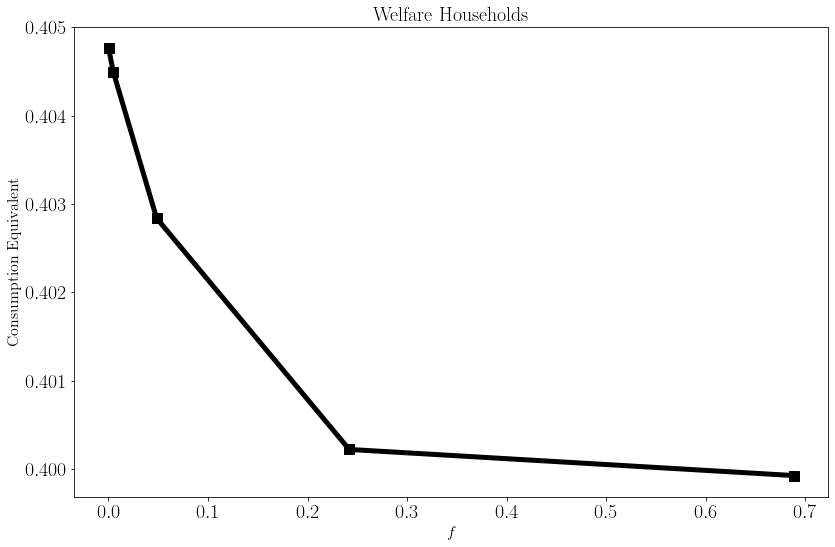

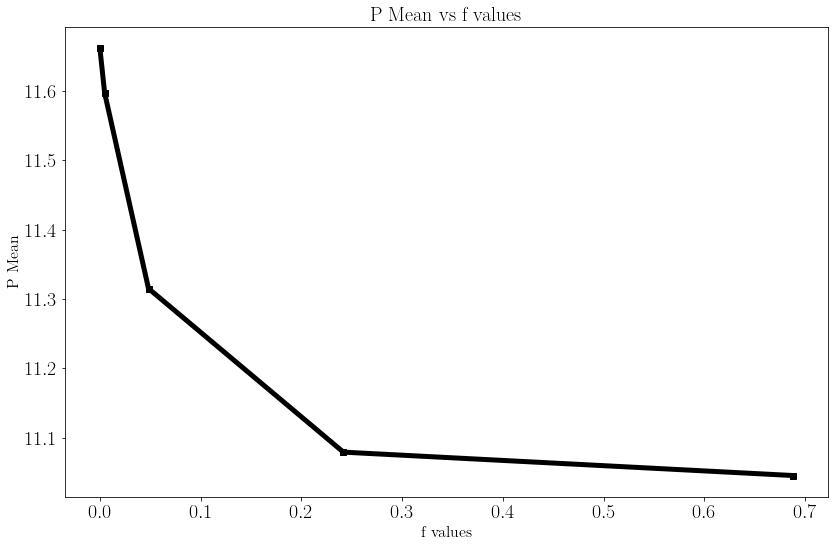

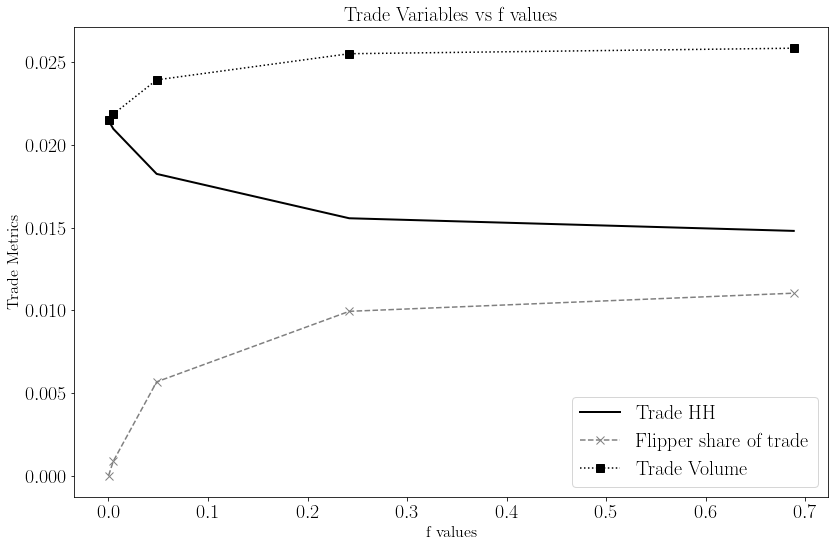

In [681]:
import matplotlib.pyplot as plt

# Plot 1: Welfare Agent vs f values
plt.figure(figsize=(12, 8))
plt.plot(f_values, welfare_agent_results, color='black',marker='s',markersize=10, linewidth=5)
plt.title('Welfare Households', fontsize=20)
plt.xlabel('$f$', fontsize=16)
plt.ylabel('Consumption Equivalent', fontsize=16)
plt.tight_layout()
plt.savefig('/Users/user/Desktop/Praca/Minnesota season 6/JOB MARKET/codes/plots/BIG_welfare.pdf')
plt.show()

# Plot 2: P Mean vs f values
plt.figure(figsize=(12, 8))
plt.plot(f_values, P_mean_results, color='black', linewidth=5,marker='s', label='P Mean')
plt.title('P Mean vs f values', fontsize=20)
plt.xlabel('f values', fontsize=16)
plt.ylabel('P Mean', fontsize=16)
plt.tight_layout()
plt.show()

# Plot 3: Trade Variables (Trade HH, Trade Flipper, Trade Volume) vs f values
plt.figure(figsize=(12, 8))
plt.plot(f_values, trade_hh_results, label='Trade HH', linewidth=2, color='black')
plt.plot(f_values, trade_flipper_results, label='Flipper share of trade', linestyle='--', color='gray', marker='x', markersize=8)
plt.plot(f_values, trade_volume_results, label='Trade Volume', linestyle=':', color='black', marker='s', markersize=8)
plt.title('Trade Variables vs f values', fontsize=20)
plt.legend()
plt.xlabel('f values', fontsize=16)
plt.ylabel('Trade Metrics', fontsize=16)
plt.tight_layout()
plt.show()


In [629]:
# Example fixed parameters


f_baseline = f
f_counterfactual = f_shared_flipped

# Run the model for both values of f
param_draws_baseline, results_list_baseline = counterfactual_exercise('f', f_baseline, f_baseline, fixed_params, delta_grid, 1)
param_draws_counterfactual, results_list_counterfactual = counterfactual_exercise('f', f_counterfactual, f_counterfactual, fixed_params, delta_grid, 1)

# Extract results
results_baseline = results_list_baseline[0]
results_counterfactual = results_list_counterfactual[0]




In [630]:
# Variables to save
variables_to_save = [
    'delta_0_star', 'delta_1_star', 'P0_value', 'P1_value','P_star_value', 'p_values','F_P' ,
    'W0', 'W1', 'V0_values', 'V1_values', 'dH0_values', 'dH1_values', 
    'F0_value', 'F1_value'
]

# Save necessary values for recreating interpolation functions
saved_results = {
    'baseline': {var: results_baseline[var] for var in variables_to_save},
    'counterfactual': {var: results_counterfactual[var] for var in variables_to_save},
}

# Convert the saved results to a DataFrame for easier viewing
saved_results_df = pd.DataFrame({key: pd.Series(value) for key, value in saved_results.items()})

# Optional: Display the DataFrame to check for any NaNs or inconsistencies
print(saved_results_df)

                                                       baseline  \
delta_0_star                                           0.477161   
delta_1_star                                           0.111126   
P0_value                                       9.83633276146372   
P1_value                                     11.876109404021602   
P_star_value                                           8.617334   
p_values      [9.27189838697224, 9.320903718599336, 9.369909...   
F_P           [0.0, 0.00014322768137228696, 0.00057108162446...   
W0                                                     1.993783   
W1                                                    12.401524   
V0_values     [1.7271483639685172, 1.727220660100792, 1.7275...   
V1_values     [11.22490530748815, 11.27496954885514, 11.3257...   
dH0_values    [0.7402303434006403, 0.7332110895020891, 0.726...   
dH1_values    [0.25976965659935974, 0.2667889104979108, 0.27...   
F0_value                                               0.00333

In [631]:
import numpy as np
import pandas as pd

# Save scalar values into a dictionary
scalar_saved_results = {
    'baseline': {
        'delta_0_star': results_baseline['delta_0_star'],
        'delta_1_star': results_baseline['delta_1_star'],
        'F1_value': results_baseline['F1_value'],
        'F0_value': results_baseline['F0_value'],
        'P0_value': results_baseline['P0_value'],
        'P1_value': results_baseline['P1_value'],
        'P_star_value': results_baseline['P_star_value'],
        'trade_volume': results_baseline['trade_volume'],  # Add missing key
        'trade_hh': results_baseline['trade_hh'],  # Add missing key
        'trade_flipper': results_baseline['trade_flipper'],  # Add missing key
        'P_mean': results_baseline['P_mean'],
        'P_variance': results_baseline['P_variance'],
        'shared_flipped': results_baseline['shared_flipped'],
        'return_flipping2': results_baseline['return_flipping2'],
        'avg_time_lived': results_baseline['avg_time_lived'],
        'welfare_agent': results_baseline['welfare_agent'],
        # Add missing keys for welfare calculations
        'total_welfare_per_capita': results_baseline['total_welfare_per_capita'],
        'welfare_homeowners_per_capita': results_baseline['welfare_homeowners_per_capita'],
        'welfare_non_homeowners_per_capita': results_baseline['welfare_non_homeowners_per_capita'],
        'welfare_flipper_per_capita': results_baseline['welfare_flipper_per_capita'],
        'total_misallocation': results_baseline['total_misallocation'],
        'owners_misallocation': results_baseline['owners_misallocation'],
        'non_owners_misallocation': results_baseline['non_owners_misallocation'],
        'W0': results_baseline['W0'],  # Add W0
        'W1': results_baseline['W1'],  # Add W1
    },
    'counterfactual': {
        'delta_0_star': results_counterfactual['delta_0_star'],
        'delta_1_star': results_counterfactual['delta_1_star'],
        'F1_value': results_counterfactual['F1_value'],
        'F0_value': results_counterfactual['F0_value'],
        'P0_value': results_counterfactual['P0_value'],
        'P1_value': results_counterfactual['P1_value'],
        'P_star_value': results_counterfactual['P_star_value'],
        'trade_volume': results_counterfactual['trade_volume'],  # Add missing key
        'trade_hh': results_counterfactual['trade_hh'],  # Add missing key
        'trade_flipper': results_counterfactual['trade_flipper'],  # Add missing key
        'P_mean': results_counterfactual['P_mean'],
        'P_variance': results_counterfactual['P_variance'],
        'shared_flipped': results_counterfactual['shared_flipped'],
        'return_flipping2': results_counterfactual['return_flipping2'],
        'avg_time_lived': results_counterfactual['avg_time_lived'],
        'welfare_agent': results_counterfactual['welfare_agent'],
        # Add missing keys for welfare calculations
        'total_welfare_per_capita': results_counterfactual['total_welfare_per_capita'],
        'welfare_homeowners_per_capita': results_counterfactual['welfare_homeowners_per_capita'],
        'welfare_non_homeowners_per_capita': results_counterfactual['welfare_non_homeowners_per_capita'],
        'welfare_flipper_per_capita': results_counterfactual['welfare_flipper_per_capita'],
        'total_misallocation': results_counterfactual['total_misallocation'],
        'owners_misallocation': results_counterfactual['owners_misallocation'],
        'non_owners_misallocation': results_counterfactual['non_owners_misallocation'],
        'W0': results_counterfactual['W0'],  # Add W0
        'W1': results_counterfactual['W1'],  # Add W1
    }
}

# Create DataFrame for scalar values
scalar_saved_results_df = pd.DataFrame(scalar_saved_results)

# Save array-like values into a separate dictionary using NumPy arrays
array_saved_results = {
    'baseline_dH0': np.array(results_baseline['dH0_values']),
    'baseline_dH1': np.array(results_baseline['dH1_values']),
    'counterfactual_dH0': np.array(results_counterfactual['dH0_values']),
    'counterfactual_dH1': np.array(results_counterfactual['dH1_values']),
    'baseline_V0': np.array(results_baseline['V0_interp'](delta_grid)),
    'baseline_V1': np.array(results_baseline['V1_interp'](delta_grid)),
    'counterfactual_V0': np.array(results_counterfactual['V0_interp'](delta_grid)),
    'counterfactual_V1': np.array(results_counterfactual['V1_interp'](delta_grid)),
    'baseline_p_values': np.array(results_baseline['p_values']),  # Add price vector
    'counterfactual_p_values': np.array(results_counterfactual['p_values']),  # Add price vector
    'baseline_F_P': np.array(results_baseline['F_P']),  # Add price vector
    'counterfactual_F_P': np.array(results_counterfactual['F_P']),  # Add price vector
}

# Print both DataFrames
print("Scalar Results DataFrame:")
print(scalar_saved_results_df)
print("\nArray-like Data Results:")
for key, value in array_saved_results.items():
    print(f"{key}: {value}")



Scalar Results DataFrame:
                                             baseline      counterfactual
delta_0_star                                 0.477161            0.478537
delta_1_star                                 0.111126            0.110766
F1_value                                     0.001505            0.003114
F0_value                                     0.003331            0.007279
P0_value                             9.83633276146372   9.792487107924508
P1_value                           11.876109404021602  11.850086151537031
P_star_value                                 8.617334            8.617334
trade_volume                                 0.021857            0.022238
trade_hh                                     0.020969            0.020447
trade_flipper                                0.000889            0.001791
P_mean                                      11.597236           11.529238
P_variance                                   1.216249            1.209598
shared_flipp

In [632]:
import pandas as pd

# Function to calculate percentage changes
def calculate_percentage_change(baseline, counterfactual):
    return ((counterfactual - baseline) / baseline) * 100

# Adjusted order of variables to match compute_variables_combination function
variables_to_compute = {
    'Mean Price': 'P_mean',
    'Var Price': 'P_variance',
    'Flipper Share': 'shared_flipped',
    'HH Trade': 'trade_hh',
    'Total Trade': 'trade_volume',
    'Return': 'return_flipping2',
    'Turnover': 'avg_time_lived',
    'Total Welfare pc': 'total_welfare_per_capita',
    'Welfare Household pc': 'welfare_agent',
    'Welfare Homeowners pc': 'welfare_homeowners_per_capita',
    'Welfare Non-Homeowners pc': 'welfare_non_homeowners_per_capita',
    'Welfare Flipper pc': 'welfare_flipper_per_capita',
    'Total Misallocation': 'total_misallocation',
    'Owners Misallocation': 'owners_misallocation',
    'Non-Owners Misallocation': 'non_owners_misallocation'
}

# Calculate % changes and store them in a dictionary
percent_changes = {
    variable_name: calculate_percentage_change(
        scalar_saved_results['baseline'][variable_key], 
        scalar_saved_results['counterfactual'][variable_key]
    ) for variable_name, variable_key in variables_to_compute.items()
}

# Convert dictionary to a DataFrame for easy manipulation
percent_changes_df = pd.DataFrame(list(percent_changes.items()), columns=['Variable', 'Change(%)']).round({'Change(%)': 2})

# Create LaTeX table content
latex_table = percent_changes_df.to_latex(index=False, header=True, column_format='lr')

# Manually adjust the LaTeX table to fit the desired format
latex_table = latex_table.replace('\\toprule', '\\toprule\n\\begin{table}[h!]\n\\centering\n\\begin{tabular}{lr}')
latex_table = latex_table.replace('\\bottomrule', '\\bottomrule\n\\end{tabular}\n\\end{table}')

# Save to a file
with open('/Users/user/Desktop/Praca/Minnesota season 6/JOB MARKET/codes/plots/changeBig.tex', 'w') as f:
    f.write(latex_table)

print(percent_changes_df)




# Create a DataFrame to include Baseline, Counterfactual, and Change(%)
values_df = pd.DataFrame({
    'Variable': list(variables_to_compute.keys()),
    'Baseline': [scalar_saved_results['baseline'][variable_key] for variable_key in variables_to_compute.values()],
    'Counterfactual': [scalar_saved_results['counterfactual'][variable_key] for variable_key in variables_to_compute.values()],
    'Change(%)': list(percent_changes.values())
}).round({'Change(%)': 2})

# Convert the DataFrame to LaTeX format
latex_table_with_values = values_df.to_latex(index=False, header=True, column_format='lrrr')

# Manually adjust the LaTeX table to fit the desired format
latex_table_with_values = latex_table_with_values.replace('\\toprule', '\\toprule\n\\begin{table}[h!]\n\\centering\n\\begin{tabular}{lrrr}')
latex_table_with_values = latex_table_with_values.replace('\\bottomrule', '\\bottomrule\n\\end{tabular}\n\\end{table}')

# Save to a file
with open('/Users/user/Desktop/Praca/Minnesota season 6/JOB MARKET/codes/plots/changeBig_with_values.tex', 'w') as f:
    f.write(latex_table_with_values)

# Print the DataFrame
print(values_df)

                     Variable  Change(%)
0                  Mean Price      -0.59
1                   Var Price      -0.55
2               Flipper Share      98.09
3                    HH Trade      -2.49
4                 Total Trade       1.74
5                      Return       0.23
6                    Turnover       1.74
7            Total Welfare pc      -0.40
8        Welfare Household pc      -0.08
9       Welfare Homeowners pc       0.06
10  Welfare Non-Homeowners pc       1.01
11         Welfare Flipper pc      -5.32
12        Total Misallocation      -1.70
13       Owners Misallocation      -1.11
14   Non-Owners Misallocation      -2.25
                     Variable   Baseline  Counterfactual  Change(%)
0                  Mean Price  11.597236       11.529238      -0.59
1                   Var Price   1.216249        1.209598      -0.55
2               Flipper Share   0.040660        0.080545      98.09
3                    HH Trade   0.020969        0.020447      -2.49
4   

In [208]:
from scipy.optimize import fsolve
import pandas as pd

# Parameters (ensure these are defined properly)
lambda1_baseline = lambda1
f_baseline = f
f_counterfactual = f_shared_flipped

def find_lambda1_counterfactual(r, gamma, s, f_baseline, f_counterfactual, lambda1_baseline, rho, delta_grid, delta_0_star_initial, delta_1_star_initial, chi=0.03, tolerance=1e-3):
    # Step 1: Solve for delta_0_star and delta_1_star using baseline lambda1 and f_counterfactual
    delta_0_star, delta_1_star = find_optimal_deltas_iterative(r, gamma, s, f_counterfactual, lambda1_baseline, rho, delta_grid, delta_0_star_initial, 
                                  delta_1_star_initial, chi=0.03,tolerance= 1e-3)
    # Calculate F0 and F1 for the counterfactual case
    F1_counterfactual = F1(delta_0_star, delta_1_star, r, gamma, s, f_counterfactual, lambda1_baseline, rho)
    
    
    # Define the equation to solve for lambda1_counterfactual
    def equation(lambda1_counterfactual):
        F1_baseline = F1(delta_0_star, delta_1_star, r, gamma, s, f_baseline, lambda1_counterfactual, rho)
        
        return lambda1_baseline * F1_counterfactual - lambda1_counterfactual * F1_baseline
    
    # Initial guess for lambda1_counterfactual
    lambda1_initial = lambda1_baseline
    
    # Solve for lambda1_counterfactual
    lambda1_counterfactual_solution = fsolve(equation, lambda1_initial)
    
    return lambda1_counterfactual_solution[0]

lambda1_counterfactual = find_lambda1_counterfactual(r, gamma, s, f_baseline, f_counterfactual, lambda1_baseline, rho, delta_grid, delta_0_star_initial, delta_1_star_initial, chi=0.03, tolerance=1e-3)

# Run the model for both values of f


In [633]:
# Execute counterfactual exercises
param_draws_baseline2, results_list_baseline2 = counterfactual_exercise('lambda1', lambda1_baseline, lambda1_baseline, fixed_params, delta_grid, 1)
param_draws_counterfactual2, results_list_counterfactual2 = counterfactual_exercise('lambda1', lambda1_counterfactual, lambda1_counterfactual, fixed_params, delta_grid, 1)

# Extract results
results_baseline2 = results_list_baseline2[0]
results_counterfactual2 = results_list_counterfactual2[0]


In [634]:

# Variables to save
variables_to_save2 = [
    'delta_0_star', 'delta_1_star', 'P0_value', 'P1_value', 'P_star_value', 'p_values', 'F_P',
    'W0', 'W1', 'V0_values', 'V1_values', 'dH0_values', 'dH1_values',
    'F0_value', 'F1_value'
]

# Save necessary values for recreating interpolation functions
saved_results2 = {
    'baseline': {var: results_baseline2[var] for var in variables_to_save2},
    'counterfactual': {var: results_counterfactual2[var] for var in variables_to_save2},
}

# Convert the saved results to a DataFrame for easier viewing
saved_results_df2 = pd.DataFrame({key: pd.Series(value) for key, value in saved_results2.items()})

# Optional: Display the DataFrame to check for any NaNs or inconsistencies
print(saved_results_df2)



                                                       baseline  \
delta_0_star                                           0.477161   
delta_1_star                                           0.111126   
P0_value                                       9.83633276146372   
P1_value                                     11.876109404021602   
P_star_value                                           8.617334   
p_values      [9.27189838697224, 9.320903718599336, 9.369909...   
F_P           [0.0, 0.00014322768137228696, 0.00057108162446...   
W0                                                     1.993783   
W1                                                    12.401524   
V0_values     [1.7271483639685172, 1.727220660100792, 1.7275...   
V1_values     [11.22490530748815, 11.27496954885514, 11.3257...   
dH0_values    [0.7402303434006403, 0.7332110895020891, 0.726...   
dH1_values    [0.25976965659935974, 0.2667889104979108, 0.27...   
F0_value                                               0.00333

In [635]:
import numpy as np
import pandas as pd

# Save scalar values into a dictionary
scalar_saved_results2 = {
    'baseline': {
        'delta_0_star': results_baseline2['delta_0_star'],
        'delta_1_star': results_baseline2['delta_1_star'],
        'F1_value': results_baseline2['F1_value'],
        'F0_value': results_baseline2['F0_value'],
        'P0_value': results_baseline2['P0_value'],
        'P1_value': results_baseline2['P1_value'],
        'P_star_value': results_baseline2['P_star_value'],
        'trade_volume': results_baseline2['trade_volume'],  # Add missing key
        'trade_hh': results_baseline2['trade_hh'],  # Add missing key
        'trade_flipper': results_baseline2['trade_flipper'],  # Add missing key
        'P_mean': results_baseline2['P_mean'],
        'P_variance': results_baseline2['P_variance'],
        'shared_flipped': results_baseline2['shared_flipped'],
        'return_flipping2': results_baseline2['return_flipping2'],
        'avg_time_lived': results_baseline2['avg_time_lived'],
        'welfare_agent': results_baseline2['welfare_agent'],
        # Add missing keys for welfare calculations
        'total_welfare_per_capita': results_baseline2['total_welfare_per_capita'],
        'welfare_homeowners_per_capita': results_baseline2['welfare_homeowners_per_capita'],
        'welfare_non_homeowners_per_capita': results_baseline2['welfare_non_homeowners_per_capita'],
        'welfare_flipper_per_capita': results_baseline2['welfare_flipper_per_capita'],
        'total_misallocation': results_baseline2['total_misallocation'],
        'owners_misallocation': results_baseline2['owners_misallocation'],
        'non_owners_misallocation': results_baseline2['non_owners_misallocation'],
        'W0': results_baseline2['W0'],  # Add W0
        'W1': results_baseline2['W1'],  # Add W1
    },
    'counterfactual': {
        'delta_0_star': results_counterfactual2['delta_0_star'],
        'delta_1_star': results_counterfactual2['delta_1_star'],
        'F1_value': results_counterfactual2['F1_value'],
        'F0_value': results_counterfactual2['F0_value'],
        'P0_value': results_counterfactual2['P0_value'],
        'P1_value': results_counterfactual2['P1_value'],
        'P_star_value': results_counterfactual2['P_star_value'],
        'trade_volume': results_counterfactual2['trade_volume'],  # Add missing key
        'trade_hh': results_counterfactual2['trade_hh'],  # Add missing key
        'trade_flipper': results_counterfactual2['trade_flipper'],  # Add missing key
        'P_mean': results_counterfactual2['P_mean'],
        'P_variance': results_counterfactual2['P_variance'],
        'shared_flipped': results_counterfactual2['shared_flipped'],
        'return_flipping2': results_counterfactual2['return_flipping2'],
        'avg_time_lived': results_counterfactual2['avg_time_lived'],
        'welfare_agent': results_counterfactual2['welfare_agent'],
        # Add missing keys for welfare calculations
        'total_welfare_per_capita': results_counterfactual2['total_welfare_per_capita'],
        'welfare_homeowners_per_capita': results_counterfactual2['welfare_homeowners_per_capita'],
        'welfare_non_homeowners_per_capita': results_counterfactual2['welfare_non_homeowners_per_capita'],
        'welfare_flipper_per_capita': results_counterfactual2['welfare_flipper_per_capita'],
        'total_misallocation': results_counterfactual2['total_misallocation'],
        'owners_misallocation': results_counterfactual2['owners_misallocation'],
        'non_owners_misallocation': results_counterfactual2['non_owners_misallocation'],
        'W0': results_counterfactual2['W0'],  # Add W0
        'W1': results_counterfactual2['W1'],  # Add W1
    }
}

# Create DataFrame for scalar values
scalar_saved_results_df2 = pd.DataFrame(scalar_saved_results2)

# Save array-like values into a separate dictionary using NumPy arrays
array_saved_results2 = {
    'baseline_dH0': np.array(results_baseline2['dH0_values']),
    'baseline_dH1': np.array(results_baseline2['dH1_values']),
    'counterfactual_dH0': np.array(results_counterfactual2['dH0_values']),
    'counterfactual_dH1': np.array(results_counterfactual2['dH1_values']),
    'baseline_V0': np.array(results_baseline2['V0_interp'](delta_grid)),
    'baseline_V1': np.array(results_baseline2['V1_interp'](delta_grid)),
    'counterfactual_V0': np.array(results_counterfactual2['V0_interp'](delta_grid)),
    'counterfactual_V1': np.array(results_counterfactual2['V1_interp'](delta_grid)),
    'baseline_p_values': np.array(results_baseline2['p_values']),  # Add price vector
    'counterfactual_p_values': np.array(results_counterfactual2['p_values']),  # Add price vector
    'baseline_F_P': np.array(results_baseline2['F_P']),  # Add price vector
    'counterfactual_F_P': np.array(results_counterfactual2['F_P']),  # Add price vector
}

# Print both DataFrames
print("Scalar Results DataFrame:")
print(scalar_saved_results_df2)
print("\nArray-like Data Results:")
for key, value in array_saved_results2.items():
    print(f"{key}: {value}")


Scalar Results DataFrame:
                                             baseline      counterfactual
delta_0_star                                 0.477161            0.538529
delta_1_star                                 0.111126            0.154345
F1_value                                     0.001505            0.002199
F0_value                                     0.003331            0.002638
P0_value                             9.83633276146372  10.030159879908544
P1_value                           11.876109404021602  12.165219382064754
P_star_value                                 8.617334            8.617334
trade_volume                                 0.021857             0.02232
trade_hh                                     0.020969            0.020212
trade_flipper                                0.000889            0.002107
P_mean                                      11.597236           11.534316
P_variance                                   1.216249             1.18933
shared_flipp

In [636]:
import pandas as pd

# Function to calculate percentage changes
def calculate_percentage_change(baseline, counterfactual):
    return ((counterfactual - baseline) / baseline) * 100

# Adjusted order of variables to match compute_variables_combination function
variables_to_compute2 = {
    'Mean Price': 'P_mean',
    'Var Price': 'P_variance',
    'Flipper Share': 'shared_flipped',
    'HH Trade': 'trade_hh',
    'Total Trade': 'trade_volume',
    'Return': 'return_flipping2',
    'Turnover': 'avg_time_lived',
    'Total Welfare pc': 'total_welfare_per_capita',
    'Welfare Household pc': 'welfare_agent',
    'Welfare Homeowners pc': 'welfare_homeowners_per_capita',
    'Welfare Non-Homeowners pc': 'welfare_non_homeowners_per_capita',
    'Welfare Flipper pc': 'welfare_flipper_per_capita',
    'Total Misallocation': 'total_misallocation',
    'Owners Misallocation': 'owners_misallocation',
    'Non-Owners Misallocation': 'non_owners_misallocation'
}

# Calculate % changes and store them in a dictionary
percent_changes2 = {
    variable_name: calculate_percentage_change(
        scalar_saved_results2['baseline'][variable_key], 
        scalar_saved_results2['counterfactual'][variable_key]
    ) for variable_name, variable_key in variables_to_compute2.items()
}

# Convert dictionary to a DataFrame for easy manipulation
percent_changes_df2 = pd.DataFrame(list(percent_changes2.items()), columns=['Variable', 'Change(%)']).round({'Change(%)': 2})

# Create LaTeX table content
latex_table2 = percent_changes_df2.to_latex(index=False, header=True, column_format='lr')

# Manually adjust the LaTeX table to fit the desired format
latex_table2 = latex_table2.replace('\\toprule', '\\toprule\n\\begin{table}[h!]\n\\centering\n\\begin{tabular}{lr}')
latex_table2= latex_table2.replace('\\bottomrule', '\\bottomrule\n\\end{tabular}\n\\end{table}')

# Save to a file
with open('/Users/user/Desktop/Praca/Minnesota season 6/JOB MARKET/codes/plots/changeBig_lambda.tex', 'w') as f:
    f.write(latex_table2)

print(percent_changes_df2)




# Create a DataFrame to include Baseline, Counterfactual, and Change(%)
values_df2 = pd.DataFrame({
    'Variable': list(variables_to_compute2.keys()),
    'Baseline': [scalar_saved_results2['baseline'][variable_key] for variable_key in variables_to_compute2.values()],
    'Counterfactual': [scalar_saved_results2['counterfactual'][variable_key] for variable_key in variables_to_compute2.values()],
    'Change(%)': list(percent_changes2.values())
}).round({'Change(%)': 2})

# Convert the DataFrame to LaTeX format
latex_table_with_values2 = values_df2.to_latex(index=False, header=True, column_format='lrrr')

# Manually adjust the LaTeX table to fit the desired format
latex_table_with_values2 = latex_table_with_values2.replace('\\toprule', '\\toprule\n\\begin{table}[h!]\n\\centering\n\\begin{tabular}{lrrr}')
latex_table_with_values2 = latex_table_with_values2.replace('\\bottomrule', '\\bottomrule\n\\end{tabular}\n\\end{table}')

# Save to a file
with open('/Users/user/Desktop/Praca/Minnesota season 6/JOB MARKET/codes/plots/changeBig_with_values_lambda.tex', 'w') as f:
    f.write(latex_table_with_values2)

# Print the DataFrame
print(values_df2)

                     Variable  Change(%)
0                  Mean Price      -0.54
1                   Var Price      -2.21
2               Flipper Share     132.18
3                    HH Trade      -3.61
4                 Total Trade       2.12
5                      Return       0.45
6                    Turnover       2.12
7            Total Welfare pc       0.41
8        Welfare Household pc       0.08
9       Welfare Homeowners pc       0.10
10  Welfare Non-Homeowners pc       1.10
11         Welfare Flipper pc     147.70
12        Total Misallocation      -2.38
13       Owners Misallocation      -2.17
14   Non-Owners Misallocation      -2.58
                     Variable   Baseline  Counterfactual  Change(%)
0                  Mean Price  11.597236       11.534316      -0.54
1                   Var Price   1.216249        1.189330      -2.21
2               Flipper Share   0.040660        0.094406     132.18
3                    HH Trade   0.020969        0.020212      -3.61
4   

## Additional but i gave up on decomposition- doesnt clarify anything

In [ ]:
from scipy.integrate import simps, IntegrationWarning
from scipy.interpolate import interp1d
import warnings
import pandas as pd
import numpy as np

# Suppress integration warnings for now
warnings.filterwarnings('ignore', category=IntegrationWarning)

def compute_variables_combination(scalar_df, array_df, scenario, delta_grid, r, gamma, s, f, lambda1, rho):
    if scenario == 'Baseline':
        f = f_baseline
        # All baseline values
        delta_0_star = scalar_df.loc['delta_0_star', 'baseline']
        delta_1_star = scalar_df.loc['delta_1_star', 'baseline']
        F1_value = scalar_df.loc['F1_value', 'baseline']
        F0_value = scalar_df.loc['F0_value', 'baseline']
        V0_values = array_df['baseline_V0']
        V1_values = array_df['baseline_V1']
        dH0_values = array_df['baseline_dH0']
        dH1_values = array_df['baseline_dH1']
        P0_value = scalar_df.loc['P0_value', 'baseline']
        P1_value = scalar_df.loc['P1_value', 'baseline']
        W0_val = scalar_df.loc['W0', 'baseline']
        W1_val = scalar_df.loc['W1', 'baseline']
        p_values = array_df['baseline_p_values']  # Reset index
        F_P = array_df['baseline_F_P'] # Reset index        
        P_mean, P_variance = compute_P_mean_variance(results_baseline['p_values'],results_baseline['F_P'])

    elif scenario == 'PE':
        f = f_baseline
        # Counterfactual delta, baseline everything else
        delta_0_star = scalar_df.loc['delta_0_star', 'counterfactual']
        delta_1_star = scalar_df.loc['delta_1_star', 'counterfactual']
        F1_value = scalar_df.loc['F1_value', 'baseline']
        F0_value = scalar_df.loc['F0_value', 'baseline']
        V0_values = array_df['baseline_V0']
        V1_values = array_df['baseline_V1']
        dH0_values = array_df['baseline_dH0']
        dH1_values = array_df['baseline_dH1']
        P0_value = scalar_df.loc['P0_value', 'baseline']
        P1_value = scalar_df.loc['P1_value', 'baseline']
        W0_val = scalar_df.loc['W0', 'baseline']
        W1_val = scalar_df.loc['W1', 'baseline']
        p_values = array_df['baseline_p_values']  # Reset index
        F_P = array_df['baseline_F_P']
        P_mean, P_variance = compute_P_mean_variance(results_baseline['p_values'],results_baseline['F_P'])

    elif scenario == 'GE Prices':
        f = f_baseline
        # Counterfactual delta, P0, P1, price distribution, baseline everything else
        delta_0_star = scalar_df.loc['delta_0_star', 'counterfactual']
        delta_1_star = scalar_df.loc['delta_1_star', 'counterfactual']
        F1_value = scalar_df.loc['F1_value', 'baseline']
        F0_value = scalar_df.loc['F0_value', 'baseline']
        V0_values = array_df['counterfactual_V0']
        V1_values = array_df['counterfactual_V1']
        dH0_values = array_df['baseline_dH0']
        dH1_values = array_df['baseline_dH1']
        P0_value = scalar_df.loc['P0_value', 'counterfactual']
        P1_value = scalar_df.loc['P1_value', 'counterfactual']
        W0_val = scalar_df.loc['W0', 'counterfactual']
        W1_val = scalar_df.loc['W1', 'counterfactual']
        p_values = array_df['counterfactual_p_values']
        F_P = array_df['counterfactual_F_P']
        P_mean, P_variance = compute_P_mean_variance(results_counterfactual['p_values'], results_counterfactual['F_P'])

    elif scenario == 'GE HH distribution':
        f = f_baseline
        # Counterfactual delta, dH0, dH1, baseline everything else
        delta_0_star = scalar_df.loc['delta_0_star', 'counterfactual']
        delta_1_star = scalar_df.loc['delta_1_star', 'counterfactual']
        F1_value = scalar_df.loc['F1_value', 'baseline']
        F0_value = scalar_df.loc['F0_value', 'baseline']
        V0_values = array_df['counterfactual_V0']
        V1_values = array_df['counterfactual_V1']
        dH0_values = array_df['counterfactual_dH0']
        dH1_values = array_df['counterfactual_dH1']
        P0_value = scalar_df.loc['P0_value', 'counterfactual']
        P1_value = scalar_df.loc['P1_value', 'counterfactual']
        W0_val = scalar_df.loc['W0', 'counterfactual']
        W1_val = scalar_df.loc['W1', 'counterfactual']
        p_values = array_df['counterfactual_p_values']
        F_P = array_df['counterfactual_F_P']
        P_mean, P_variance = compute_P_mean_variance(results_counterfactual['p_values'], results_counterfactual['F_P'])

    elif scenario == 'Counterfactual':
        f = f_counterfactual
        # All counterfactual values
        delta_0_star = scalar_df.loc['delta_0_star', 'counterfactual']
        delta_1_star = scalar_df.loc['delta_1_star', 'counterfactual']
        F1_value = scalar_df.loc['F1_value', 'counterfactual']
        F0_value = scalar_df.loc['F0_value', 'counterfactual']
        V0_values = array_df['counterfactual_V0']
        V1_values = array_df['counterfactual_V1']
        dH0_values = array_df['counterfactual_dH0']
        dH1_values = array_df['counterfactual_dH1']
        P0_value = scalar_df.loc['P0_value', 'counterfactual']
        P1_value = scalar_df.loc['P1_value', 'counterfactual']
        W0_val = scalar_df.loc['W0', 'counterfactual']
        W1_val = scalar_df.loc['W1', 'counterfactual']
        p_values = array_df['counterfactual_p_values']
        F_P = array_df['counterfactual_F_P']
        P_mean, P_variance = compute_P_mean_variance(results_counterfactual['p_values'], results_counterfactual['F_P'])

    else:
        raise ValueError("Invalid scenario")

    V1_interp = interp1d(delta_grid, V1_values, kind='linear', fill_value="extrapolate")
    V0_interp = interp1d(delta_grid, V0_values, kind='linear', fill_value="extrapolate")

    # Running value iteration to get Delta_V
    Delta_V, _ = value_iteration(delta_grid, delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho)

    # Interpolating Delta_V
    Delta_V_interp = interp1d(delta_grid, Delta_V, kind='linear', fill_value="extrapolate")

    # Compute trade volumes
    kappa, kappa1, kappa2 = trade_volume(r, gamma, s, f, lambda1, rho, dH0_values, dH1_values, 
                                         delta_0_star, delta_1_star)
    
    # Calculate price distribution (CDF) - now p_values and F_P come from the saved array
    
    # Additional variables calculation
    shared_flipped = kappa2 / kappa
    avg_time_lived = kappa / s
    return_flipping = P1(Delta_V_interp, delta_0_star) - P0(Delta_V_interp, delta_1_star)

    intV1, intV0, welfare_agent, intW0, intW1, welfare_flipper = calculate_welfare(
        V1_values, V0_values, dH1_values, dH0_values, delta_grid, F0_value, F1_value, W0_val, W1_val, 
        {'r': r, 'gamma': gamma, 's': s, 'f': f, 'lambda1': lambda1, 'rho': rho}
    )

    # Additional calculations for misallocations
    delta_star = (1 - s) 
    delta_star_idx = np.searchsorted(delta_grid, delta_star)
    if delta_star_idx >= len(delta_grid):
        delta_star_idx = len(delta_grid) - 1

    # Integrate dH0 and dH1 correctly
    owners_misallocation = simps(dH1_values[:delta_star_idx + 1], delta_grid[:delta_star_idx + 1])
    non_owners_misallocation = simps(dH0_values[delta_star_idx:], delta_grid[delta_star_idx:])
    total_misallocation = non_owners_misallocation + owners_misallocation

    # Calculate integrals for welfare per capita calculations
    integral_dH1 = simps(dH1_values, delta_grid)
    integral_dH0 = simps(dH0_values, delta_grid)

    # Update welfare per capita calculations
    welfare_flipper_per_capita = welfare_flipper / f
    welfare_homeowners_per_capita = intV1 / integral_dH1
    welfare_non_homeowners_per_capita = intV0 / integral_dH0

    # Compile all computed results into a dictionary in the specified order
    results_combination = {
        'Mean Price': P_mean,
        'Var Price': P_variance,
        'Flipper Share': shared_flipped,
        'HH Trade': kappa1,
        'Total Trade': kappa,
        'Return': return_flipping,
        'Avg Tenure': avg_time_lived,
        'Total Welfare pc': (welfare_agent + welfare_flipper) / (1 + f),
        'Welfare Homeowners pc': welfare_homeowners_per_capita,
        'Welfare Non-Homeowners pc': welfare_non_homeowners_per_capita,
        'Welfare Flipper pc': welfare_flipper_per_capita,
        'Total Misallocation': total_misallocation,
        'Owners Misallocation': owners_misallocation,
        'Non-Owners Misallocation': non_owners_misallocation,
    }

    return results_combination


In [ ]:
# Assuming scalar_saved_results_df and array_saved_results_df have been defined as in previous steps
scenarios = ['Baseline', 'PE', 'GE Prices', 'GE HH distribution', 'Counterfactual']

# Compute the comparison results for each scenario
comparison_results = {
    scenario: compute_variables_combination(scalar_saved_results_df, array_saved_results_df, scenario,delta_grid, r, gamma, s, f, lambda1, rho
    ) for scenario in scenarios
}

# Convert results to a DataFrame and transpose
comparison_df = pd.DataFrame(comparison_results).T

# Round values to two decimal places
comparison_df = comparison_df.round(2)

# Save the DataFrame to a LaTeX file
comparison_df.T.to_latex('/Users/user/Desktop/Praca/Minnesota season 6/JOB MARKET/codes/plots/comparison_table_BIG.tex')

# Print the DataFrame
print(comparison_df.T)


In [ ]:
# Generate Relative Changes Table
relative_changes_df = comparison_df.T.copy()

# Calculate relative changes for each column (except the first one)
for col in range(1, len(scenarios)):
    relative_changes_df.iloc[:, col] = 100 * (comparison_df.T.iloc[:, col] - comparison_df.T.iloc[:, col-1]) / comparison_df.T.iloc[:, 0]

# Remove the first column (Baseline) for clarity
relative_changes_df = relative_changes_df.drop(columns=[scenarios[0]])

# Round values to two decimal places
relative_changes_df = relative_changes_df.round(2)

# Save the Relative Changes DataFrame to a LaTeX file
relative_changes_df.to_latex('/Users/user/Desktop/Praca/Minnesota season 6/JOB MARKET/codes/plots/relative_changes_table_BIG.tex')

print(relative_changes_df)


Diagnostics


In [ ]:
# Lists to store results
optimal_delta_0_stars = []
optimal_delta_1_stars = []
elapsed_times = []

for _ in range(6):
    start_time = time.time()
    
    delta_0_star_initial, delta_1_star_initial = np.random.random(2)
    optimal_delta_0_star, optimal_delta_1_star = find_optimal_deltas_iterative(r, gamma, s, f, lambda1, rho, delta_grid, delta_0_star_initial, delta_1_star_initial)

    
    end_time = time.time()
    elapsed_time = end_time - start_time
    
    print(f"Total time for operations: {elapsed_time:.2f} seconds")
    
    # Store results
    optimal_delta_0_stars.append(optimal_delta_0_star)
    optimal_delta_1_stars.append(optimal_delta_1_star)
    elapsed_times.append(elapsed_time)

# Convert lists to numpy arrays for easier manipulation
optimal_delta_0_stars = np.array(optimal_delta_0_stars)
optimal_delta_1_stars = np.array(optimal_delta_1_stars)
elapsed_times = np.array(elapsed_times)


In [ ]:
# Disable LaTeX rendering in Matplotlib
#plt.rcParams['text.usetex'] = False
# Plot histograms with means marked
# Plot histograms with means marked
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.hist(optimal_delta_0_stars, bins=5, color='blue', alpha=0.7)
plt.axvline(np.nanmean(optimal_delta_0_stars), color='red', linestyle='dashed', linewidth=2)
plt.title(r'Histogram of $\delta_0$')
plt.xlabel(r'$\delta_0$')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
plt.hist(optimal_delta_1_stars, bins=5, color='green', alpha=0.7)
plt.axvline(np.nanmean(optimal_delta_1_stars), color='red', linestyle='dashed', linewidth=2)
plt.title(r'Histogram of $\delta_1$')
plt.xlabel(r'$\delta_1$')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
plt.hist(elapsed_times, bins=20, color='orange', alpha=0.7)
plt.axvline(np.nanmean(elapsed_times), color='red', linestyle='dashed', linewidth=2)
plt.title('Time Distribution')
plt.xlabel('Time (seconds)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()